In [1]:
%matplotlib inline
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from operator import itemgetter
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import matplotlib.colors as colors
from sklearn.cluster import MeanShift
from itertools import cycle
from scipy import ndimage
from scipy.ndimage import measurements
from skimage import measure
from pylab import *

In [2]:
c =0.299792458
n =1.3195
v=c/n 
print v

0.227201559682


In [3]:
info = pickle.load(open("./double_pulse/DP_Tau1PeV_Big.pkl", "rb"))
data = np.load("./double_pulse/DP_Tau1PeV_Big_data.npy")
print len(info), len(data)

216 216


In [4]:
for event in data:
    for i in event:
        if i[4] < 0:
            i[4] = 0

In [5]:
for i,e in enumerate(info):
    print i, e["id"],"E_nu={0:2.2e} E_tau={1:2.2e} Qtot={2:.2f}".format(e['nu_energy'], e['tau_energy'], e['qtotal'])

0 (76, 4294967295, 631, 0) E_nu=1.43e+06 E_tau=1.06e+06 Qtot=120.10
1 (86, 4294967295, 261, 0) E_nu=1.32e+06 E_tau=1.16e+06 Qtot=23433.80
2 (72, 4294967295, 409, 0) E_nu=1.07e+06 E_tau=1.03e+06 Qtot=74635.15
3 (72, 4294967295, 436, 0) E_nu=1.17e+06 E_tau=1.07e+06 Qtot=82397.20
4 (72, 4294967295, 737, 0) E_nu=1.05e+06 E_tau=1.02e+06 Qtot=33997.90
5 (30, 4294967295, 99, 0) E_nu=1.53e+06 E_tau=1.00e+06 Qtot=1325.27
6 (30, 4294967295, 189, 0) E_nu=1.00e+06 E_tau=1.00e+06 Qtot=98646.33
7 (30, 4294967295, 277, 0) E_nu=1.55e+06 E_tau=1.16e+06 Qtot=3747.80
8 (30, 4294967295, 533, 0) E_nu=1.35e+06 E_tau=1.10e+06 Qtot=1894.08
9 (19, 4294967295, 133, 0) E_nu=1.07e+06 E_tau=1.07e+06 Qtot=65422.35
10 (19, 4294967295, 314, 0) E_nu=2.21e+06 E_tau=1.08e+06 Qtot=10390.80
11 (28, 4294967295, 340, 0) E_nu=1.15e+06 E_tau=1.11e+06 Qtot=635.07
12 (28, 4294967295, 630, 0) E_nu=1.02e+06 E_tau=1.01e+06 Qtot=645.77
13 (28, 4294967295, 634, 0) E_nu=1.52e+06 E_tau=1.19e+06 Qtot=3869.20
14 (98, 4294967295, 569, 0)

In [6]:
def make_plots(labels, data, truth):
   
    mask_b1 = labels==0
    mask_b2 = labels==1
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111)
    ax.scatter(data[mask_b1][:,3],data[mask_b1][:,2],s=data[mask_b1][:,4],c='r',alpha =0.05,marker='.')
    ax.scatter(data[mask_b2][:,3],data[mask_b2][:,2],s=data[mask_b2][:,4],c='b',alpha =0.05,marker='.')
   # ax.scatter(truth[:,3],truth[:,2], s=truth[:,4], c='g', marker='.')
    
    plt.show()

In [7]:
def make_waveforms(labels,data,info):
    print labels.shape, data.shape, len(info)
    qdoms = -np.unique(-data[:,9])[:30]
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace = .5, wspace=.1)
    for i, q in enumerate(qdoms):
        mask = data[:,9]==q 
        wf_data = data[mask]
        if len(wf_data) != 128:
            print wf_data[:,5]
            print wf_data[:,6]
        wf_labels = labels[mask]
        wf_data[wf_data[:, 3].argsort()]
        max_wf = np.max(wf_data[:,4])
        ax = fig.add_subplot(10, 3, i+1)
        ax.text(wf_data[0][3], max_wf*1.0, "{0},{1}, E{2:2.2e}GeV, Q{3:.1f}PE, q{4:.1f}PE".format(wf_data[0][7],wf_data[0][8],info["tau_energy"],info["qtotal"],q), color="k",fontsize = 16 )     
        ax.set_ylim(0,max_wf*1.2)
        
        mask_b1 = wf_labels==0
        mask_b2 = wf_labels==1
        
        ax.plot(wf_data[mask_b1][:,3],wf_data[mask_b1][:,4],'r', label = "ONE")
        ax.plot(wf_data[mask_b2][:,3],wf_data[mask_b2][:,4],'b', label = "TWO")
            
    fig.tight_layout()
    #name_0 = name+"_{0}.png".format(data.index(i))
    #plt.savefig(name_0)
    plt.show()
    #plt.close('all')

In [8]:
virg_data = []
for event in data:
    event_data = []
    for d in event:
        if d[6] == 0:
            event_data.append(d)
    event_data = np.vstack(event_data)
    virg_data.append(event_data)

In [9]:
def bang2_pos_calculate(one, one_dir, length):
    if length > 0:
        l_x = np.sin(one_dir[0])*np.cos(one_dir[1])*length
        l_y = np.sin(one_dir[0])*np.sin(one_dir[1])*length
        l_z = np.cos(one_dir[0])*length
    two = [0,0,0]
    two[0] = one[0]-l_x 
    two[1] = one[1]-l_y 
    two[2] = one[2]-l_z 
    
    return two

In [10]:
true_bangs = []
for e in info:
    b1 = e['tau_position']+(e['tau_time'][0]*v,1000) 
    b2_pos = bang2_pos_calculate(e['tau_position'],e["tau_direction"],e["tau_length"])
    b2 = b2_pos +[e['tau_time'][1]*v,1000]
    
    true_bangs.append(np.stack((b1,b2)))
print true_bangs[57].shape

(2, 5)


In [11]:
#select the HighCharge String
event_hq_string = []
for event in virg_data:
    sts = -np.unique(-event[:,7])
    st_charge = []

    for st in sts:
        st_charge.append((st, sum(event[event[:,7]==st][:,9])))

    st_charge = np.array(st_charge)
    event_hq_string.append(st_charge[st_charge[:, 1].argsort()][::-1][0])
event_hq_string = np.array(event_hq_string)

In [12]:
print event_hq_string.shape

(216, 2)


In [13]:
string_data =[]
for i,event in enumerate(virg_data):
    mask = event[:,7]==event_hq_string[i][0]
    string_data.append(event[mask])
print len(string_data)

216


In [14]:
print string_data[0]

[[  5.76369995e+02   1.70919998e+02   4.94040009e+02 ...,   5.00000000e+01
    1.00000000e+00   6.37500009e+00]
 [  5.76369995e+02   1.70919998e+02   4.94040009e+02 ...,   5.00000000e+01
    1.00000000e+00   6.37500009e+00]
 [  5.76369995e+02   1.70919998e+02   4.94040009e+02 ...,   5.00000000e+01
    1.00000000e+00   6.37500009e+00]
 ..., 
 [  5.76369995e+02   1.70919998e+02   3.91920013e+02 ...,   5.00000000e+01
    7.00000000e+00   5.24999976e-01]
 [  5.76369995e+02   1.70919998e+02   3.91920013e+02 ...,   5.00000000e+01
    7.00000000e+00   5.24999976e-01]
 [  5.76369995e+02   1.70919998e+02   3.91920013e+02 ...,   5.00000000e+01
    7.00000000e+00   5.24999976e-01]]


In [15]:
def make_plots_no_label(data):
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111)
    ax.scatter(data[:,3],data[:,2],s=data[:,4],c='r',alpha =0.05,marker='.') 
    plt.show()

0


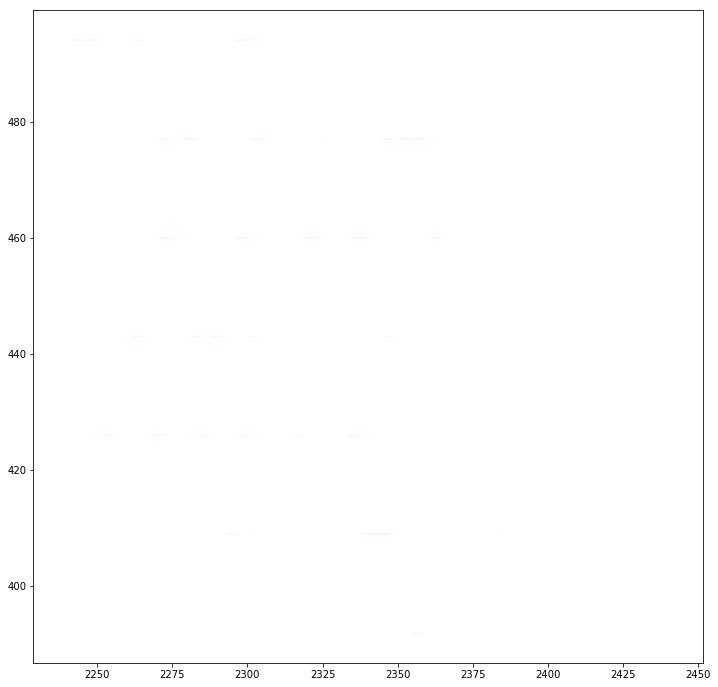

1


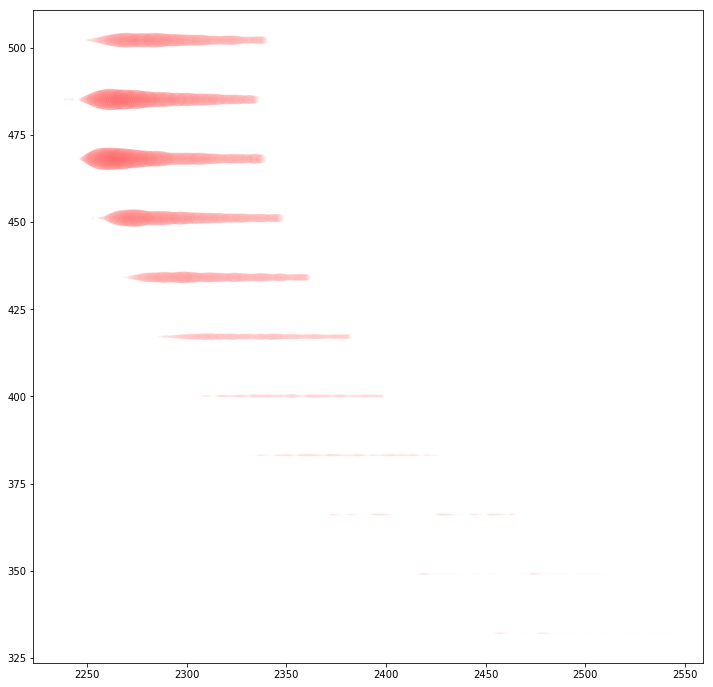

2


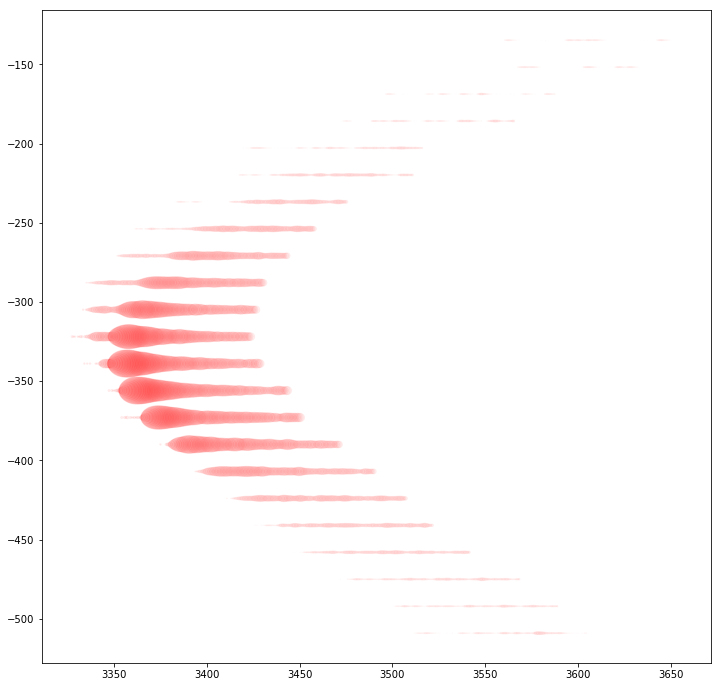

3


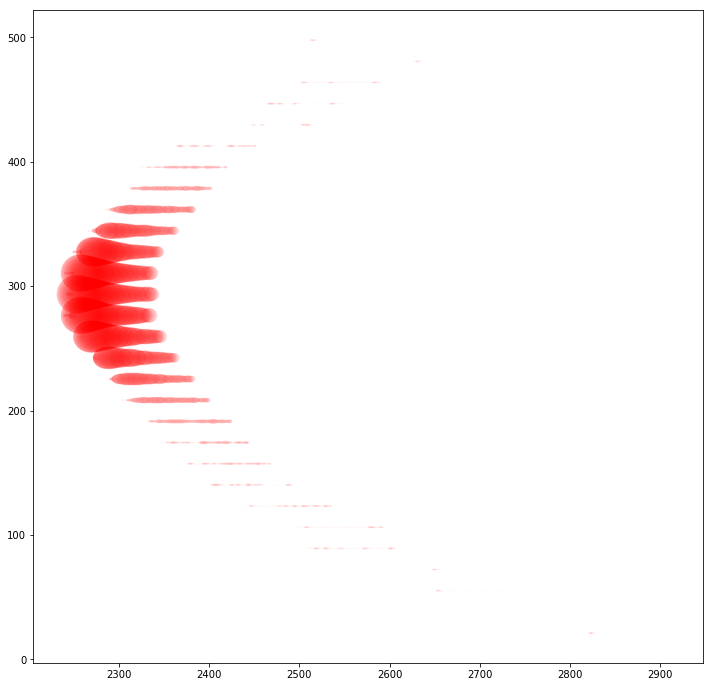

4


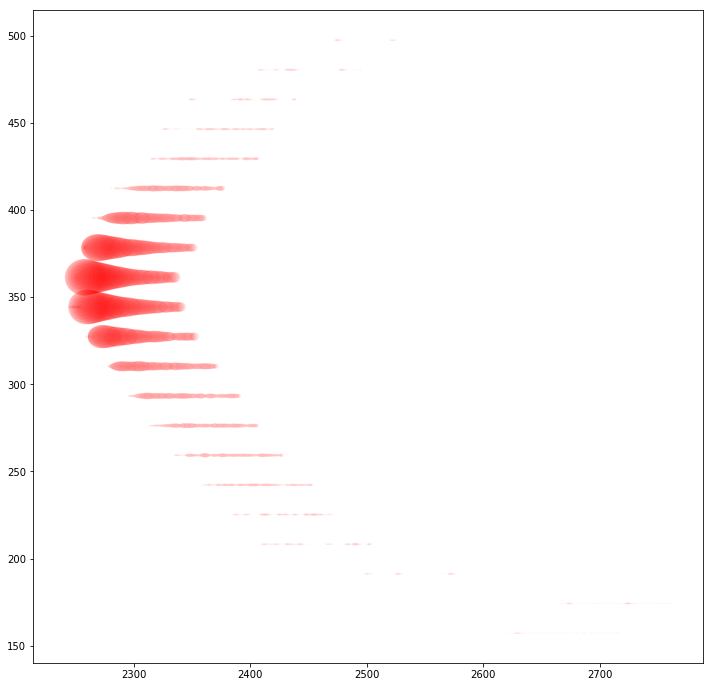

5


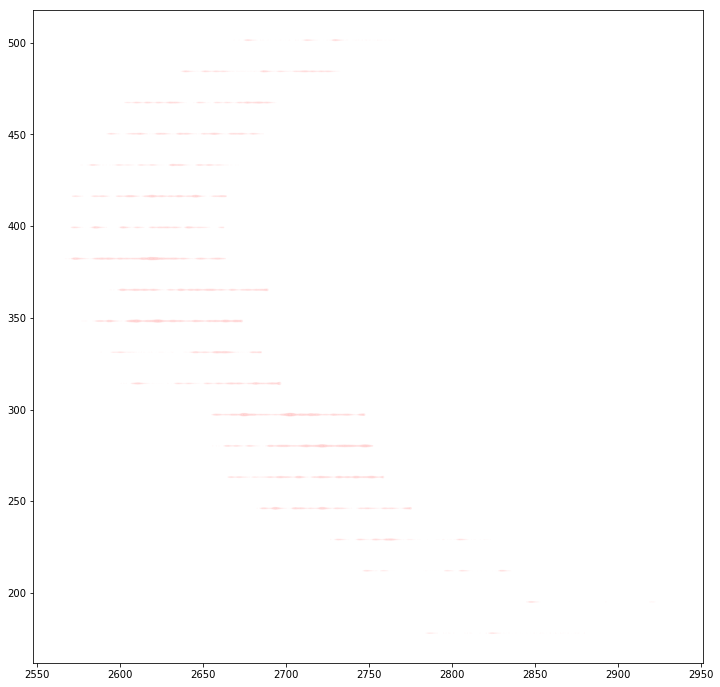

6


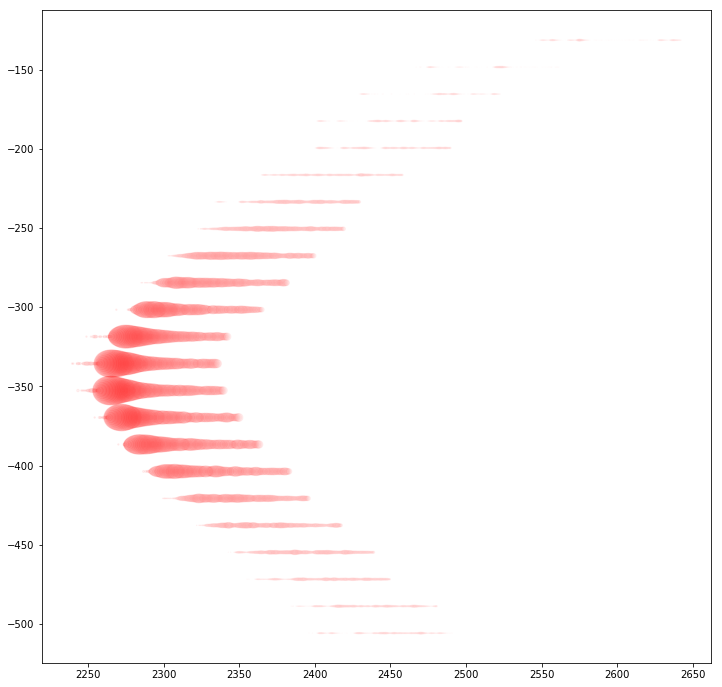

7


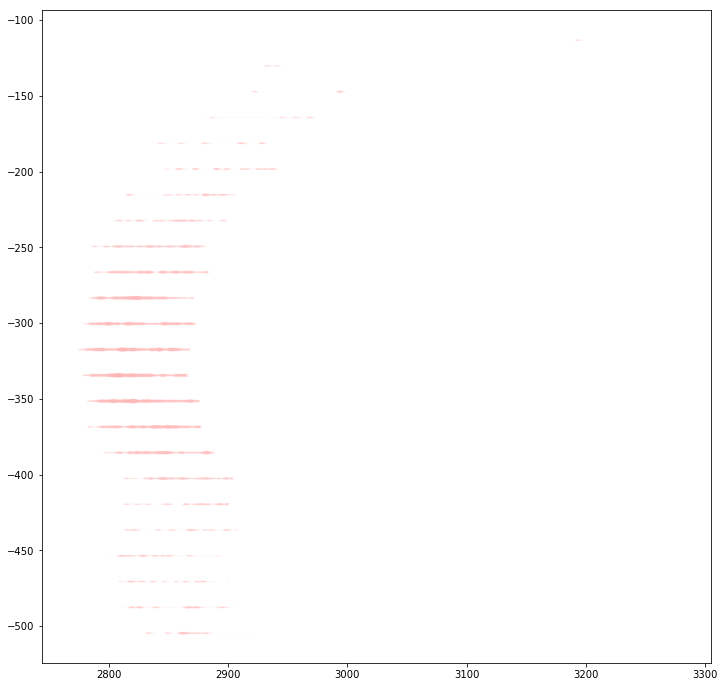

8


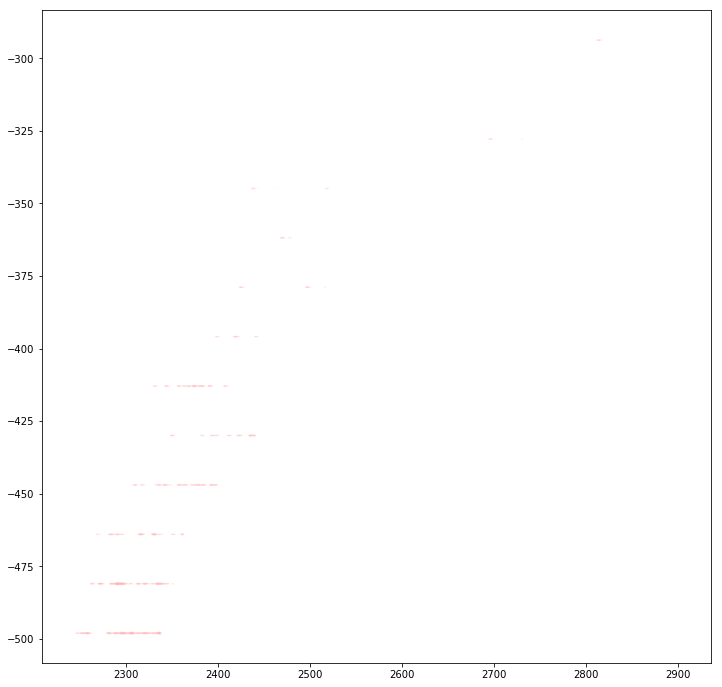

9


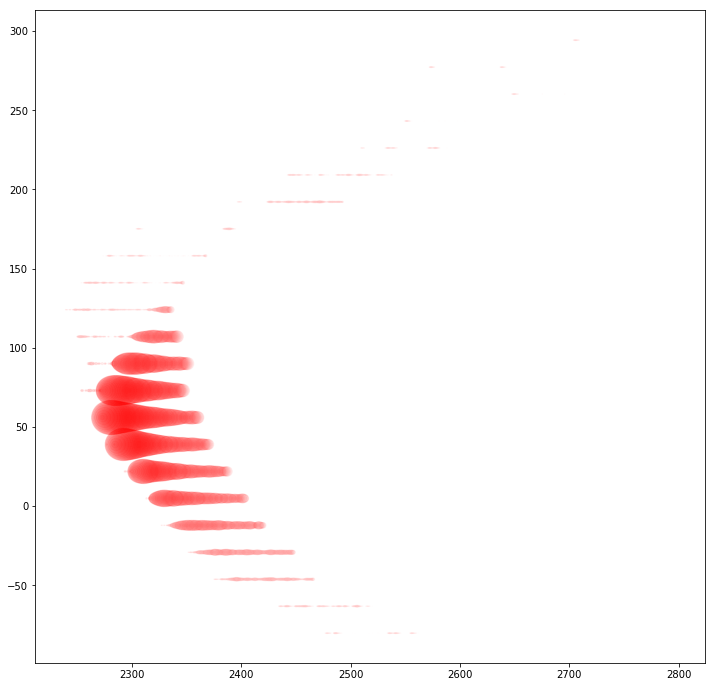

10


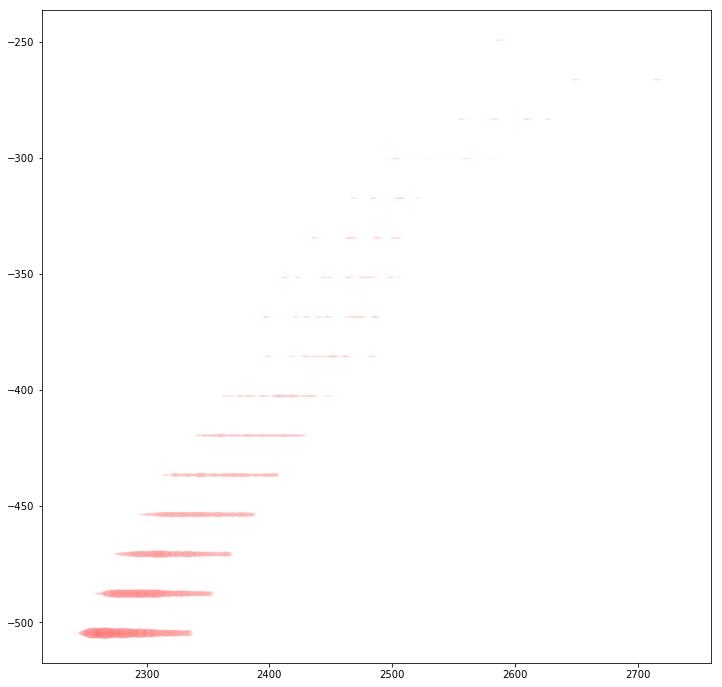

11


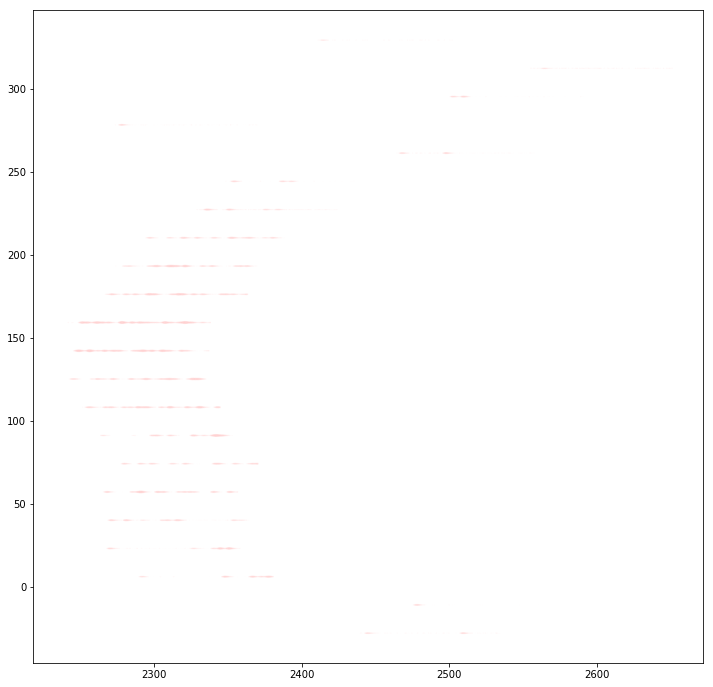

12


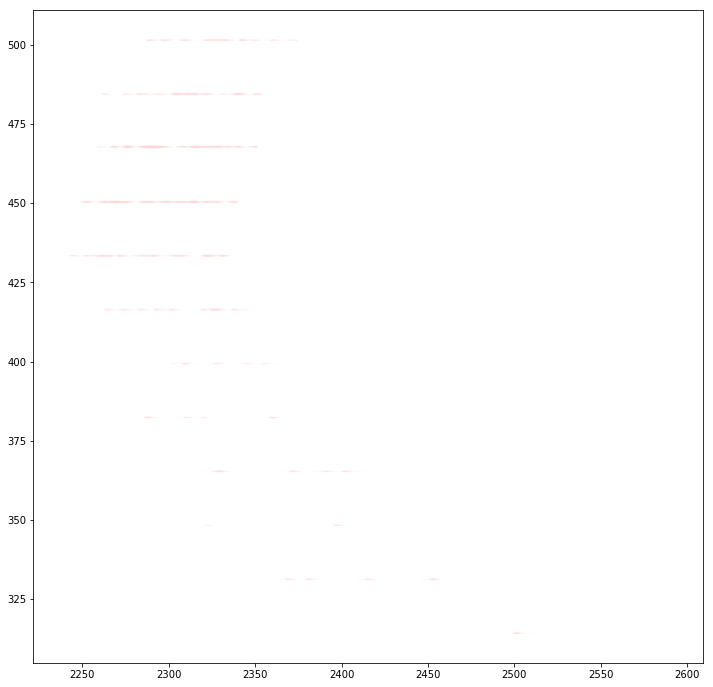

13


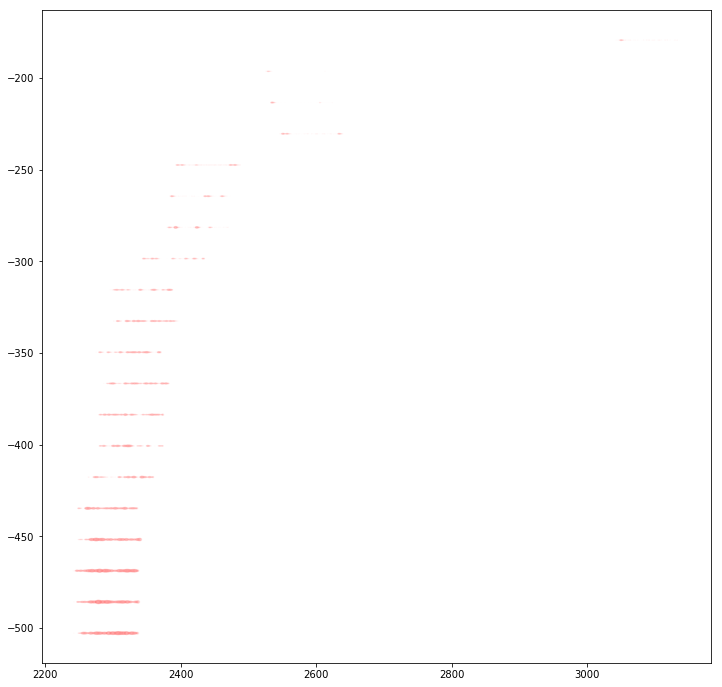

14


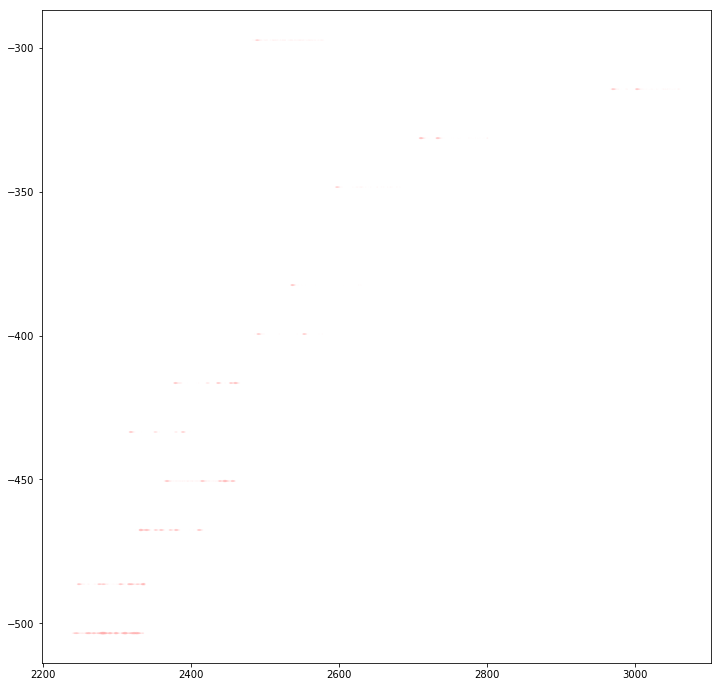

15


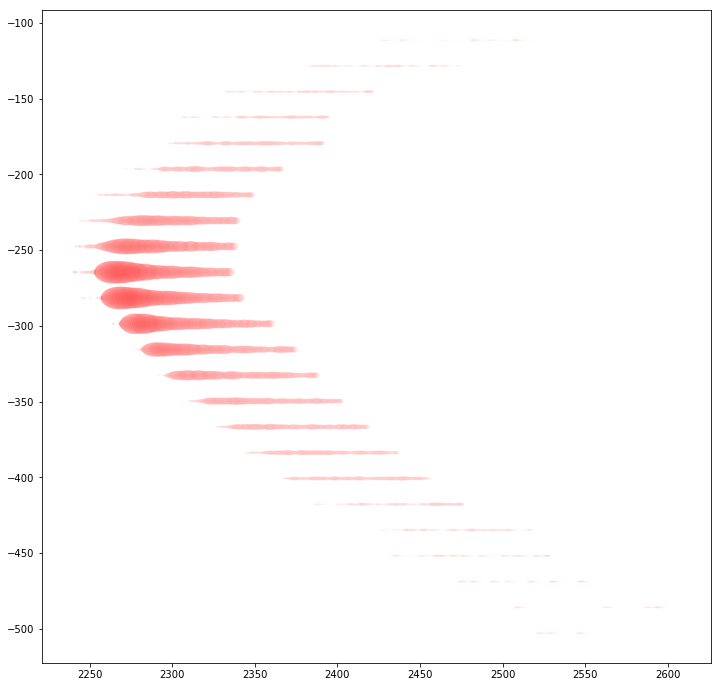

16


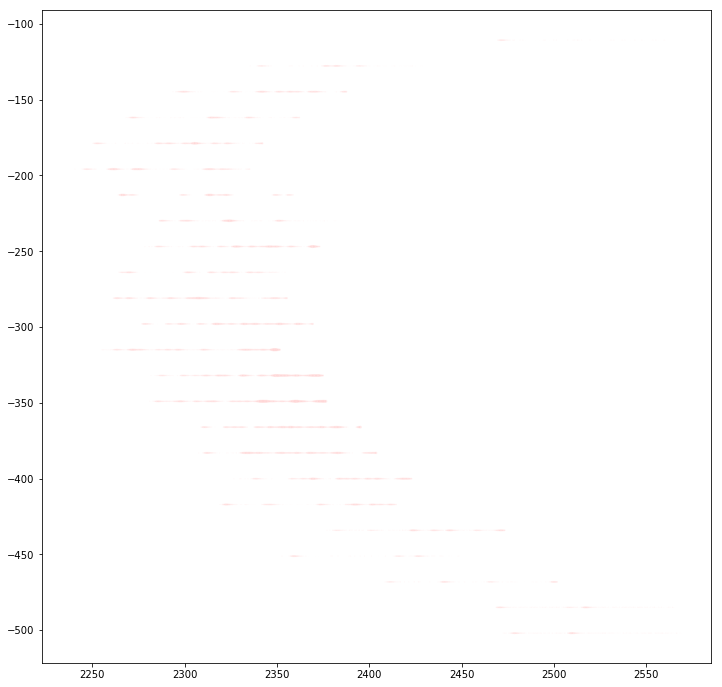

17


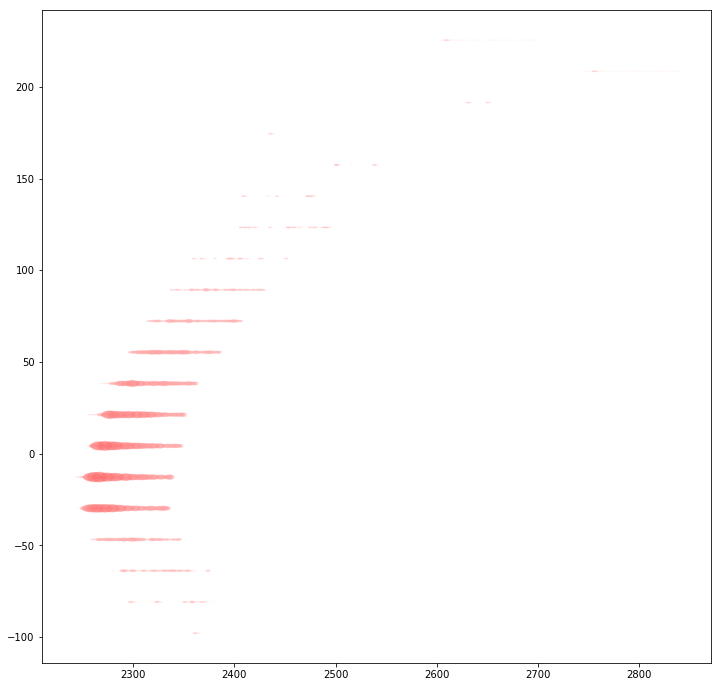

18


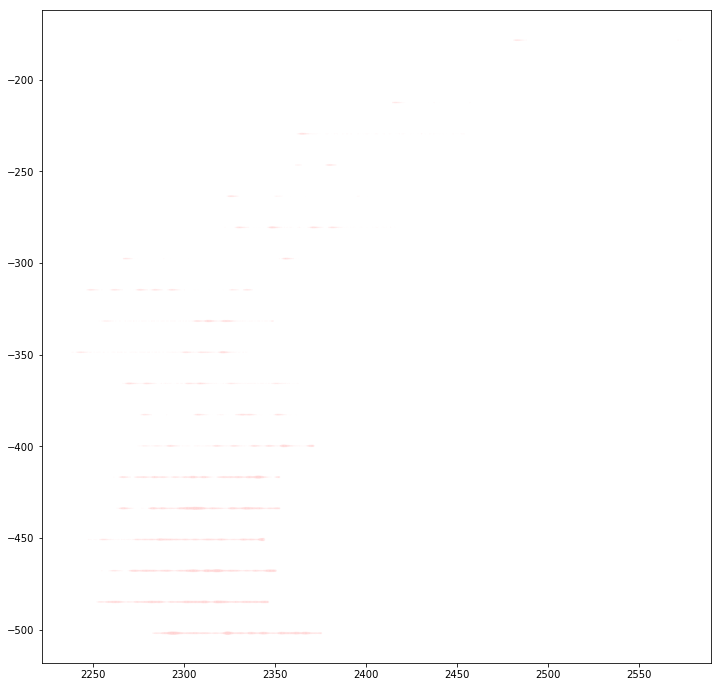

19


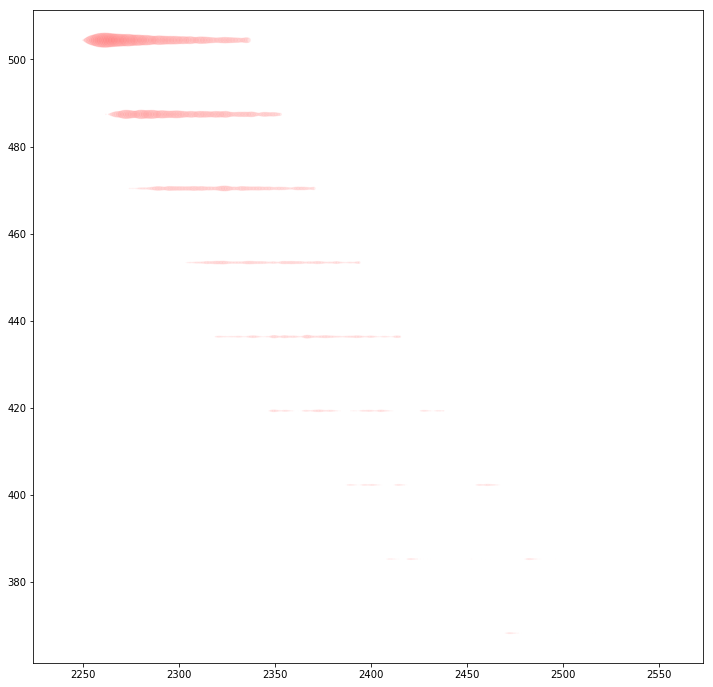

20


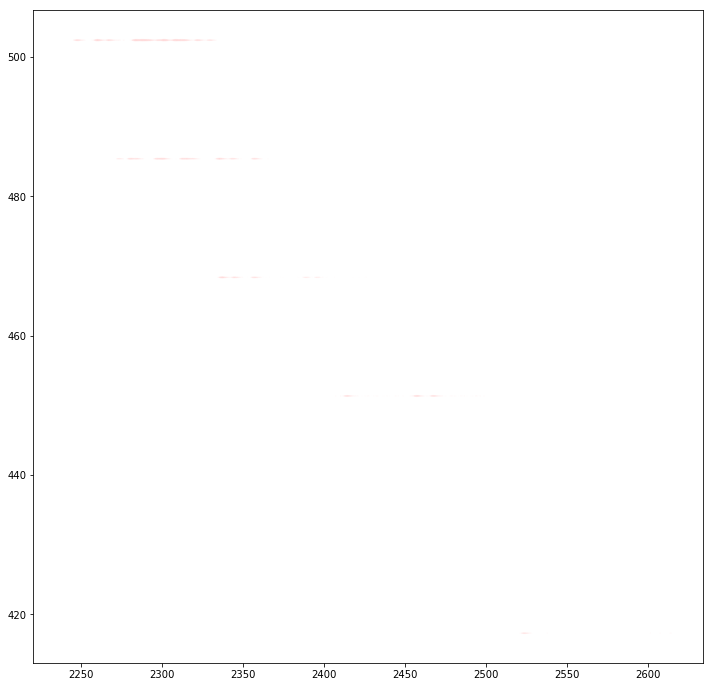

21


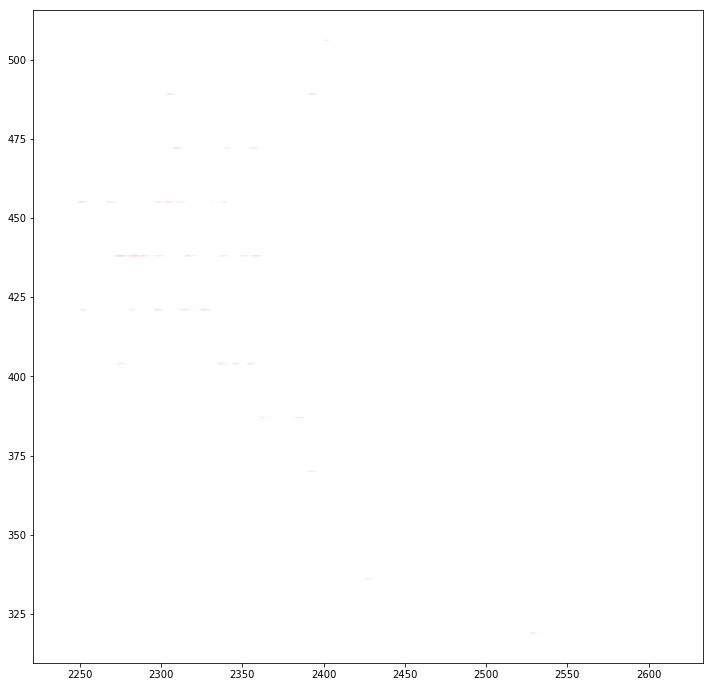

22


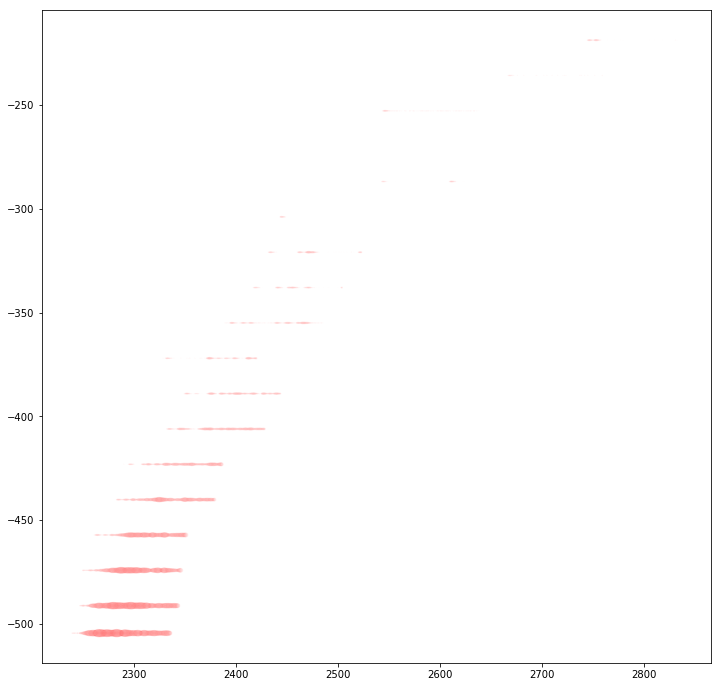

23


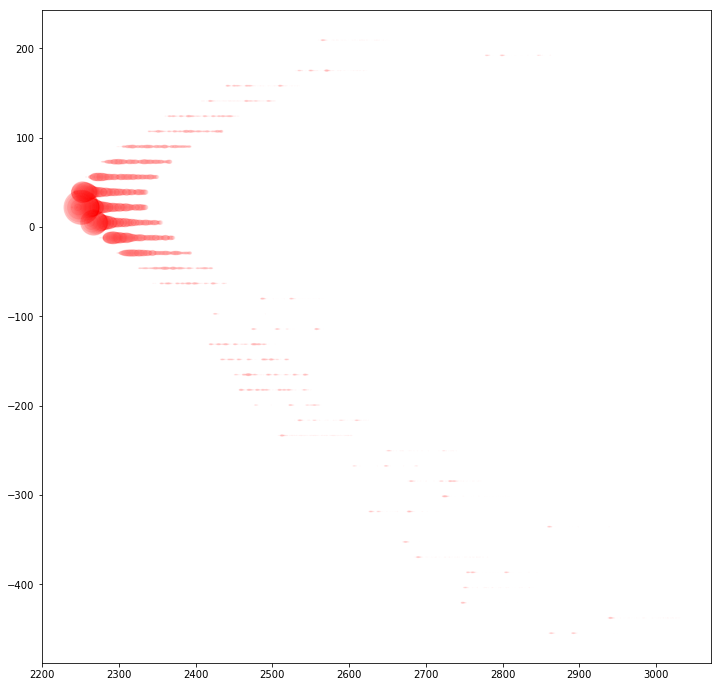

24


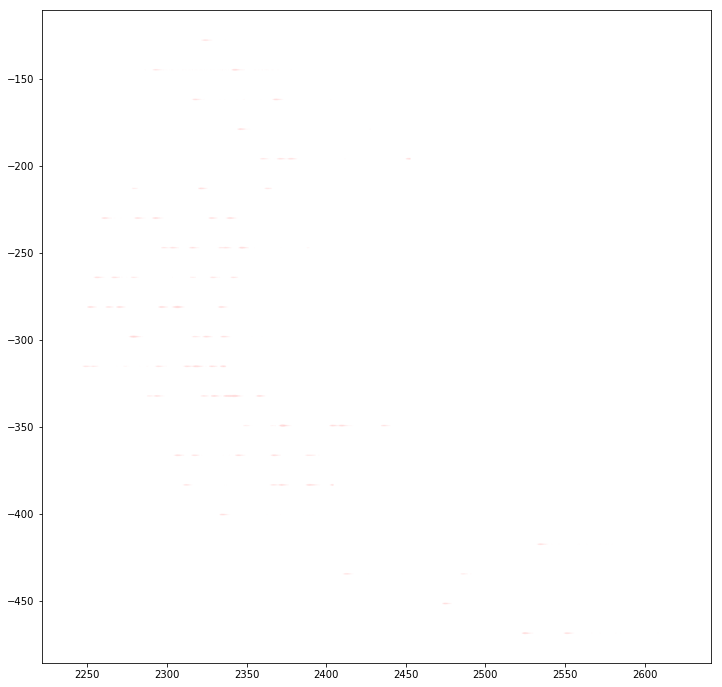

25


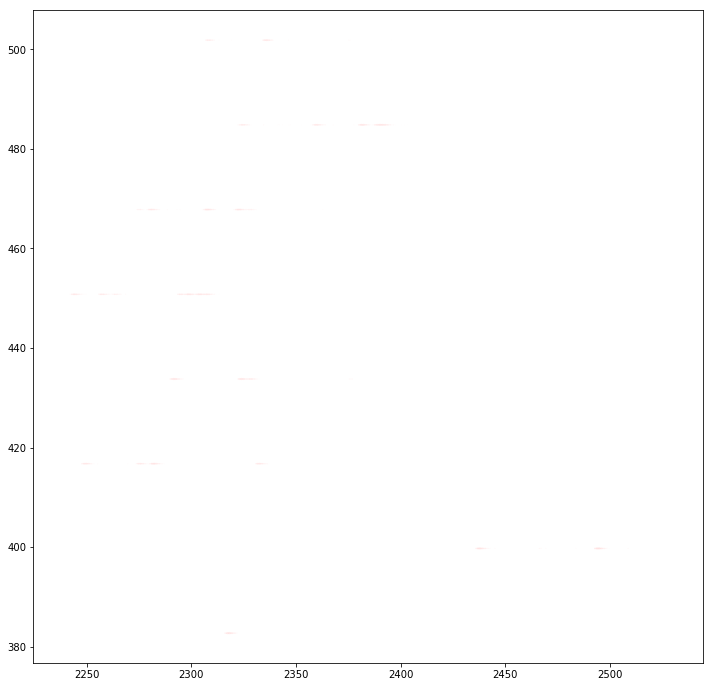

26


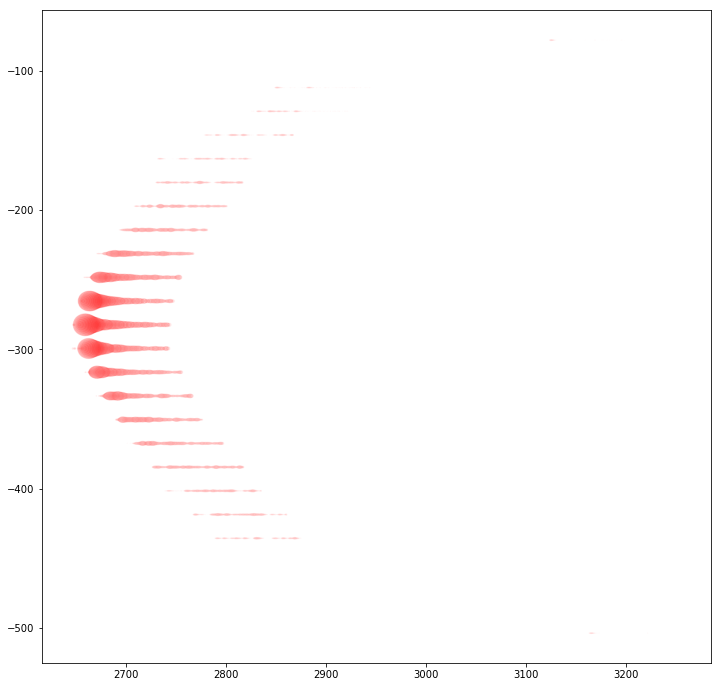

27


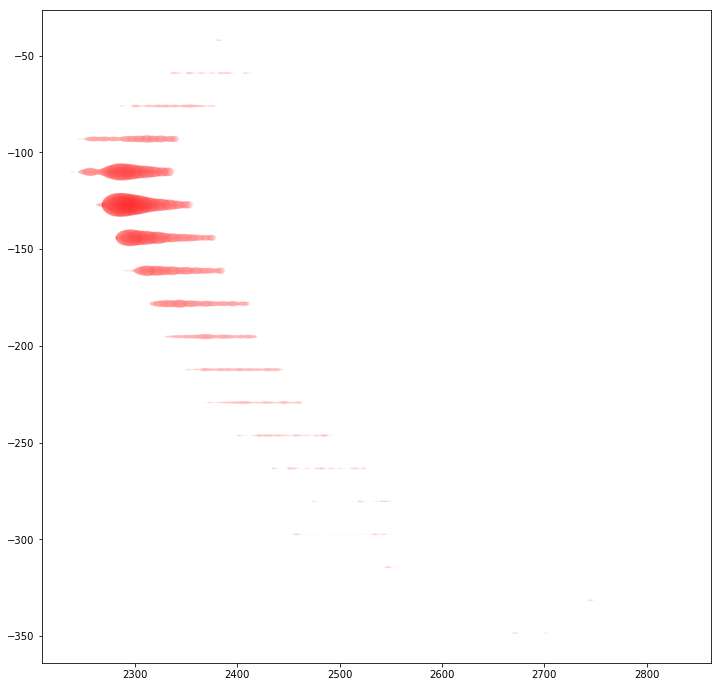

28


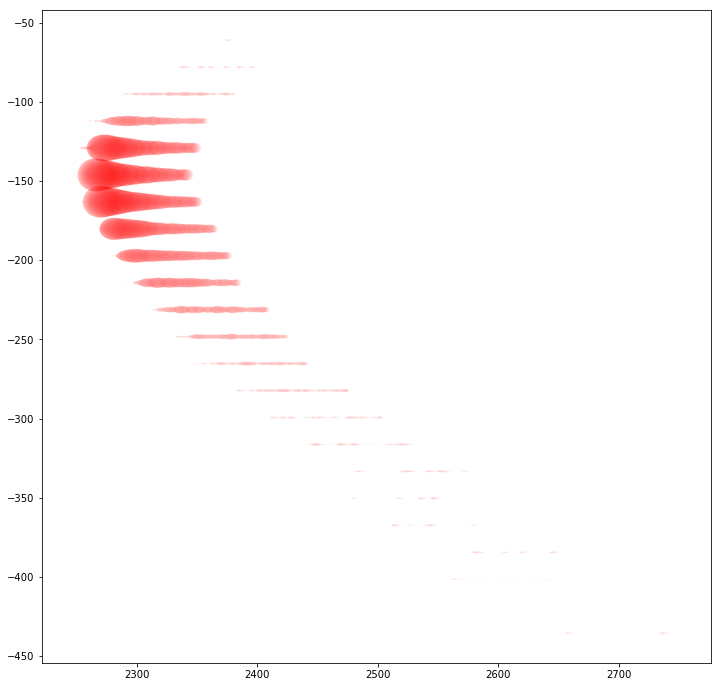

29


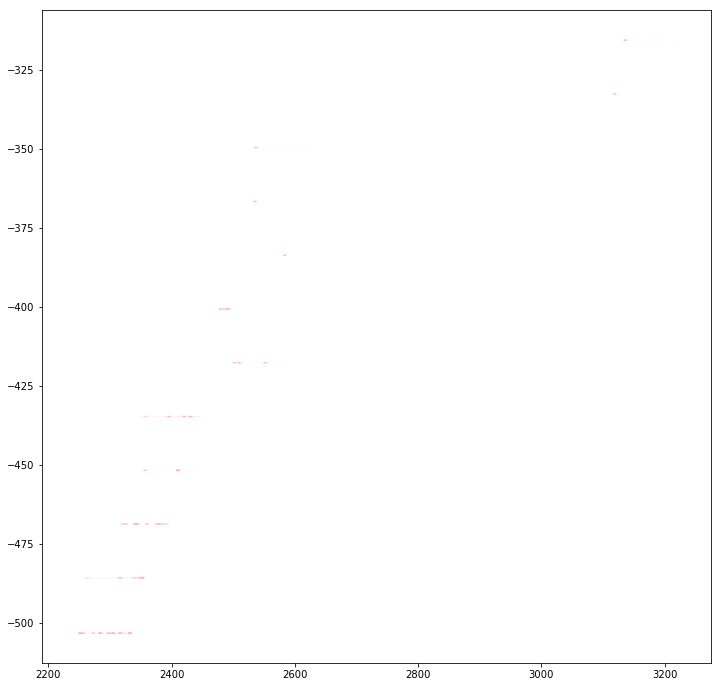

30


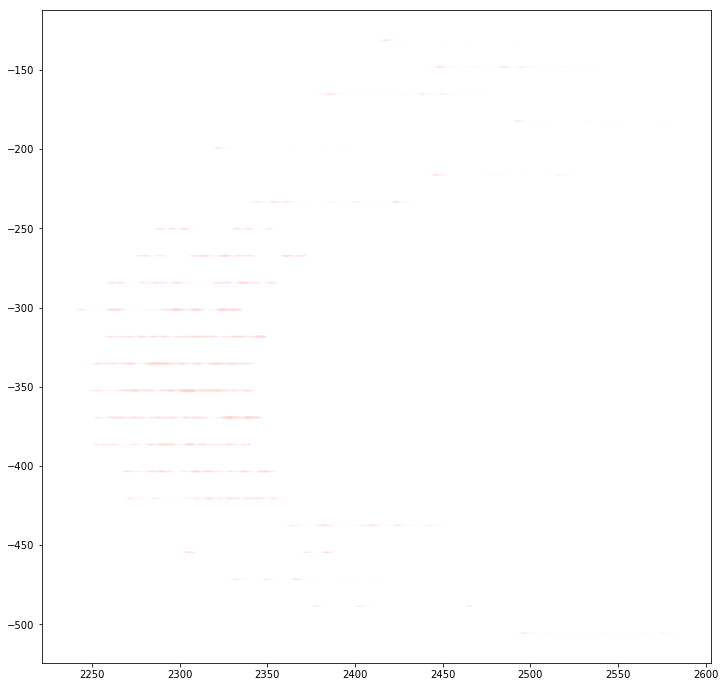

31


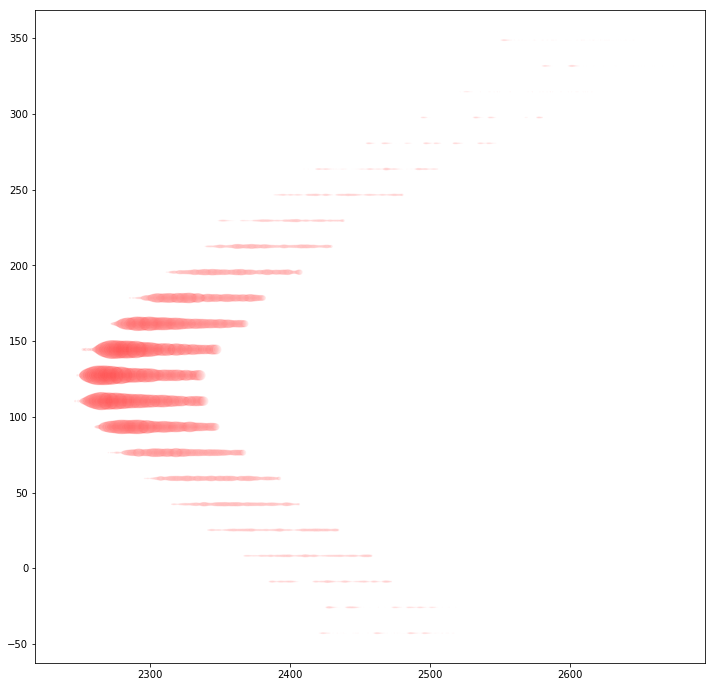

32


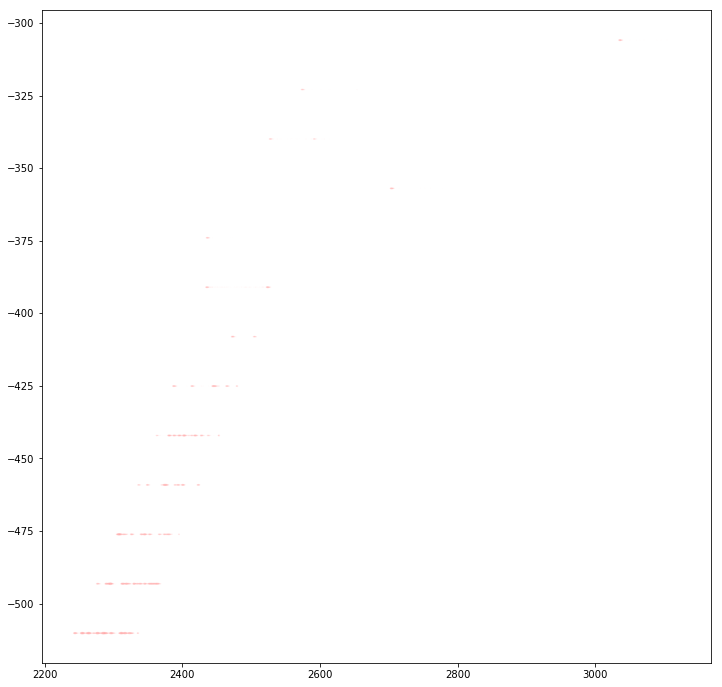

33


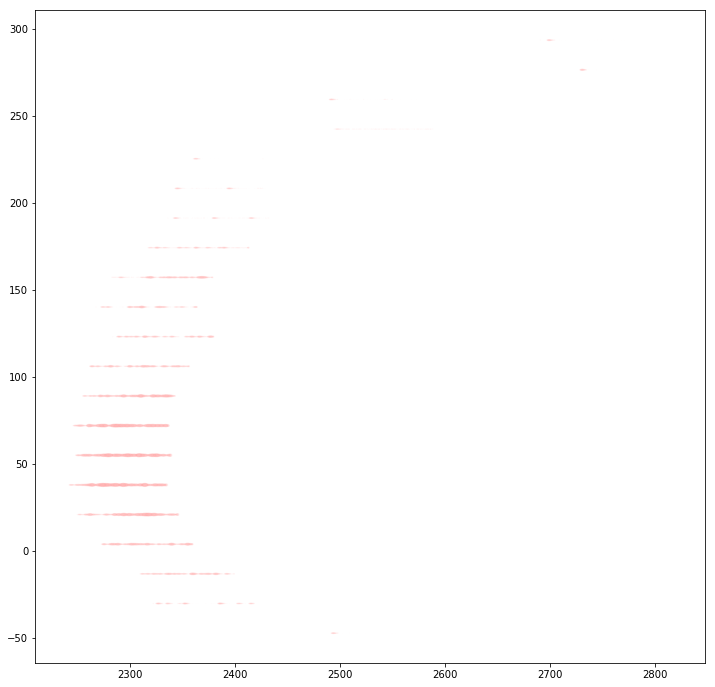

34


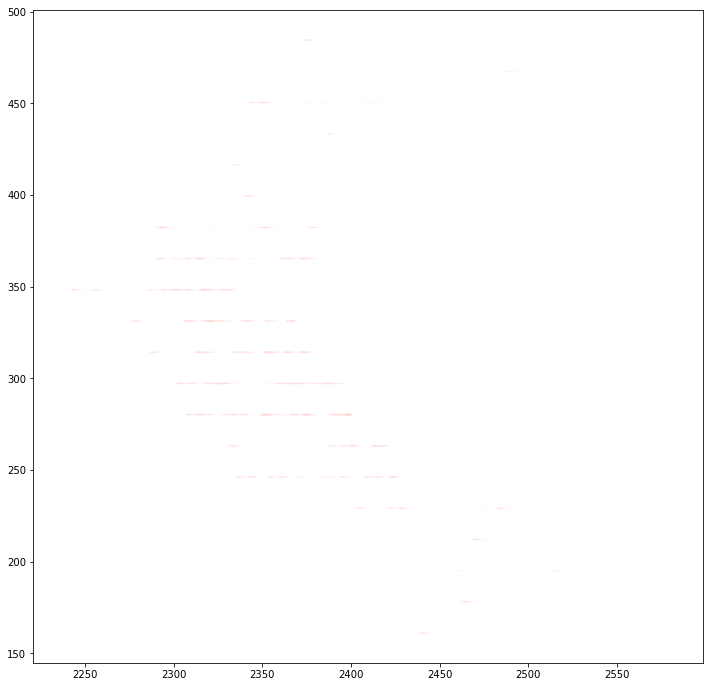

35


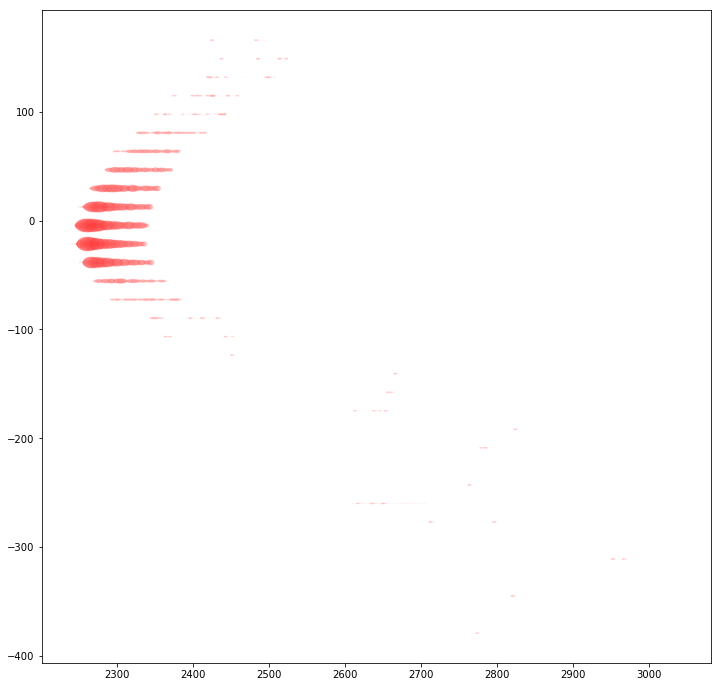

36


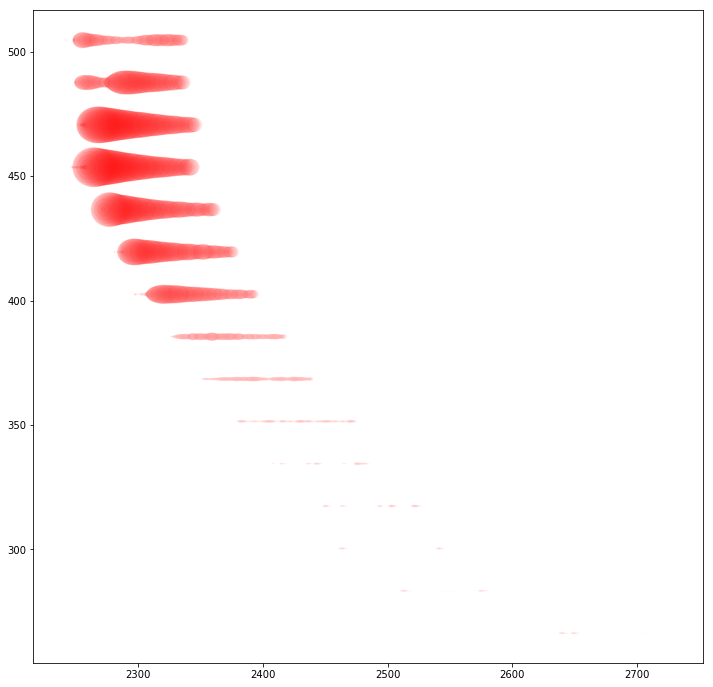

37


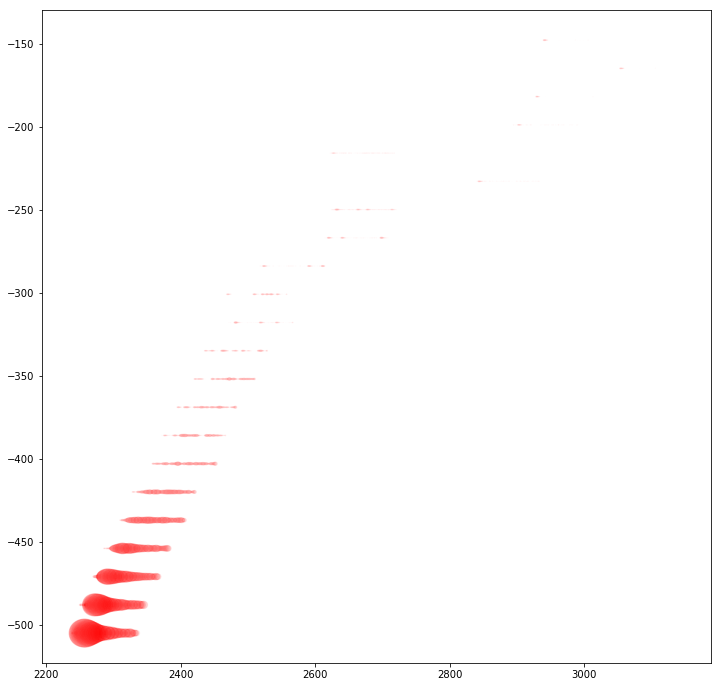

38


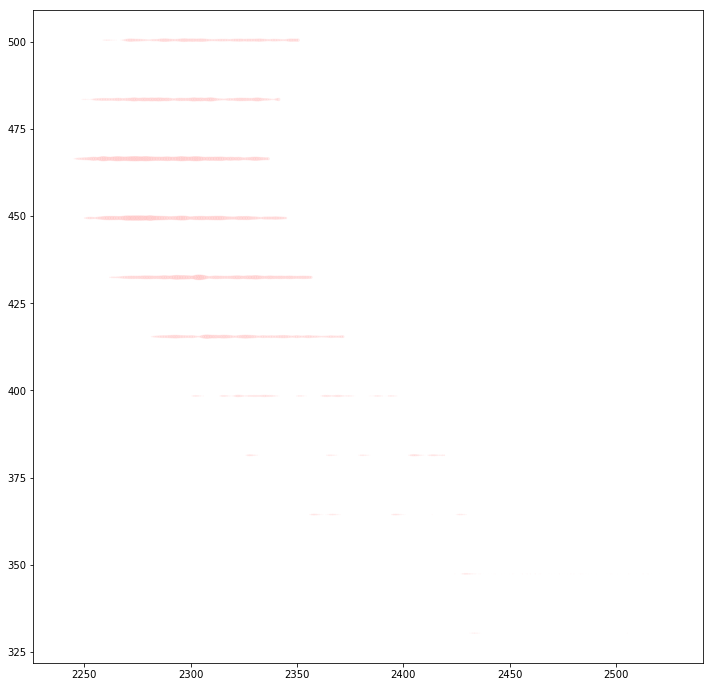

39


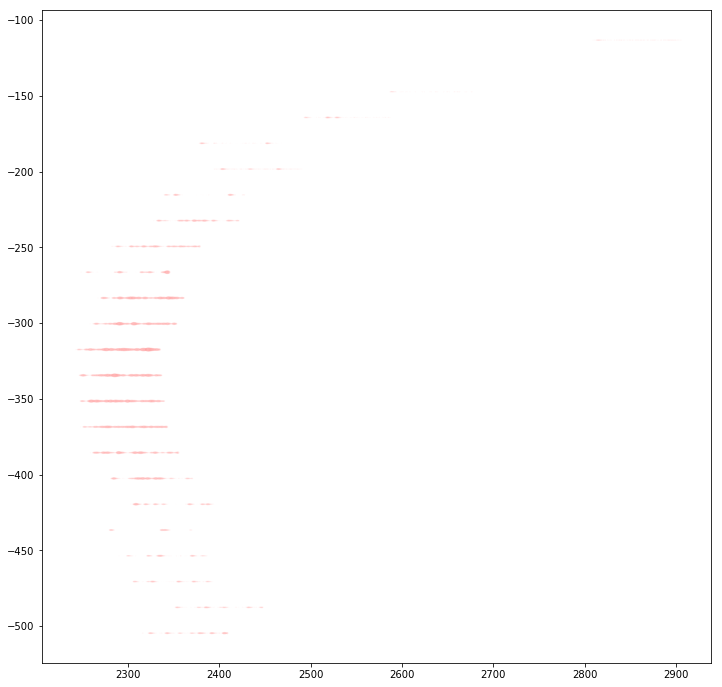

40


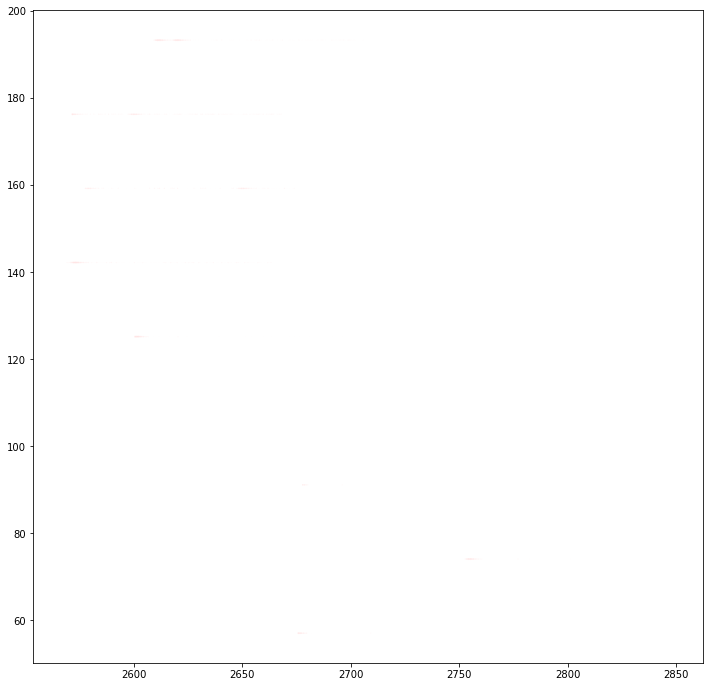

41


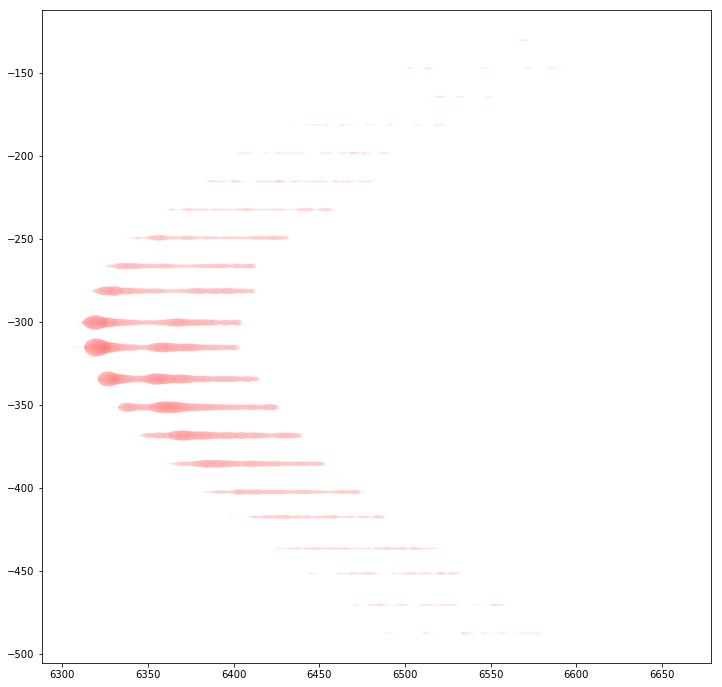

42


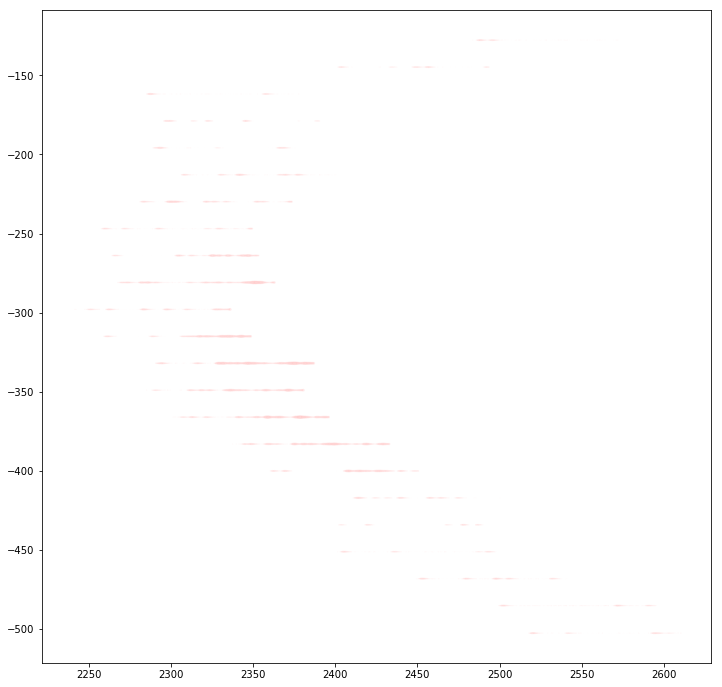

43


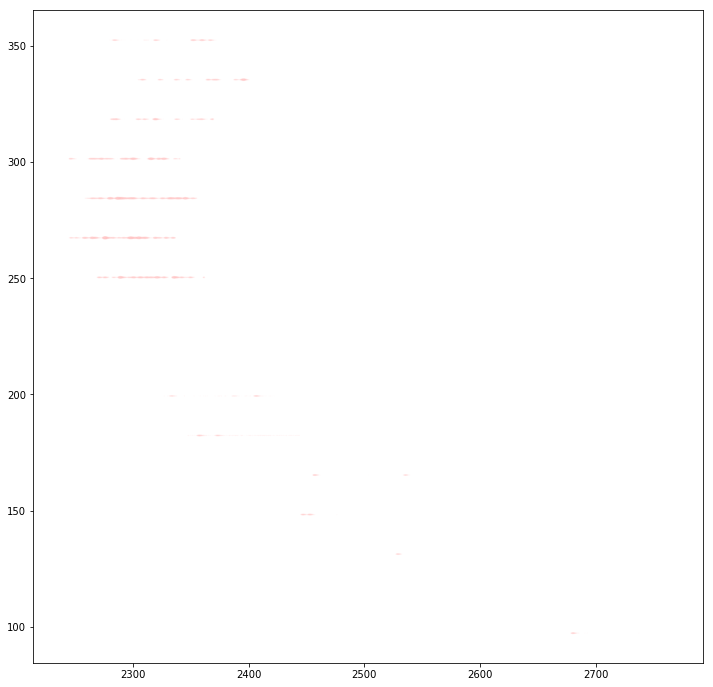

44


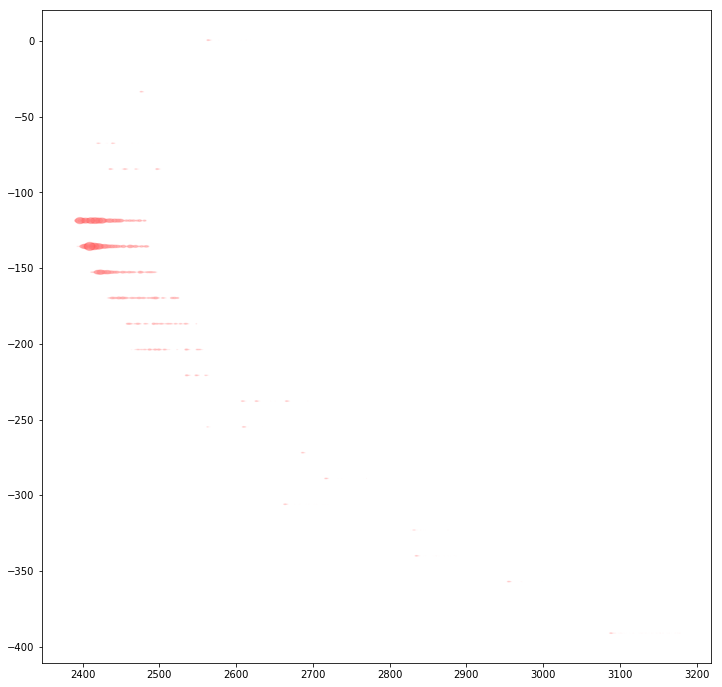

45


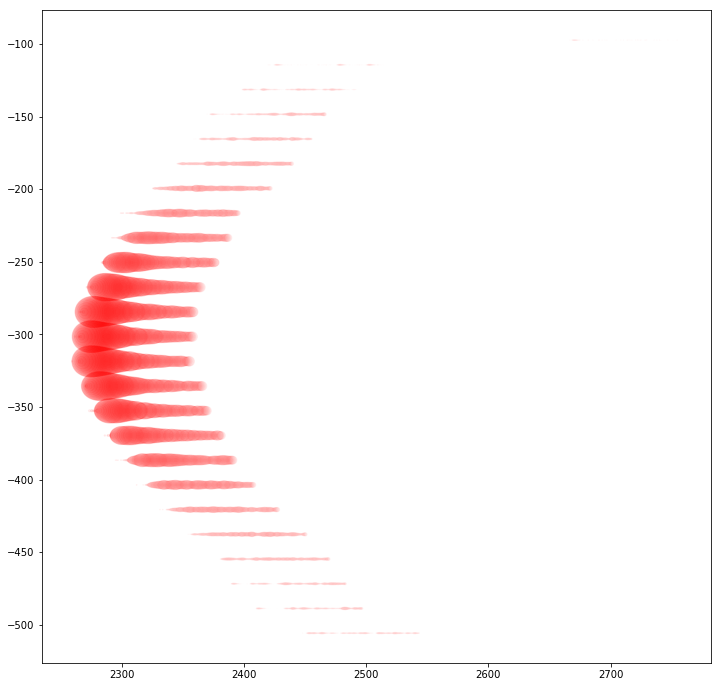

46


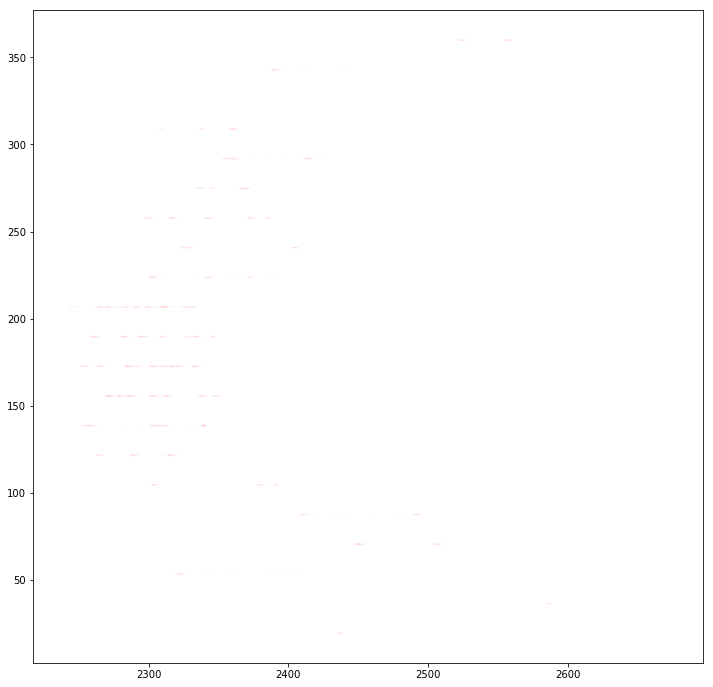

47


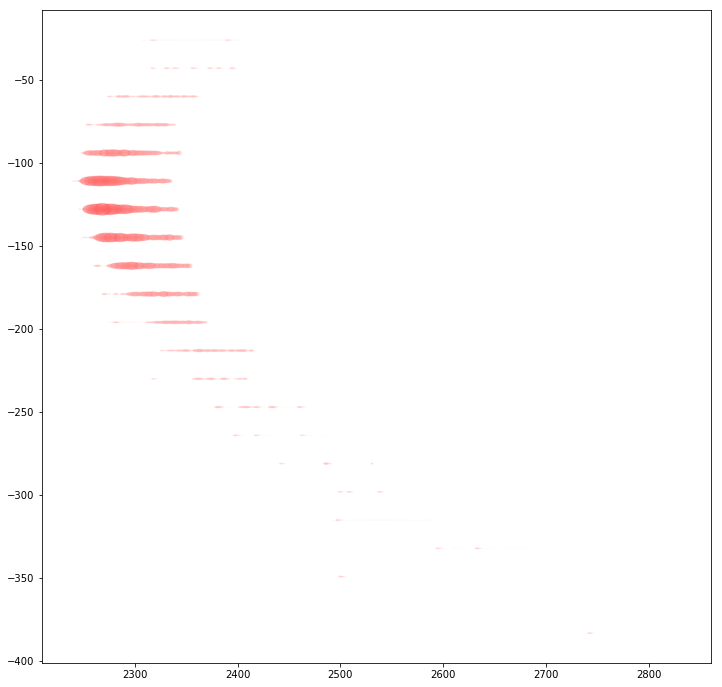

48


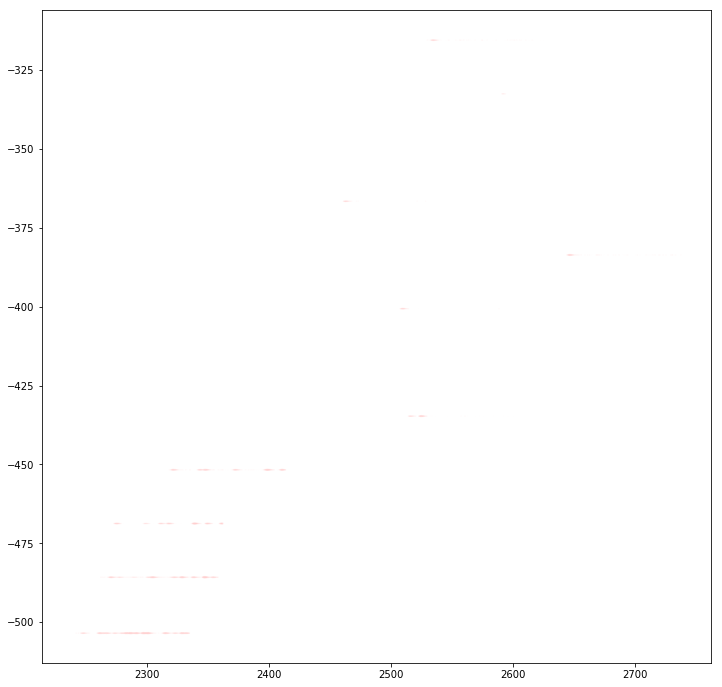

49


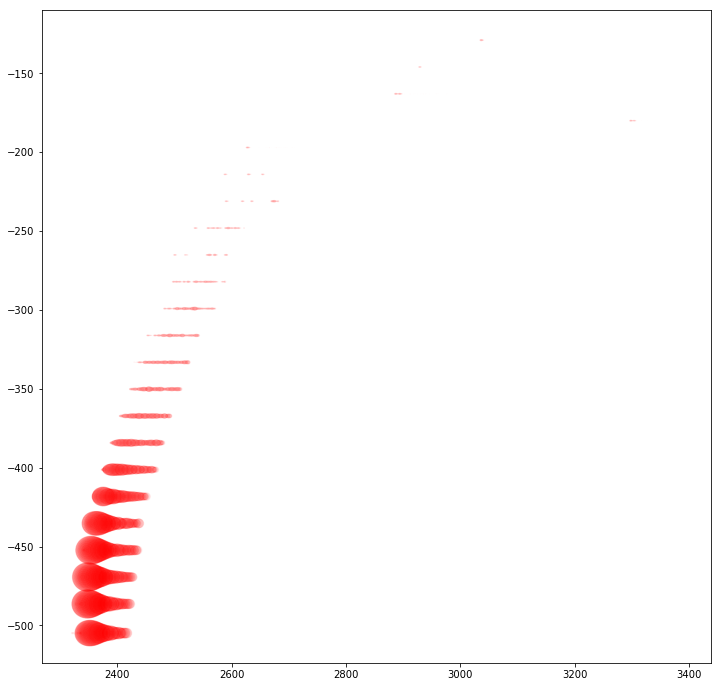

50


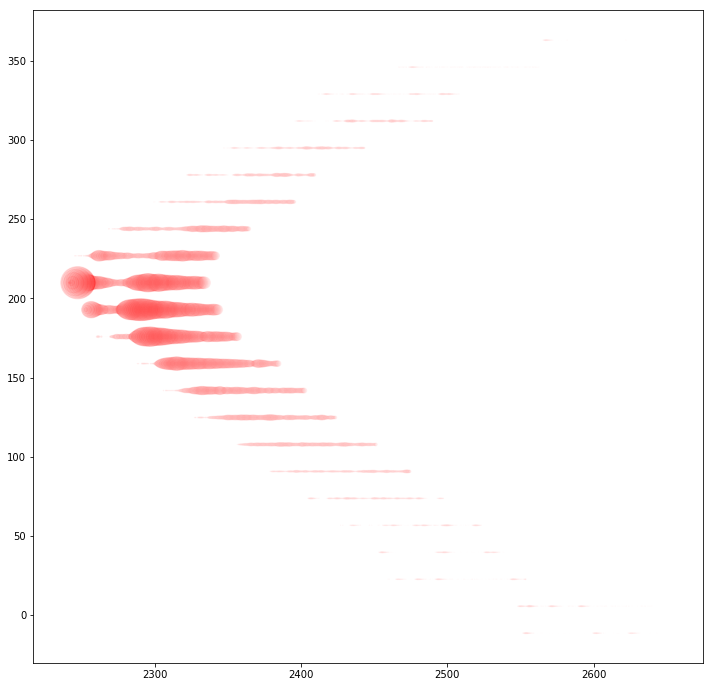

51


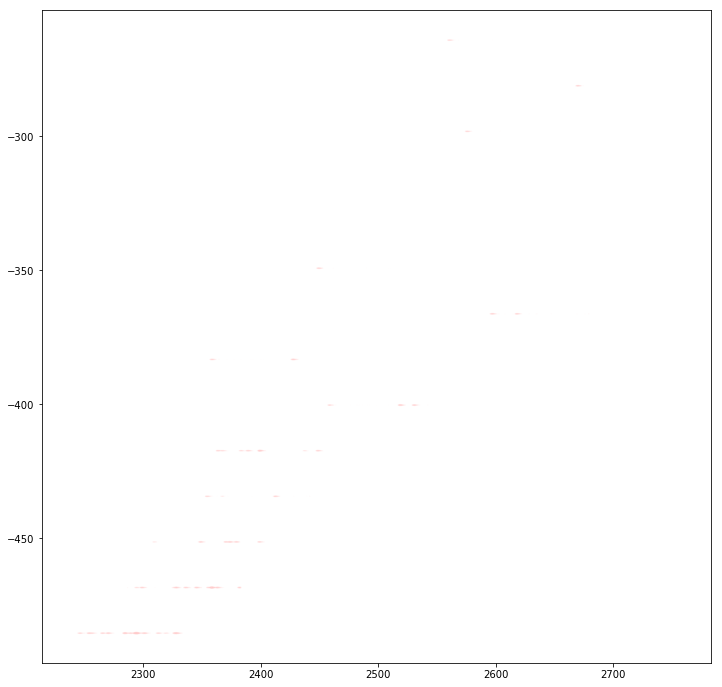

52


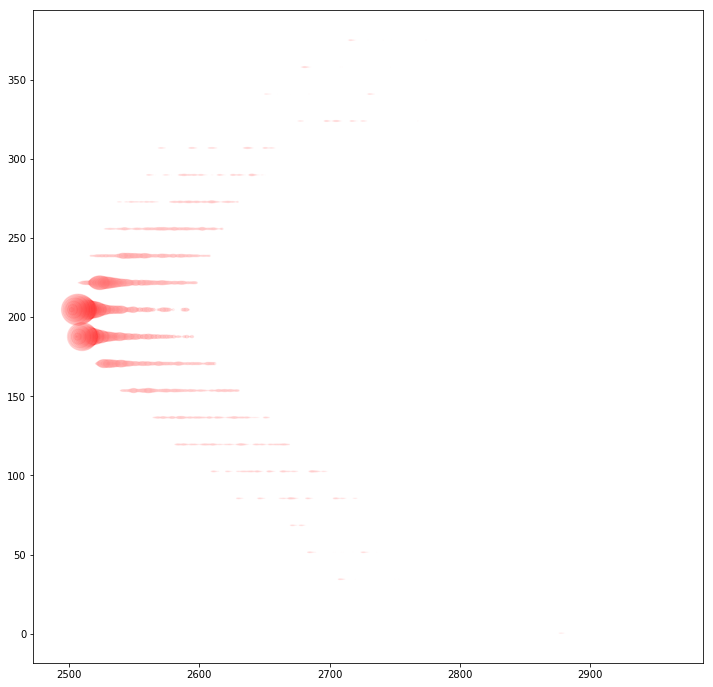

53


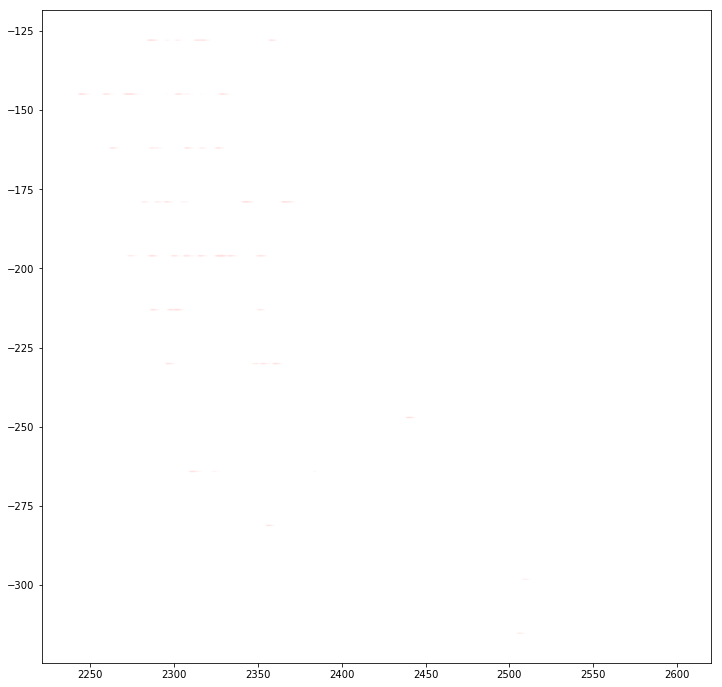

54


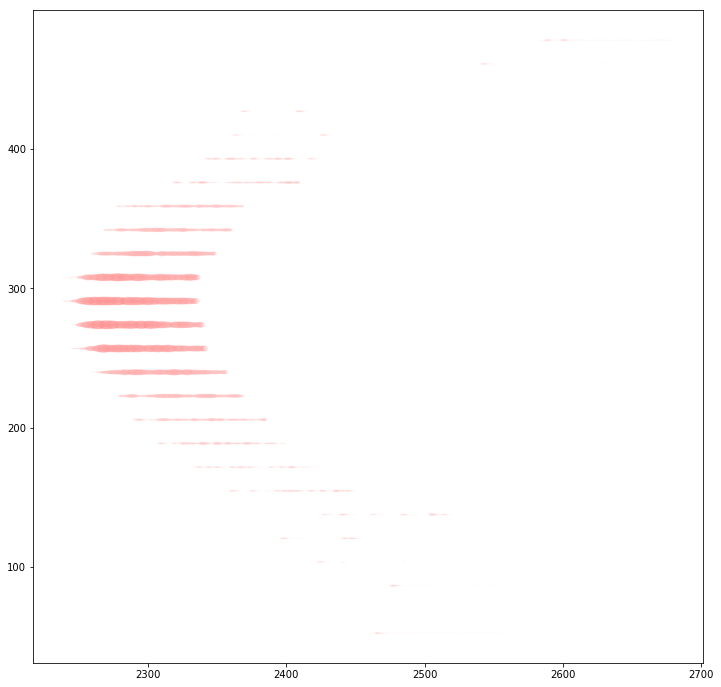

55


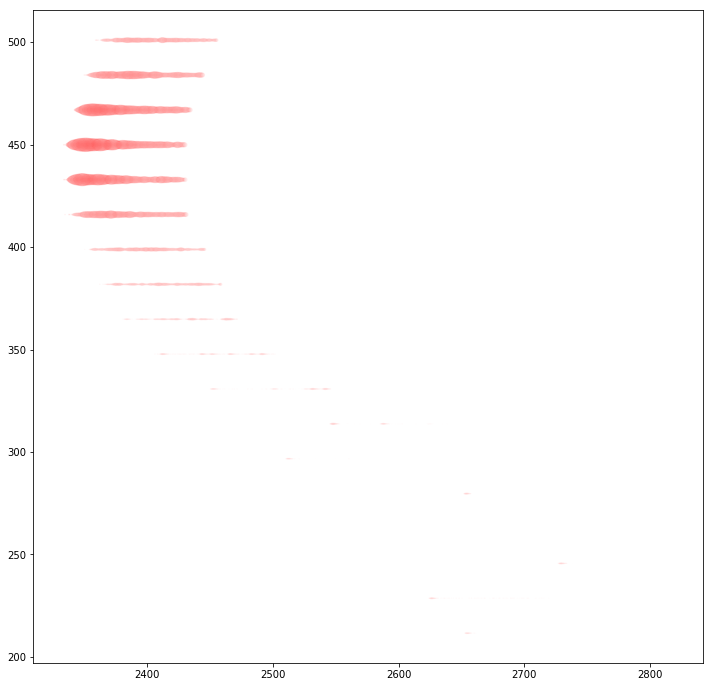

56


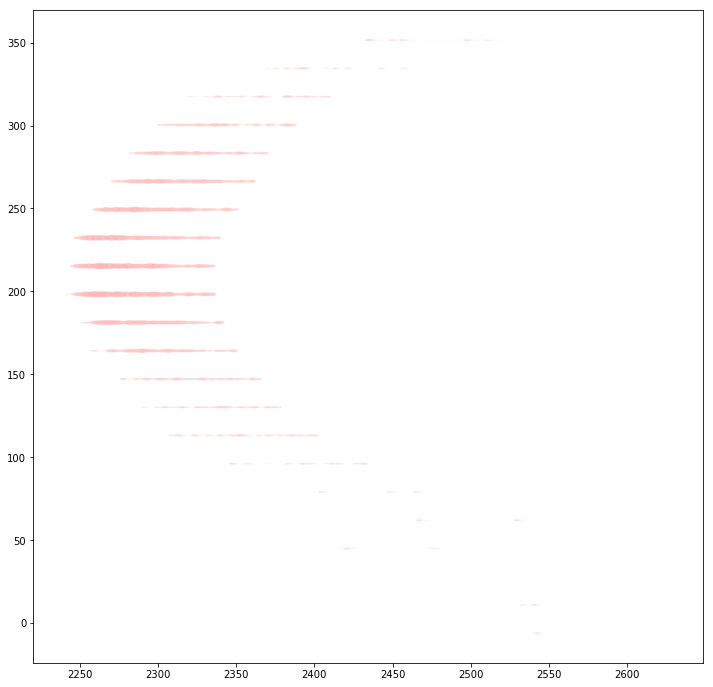

57


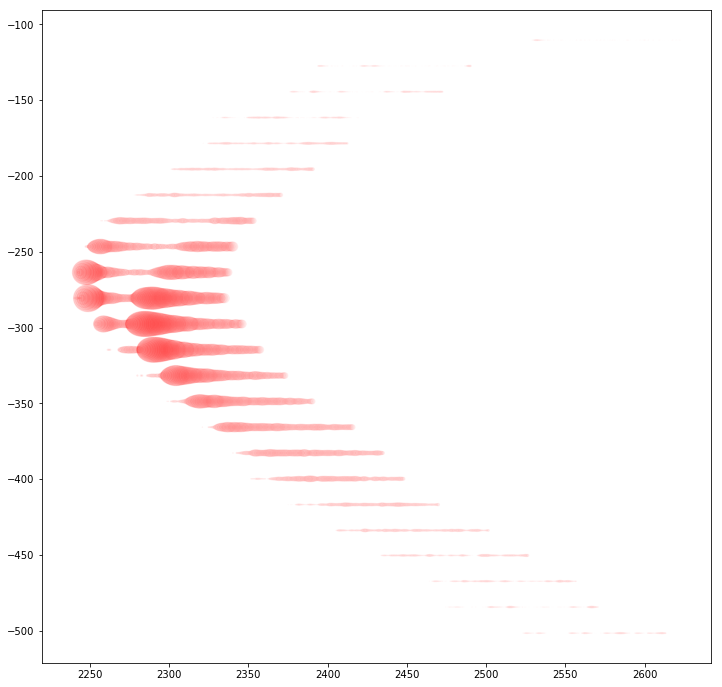

58


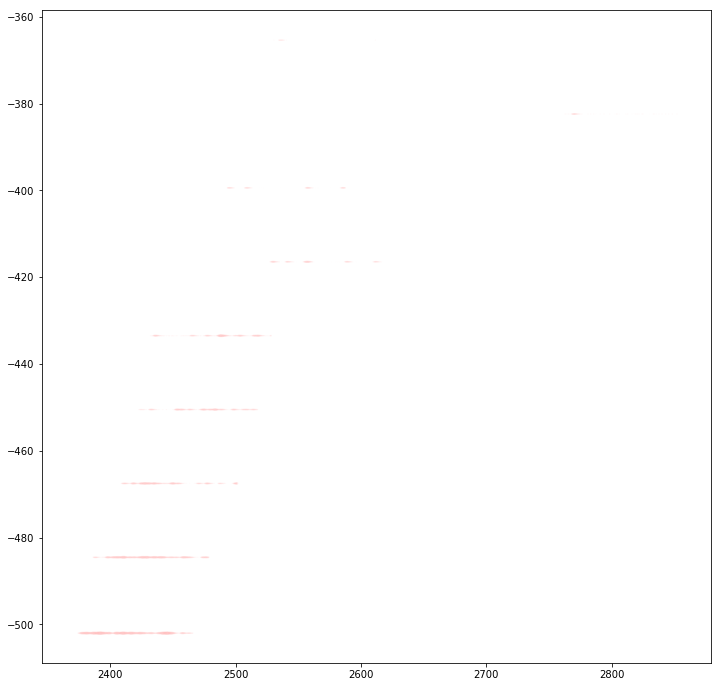

59


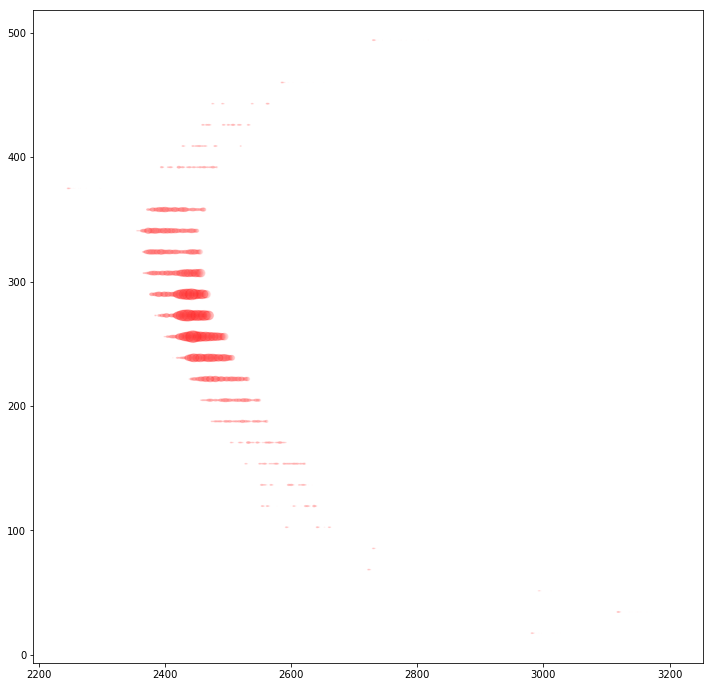

60


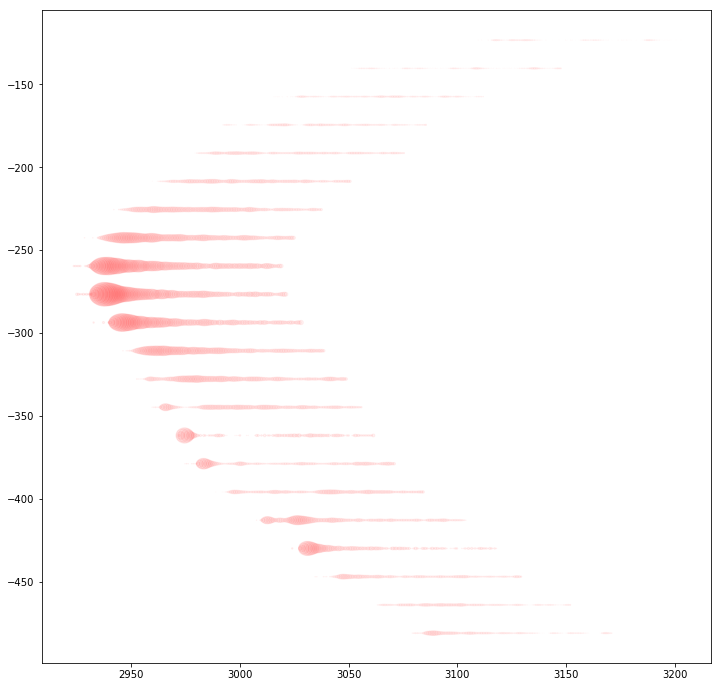

61


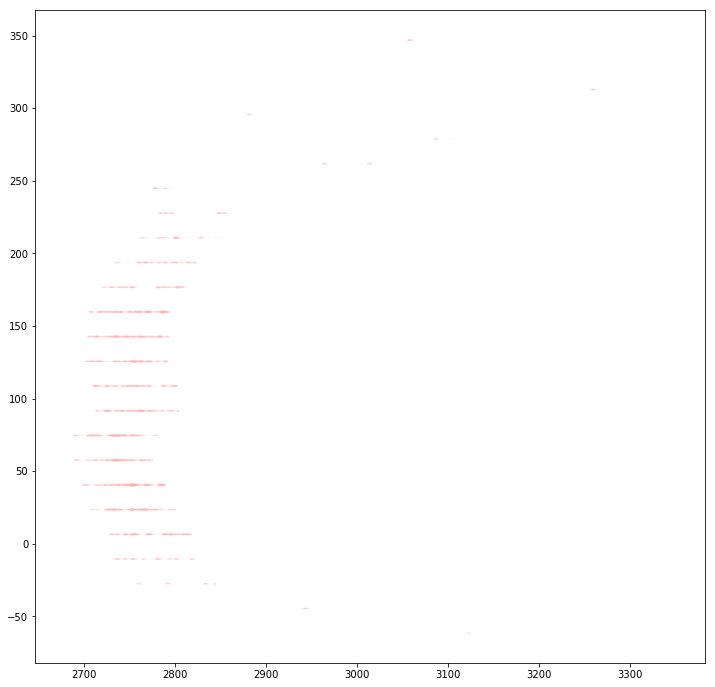

62


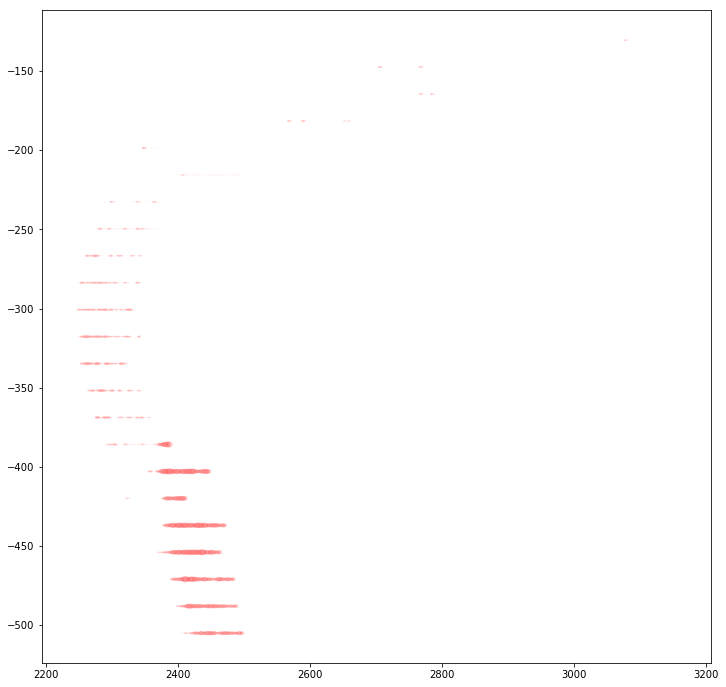

63


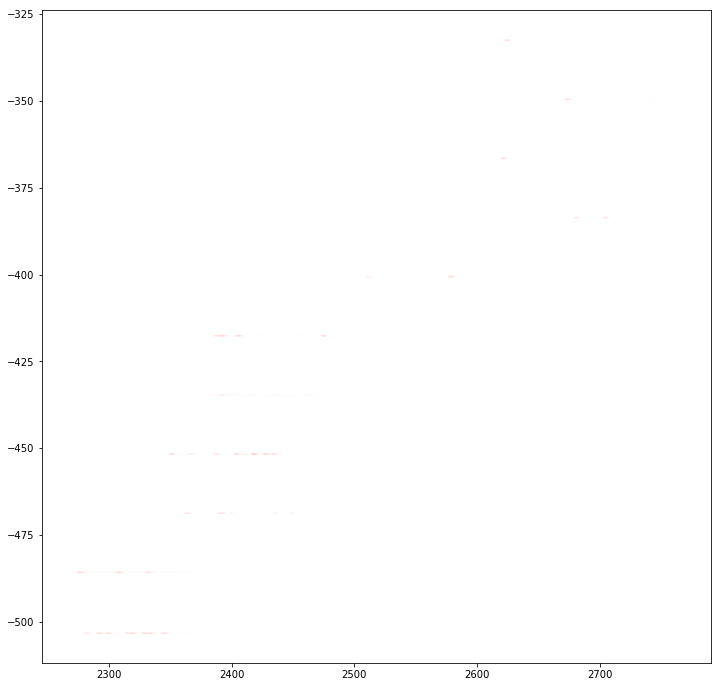

64


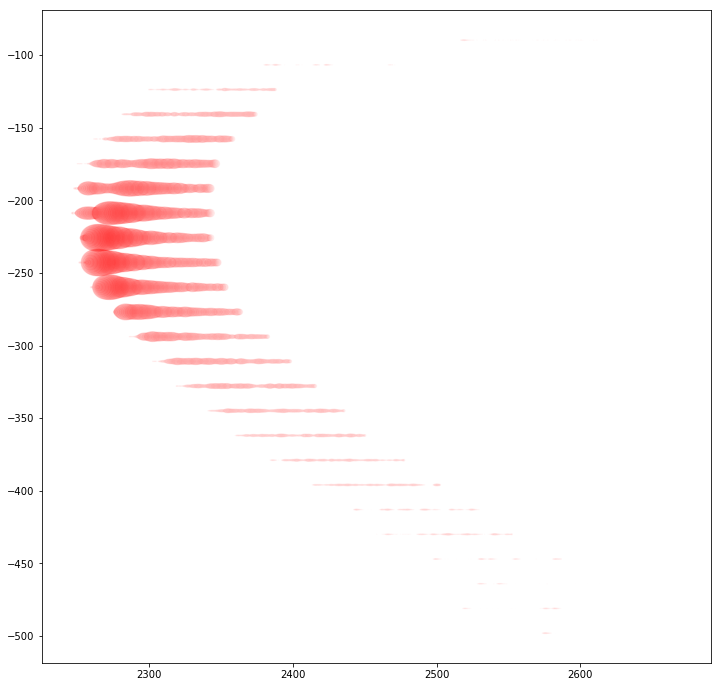

65


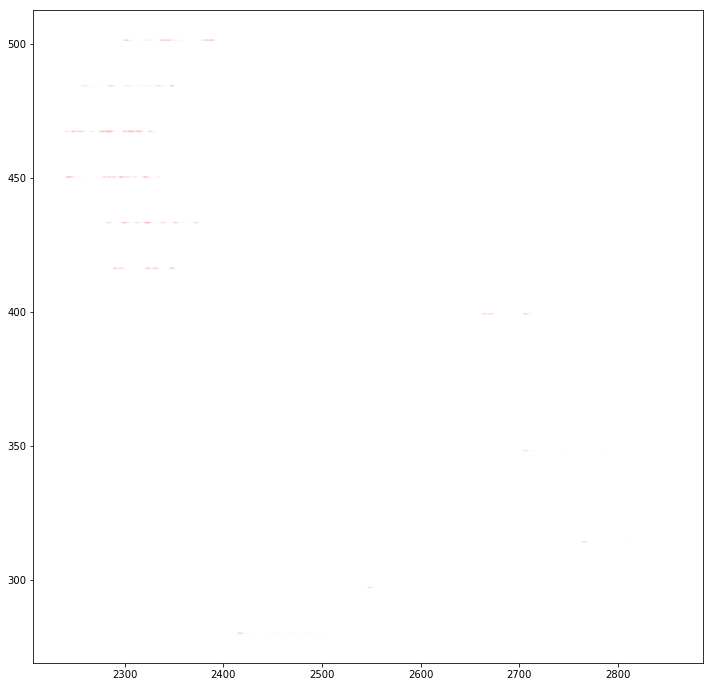

66


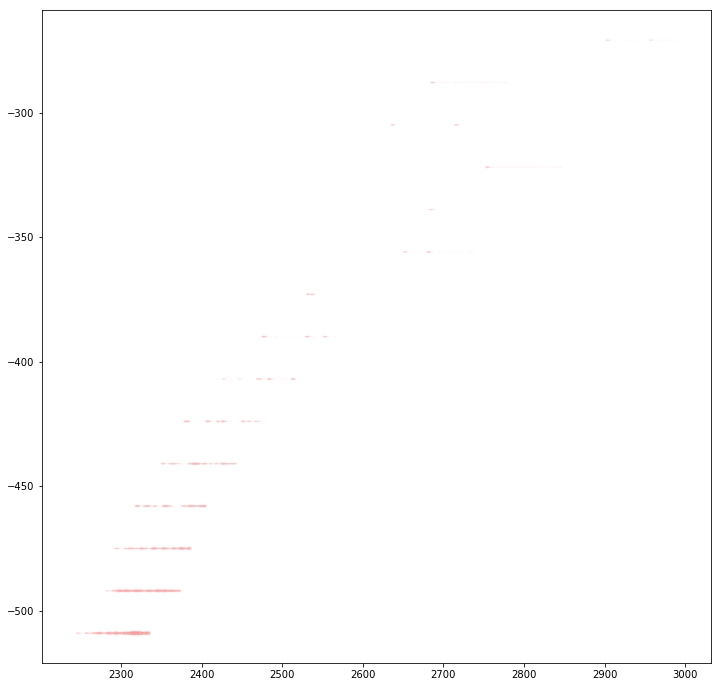

67


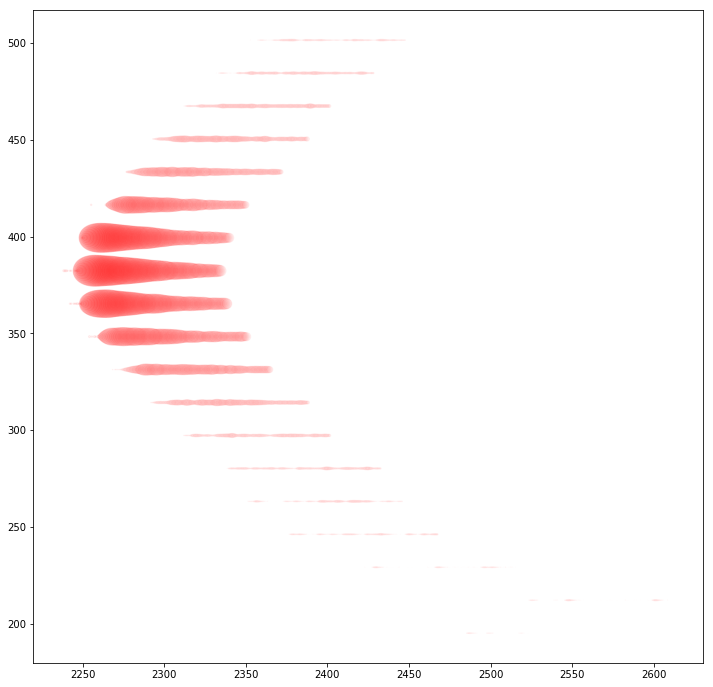

68


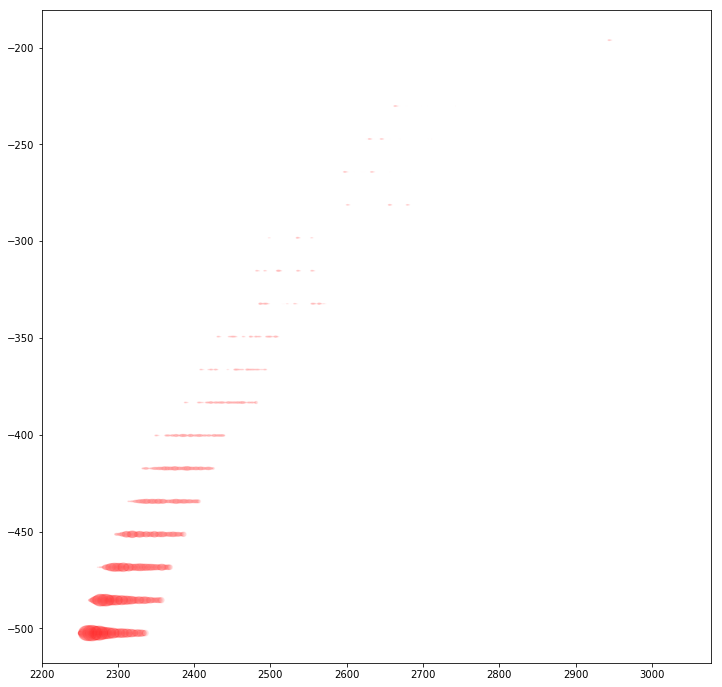

69


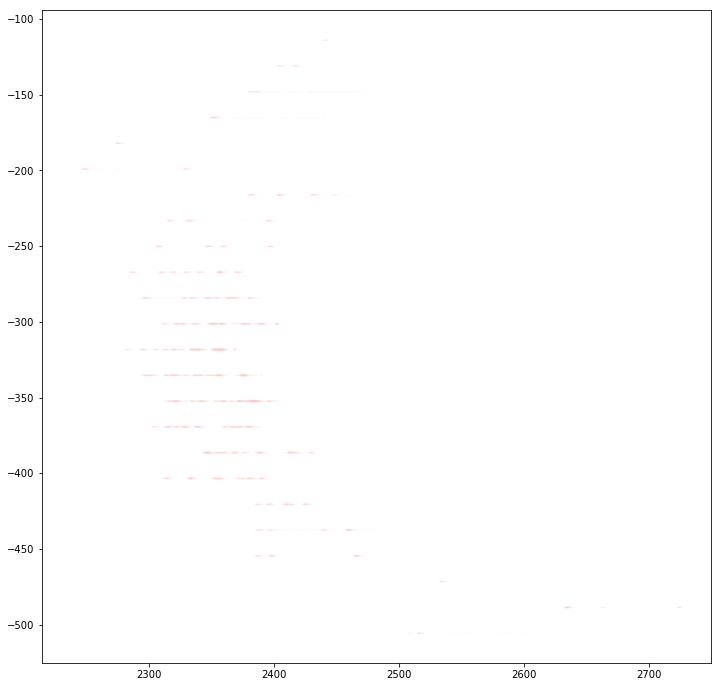

70


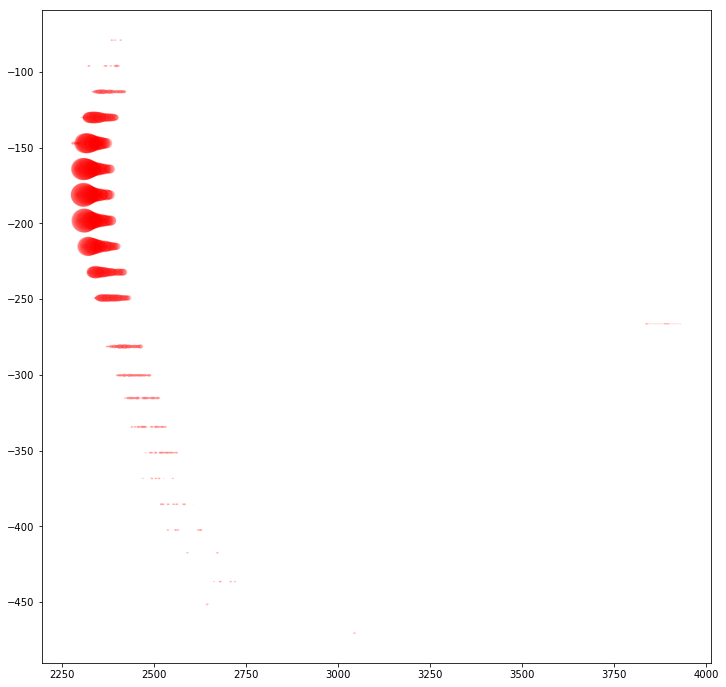

71


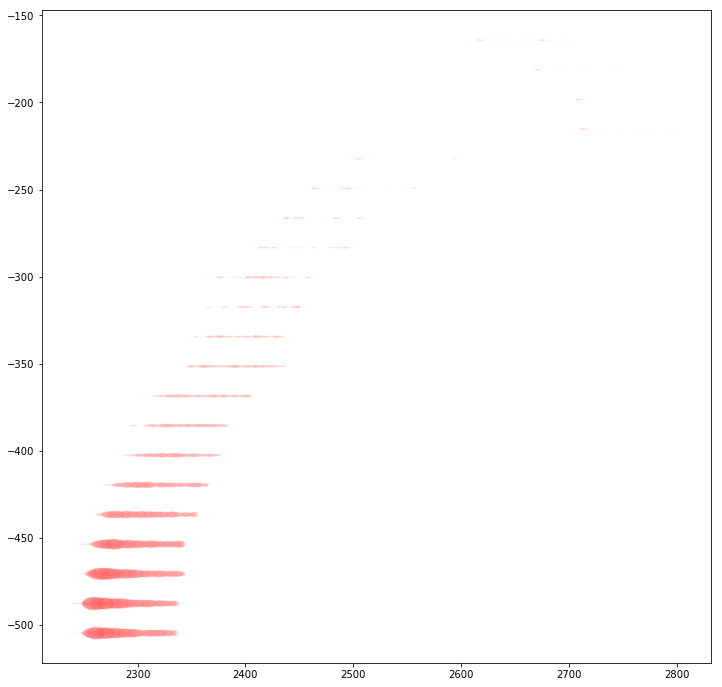

72


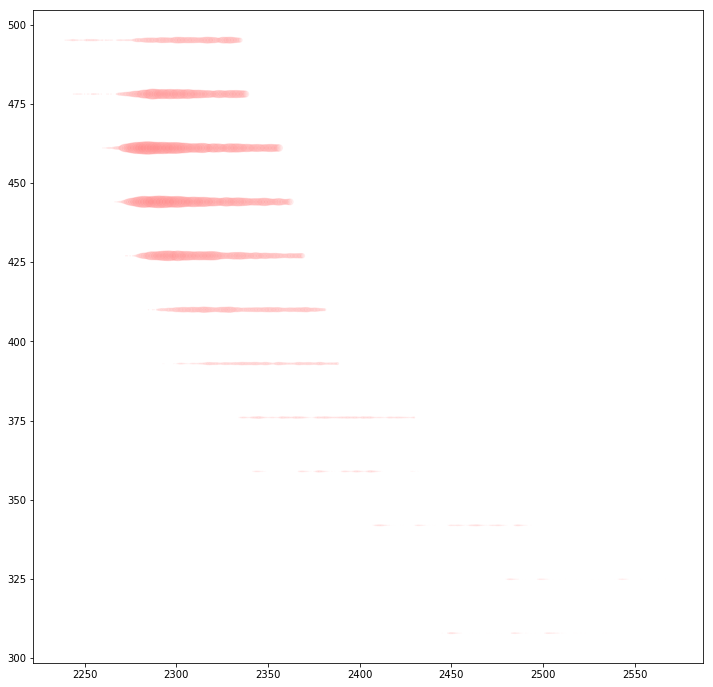

73


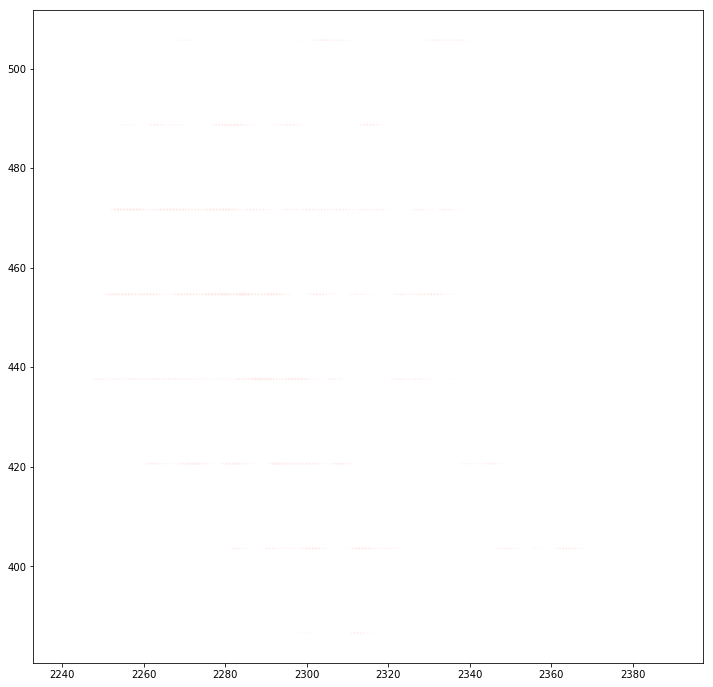

74


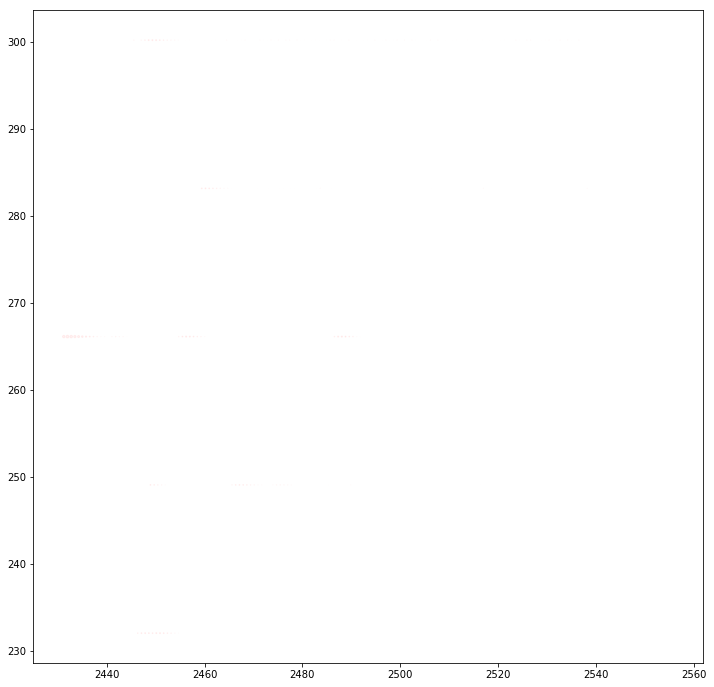

75


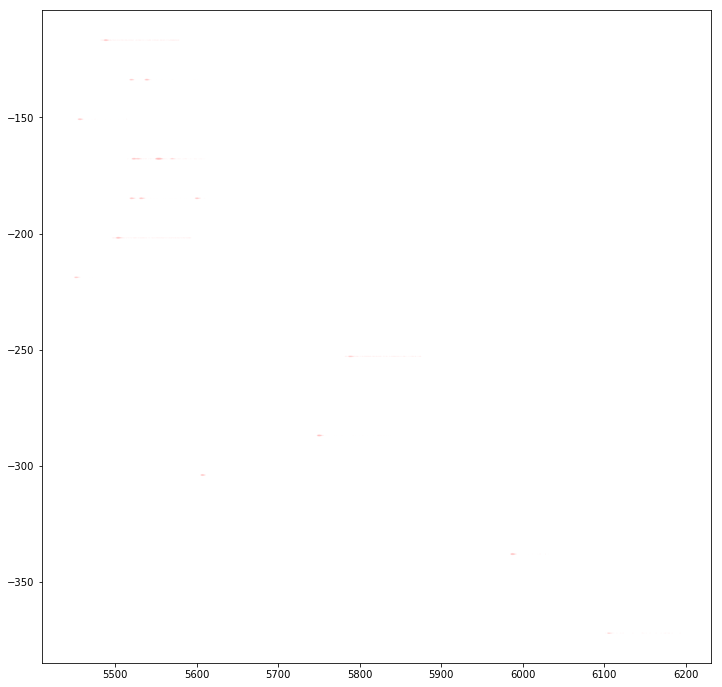

76


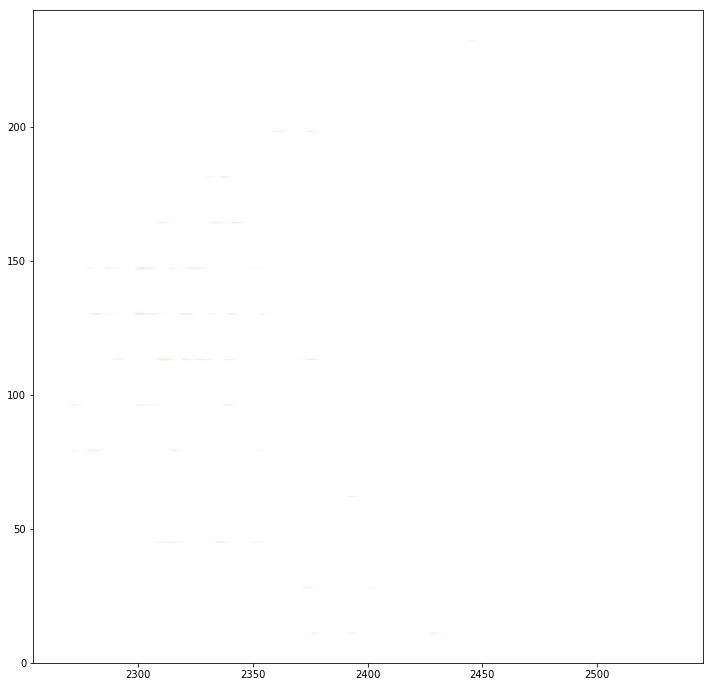

77


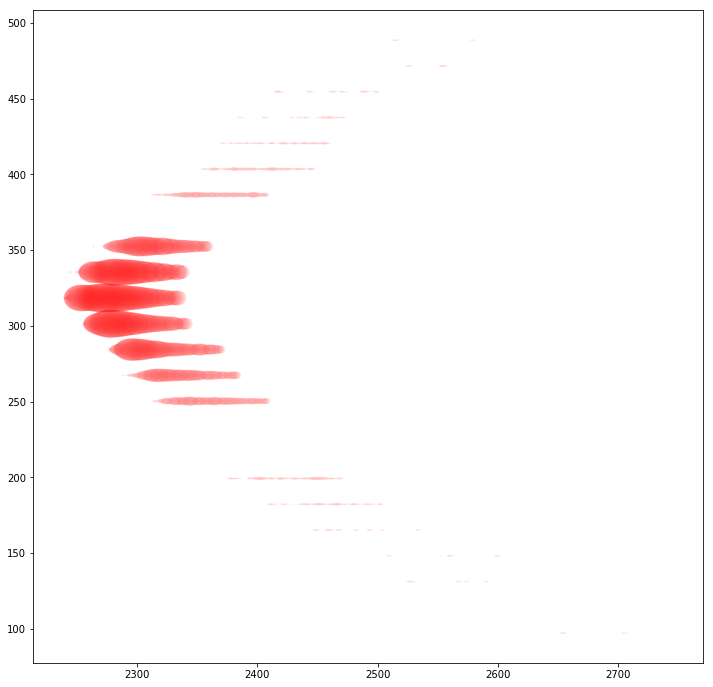

78


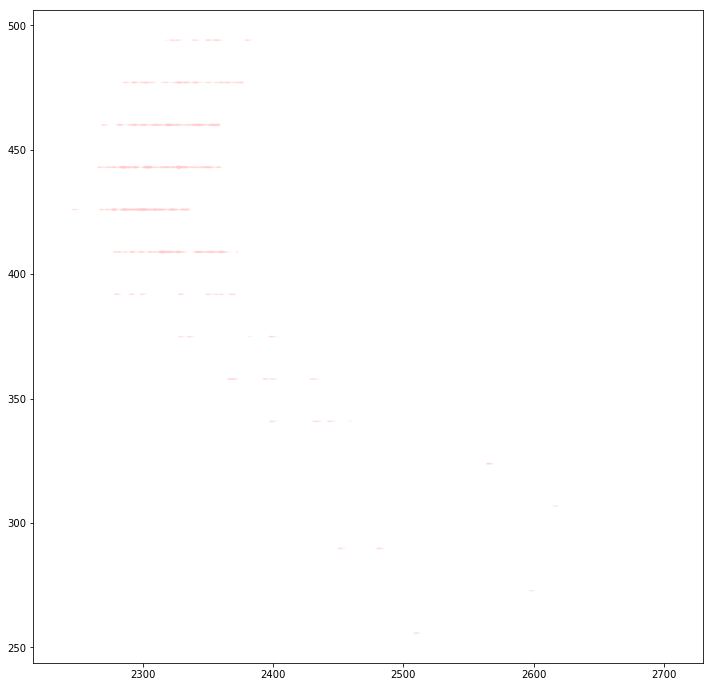

79


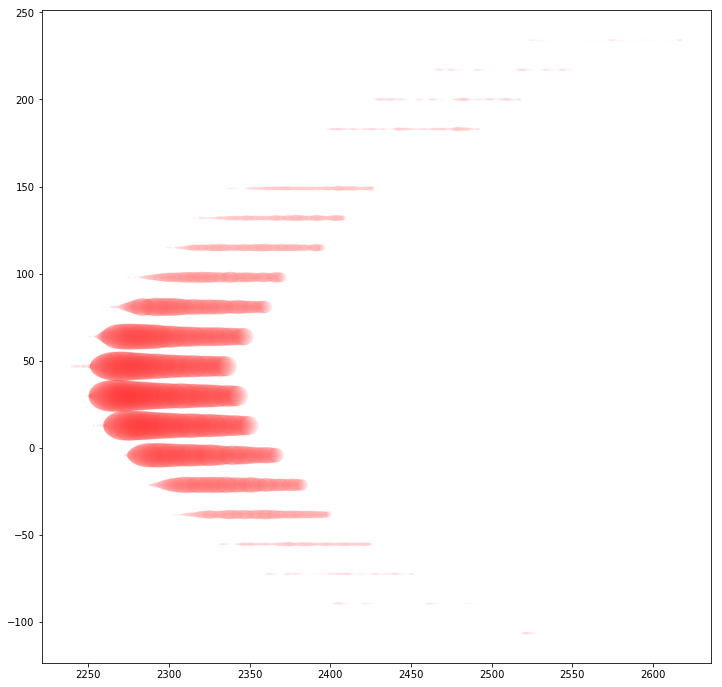

80


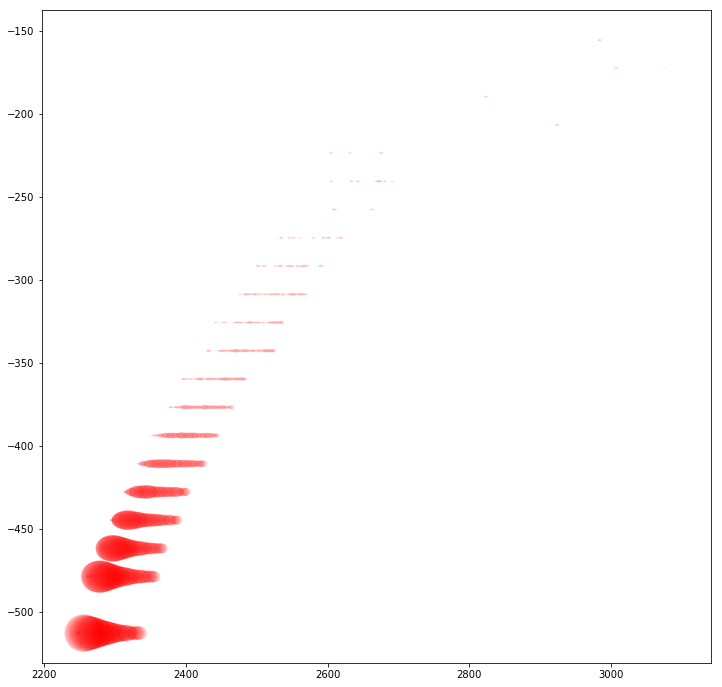

81


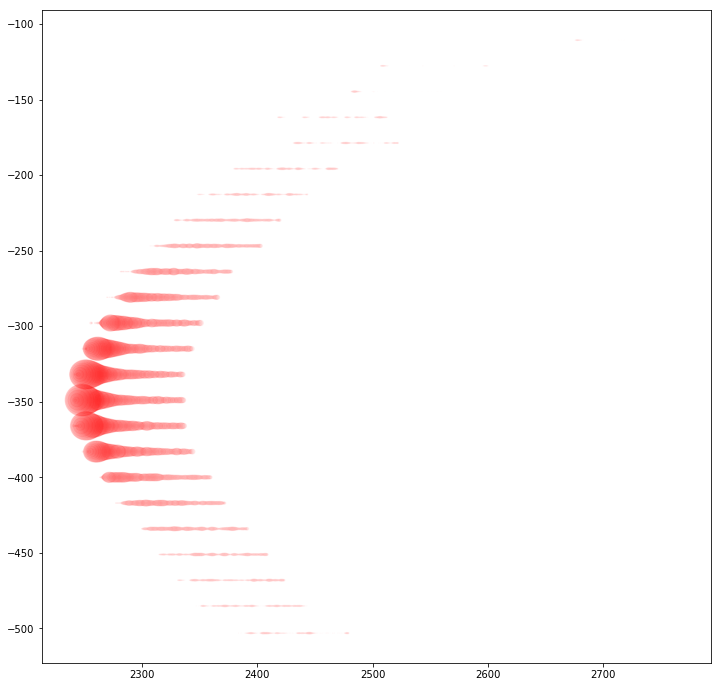

82


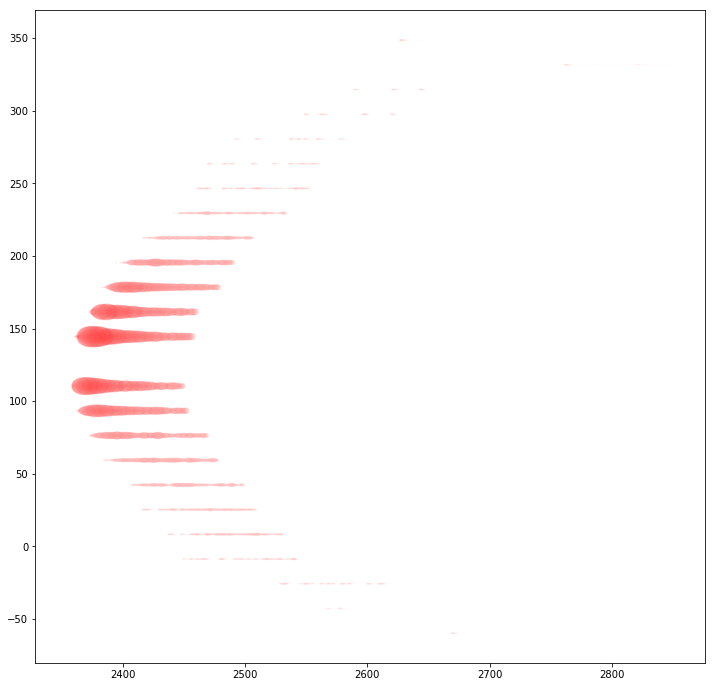

83


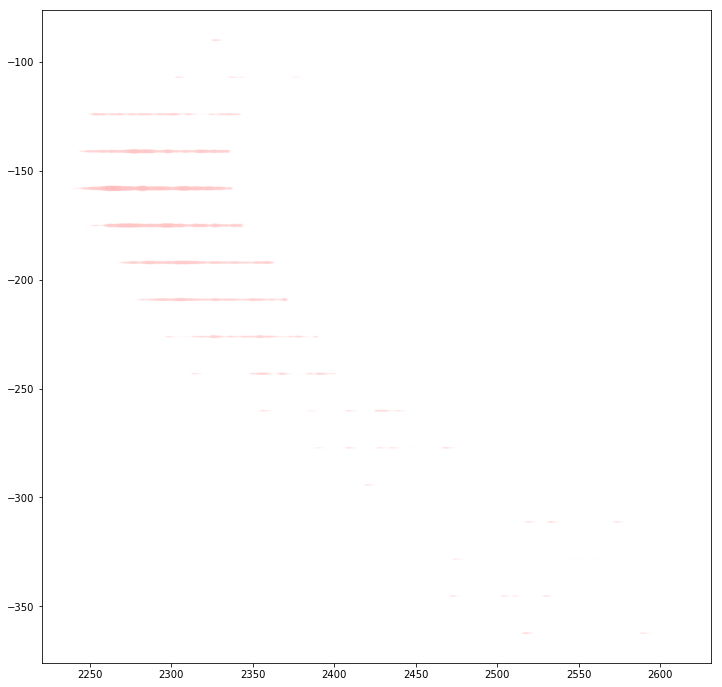

84


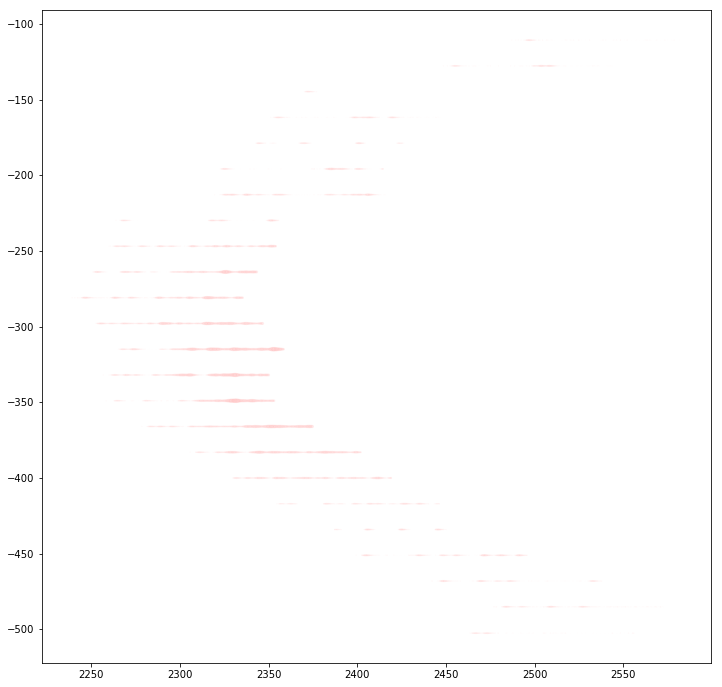

85


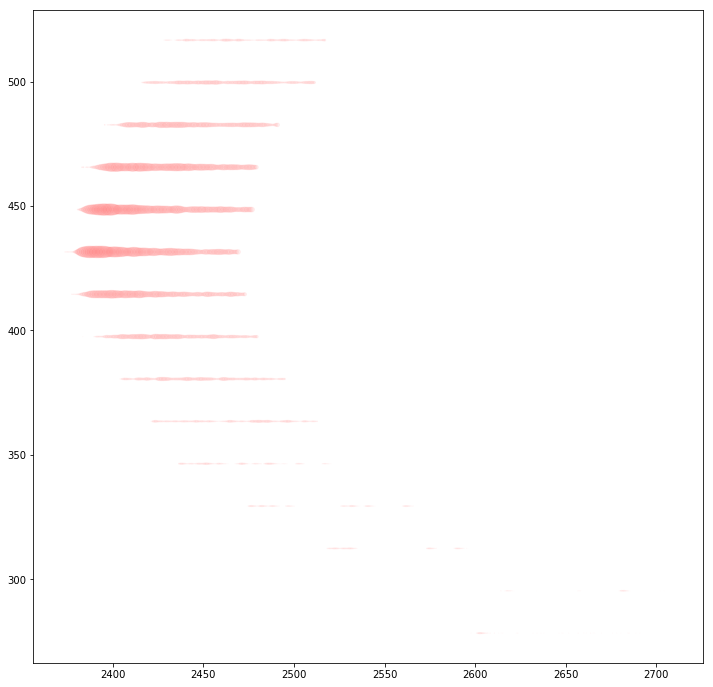

86


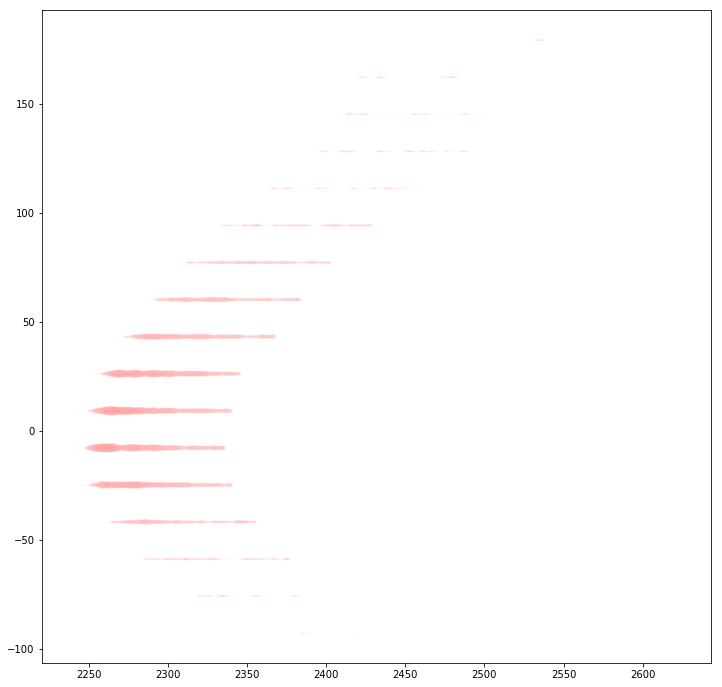

87


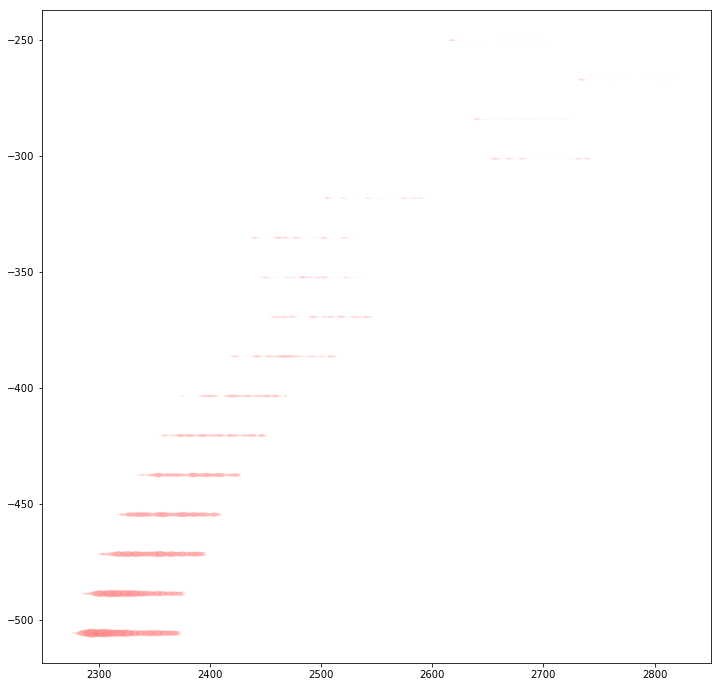

88


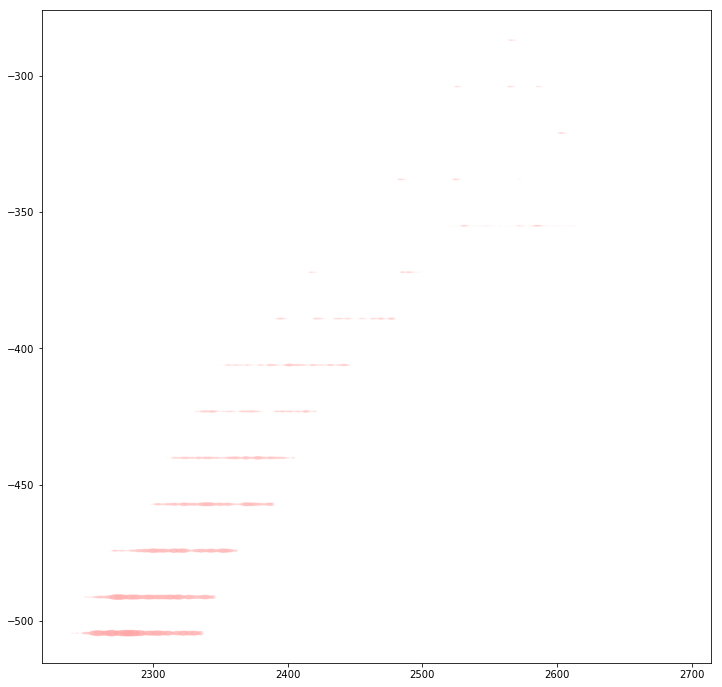

89


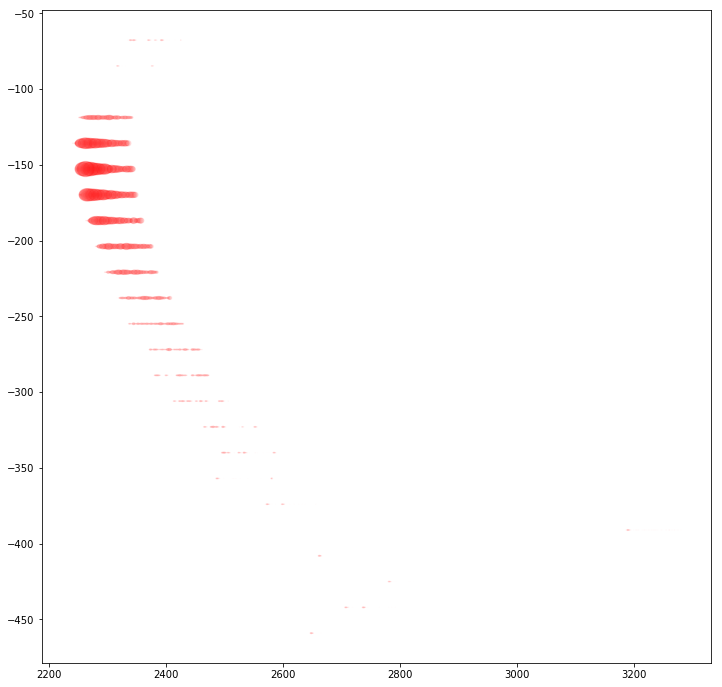

90


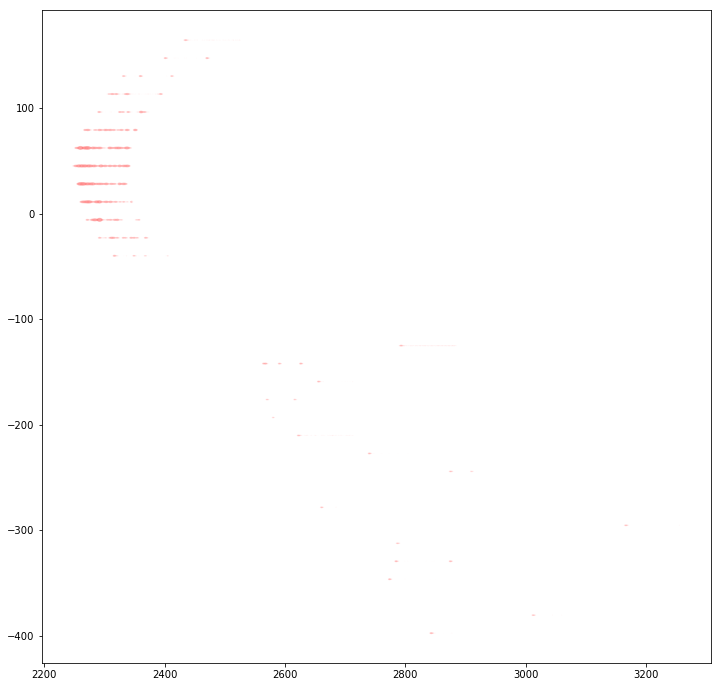

91


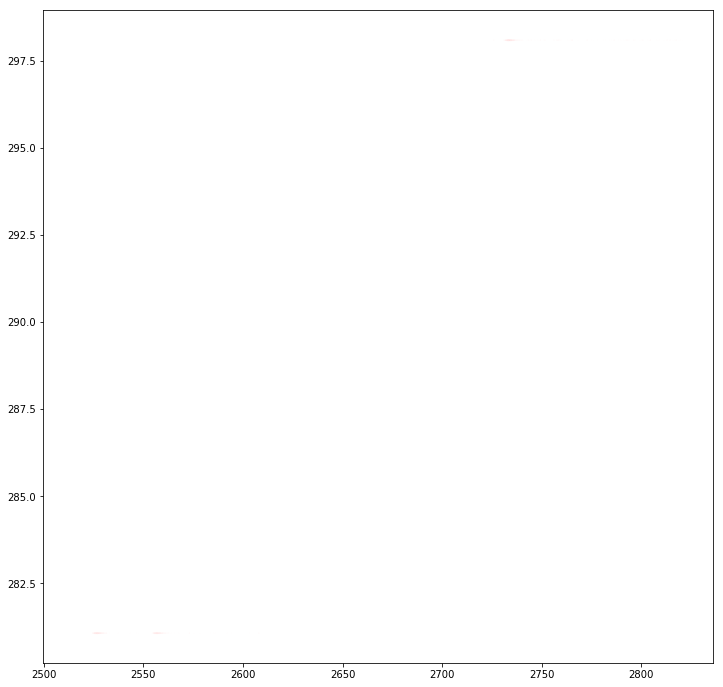

92


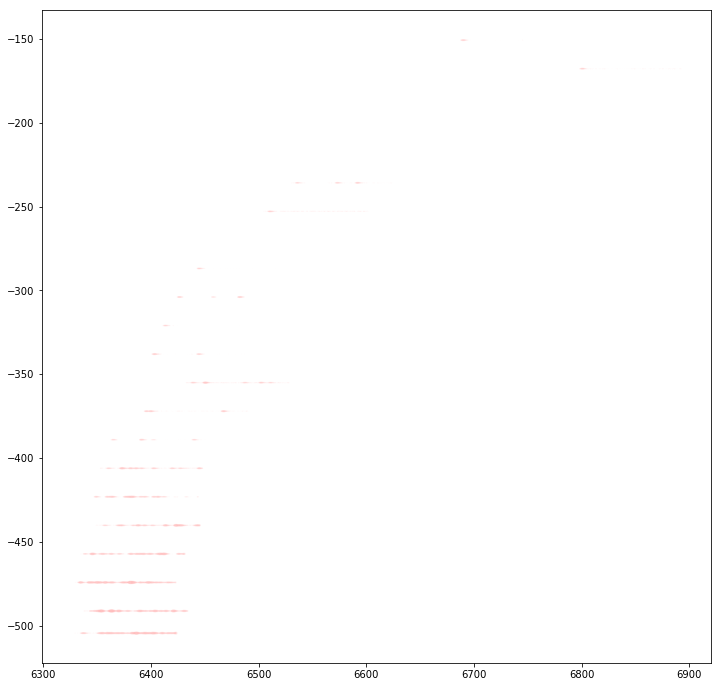

93


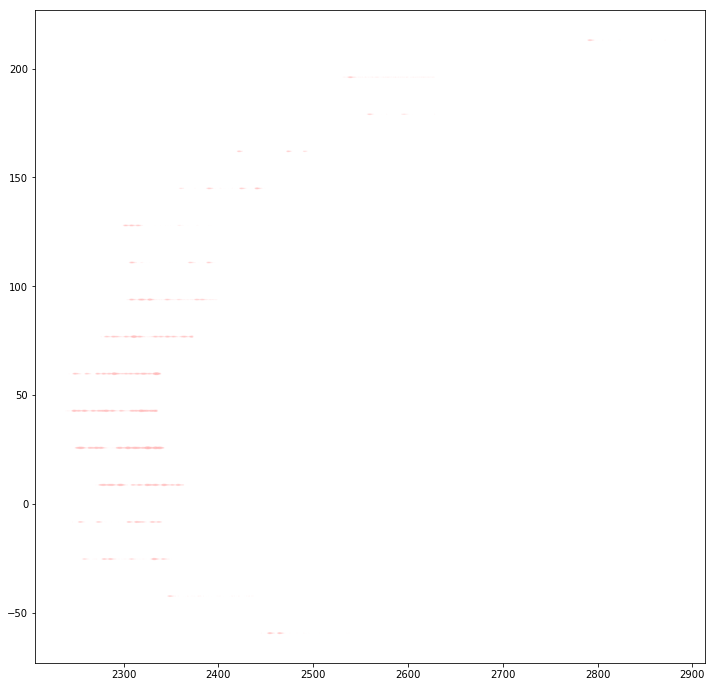

94


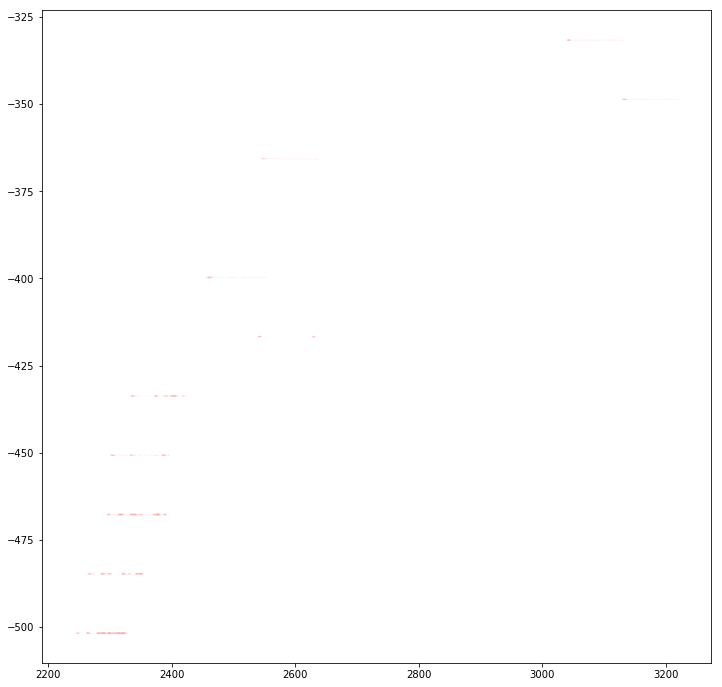

95


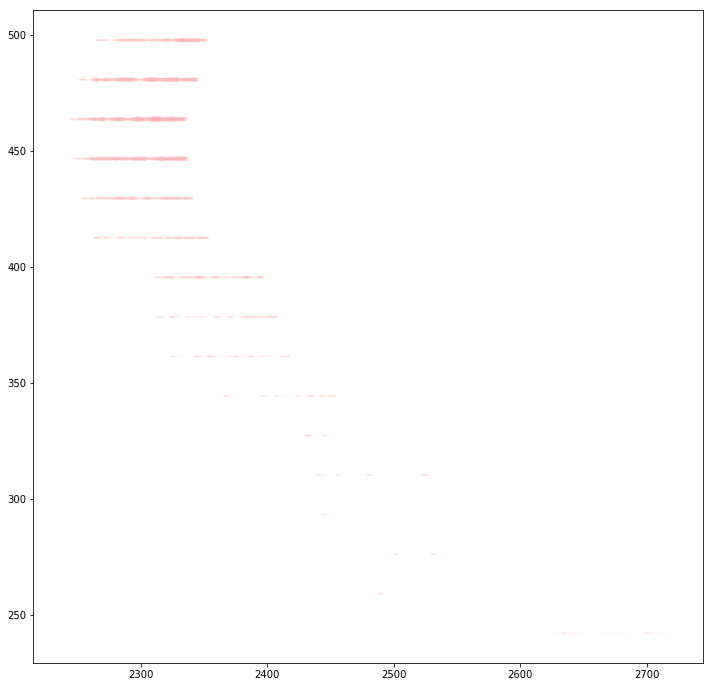

96


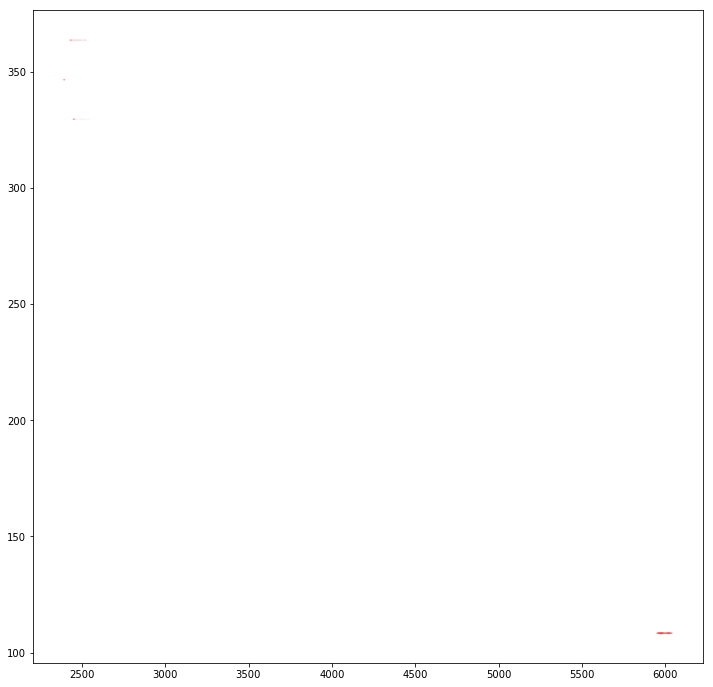

97


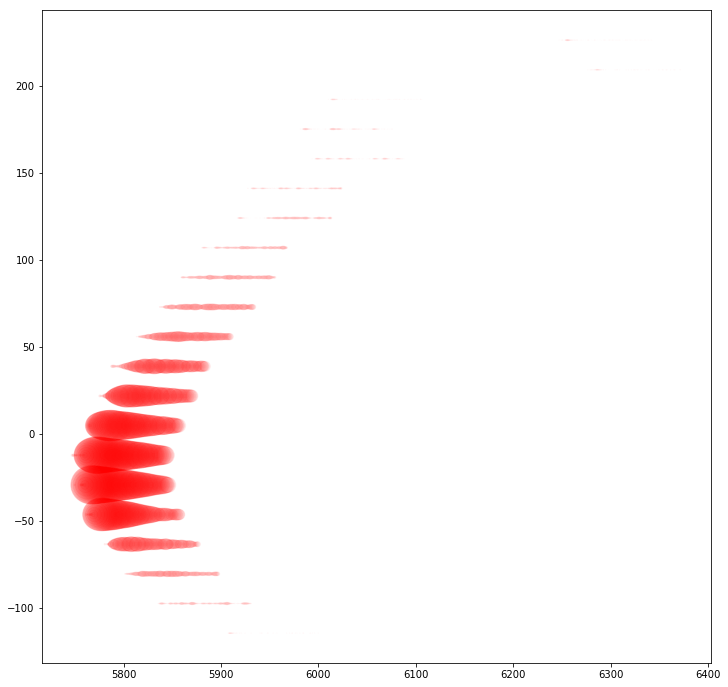

98


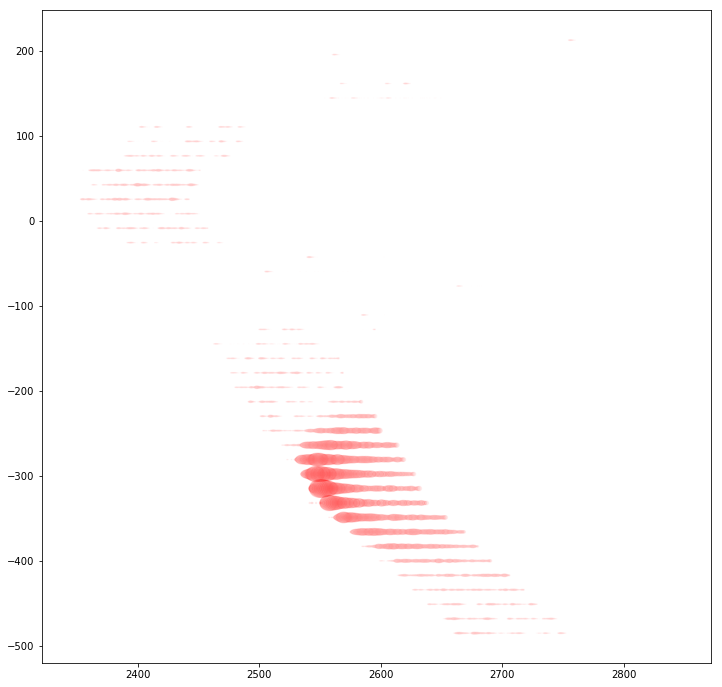

99


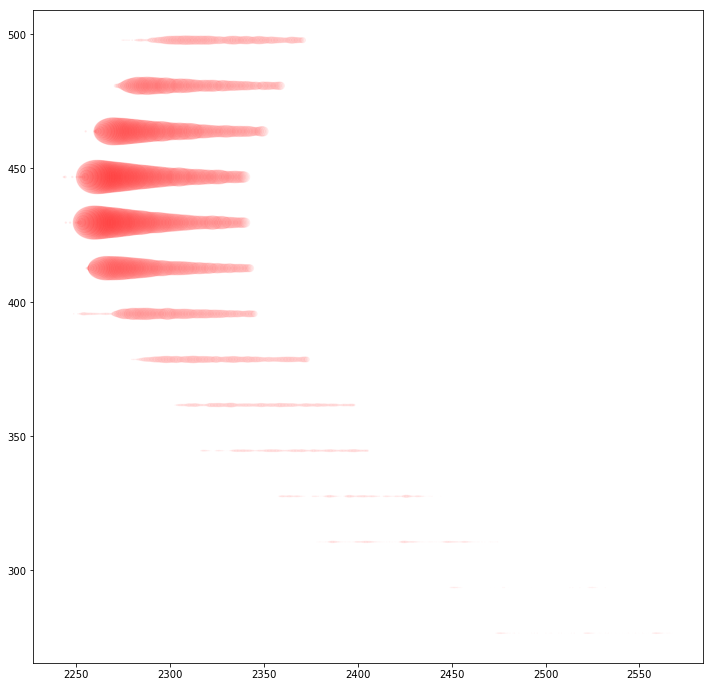

100


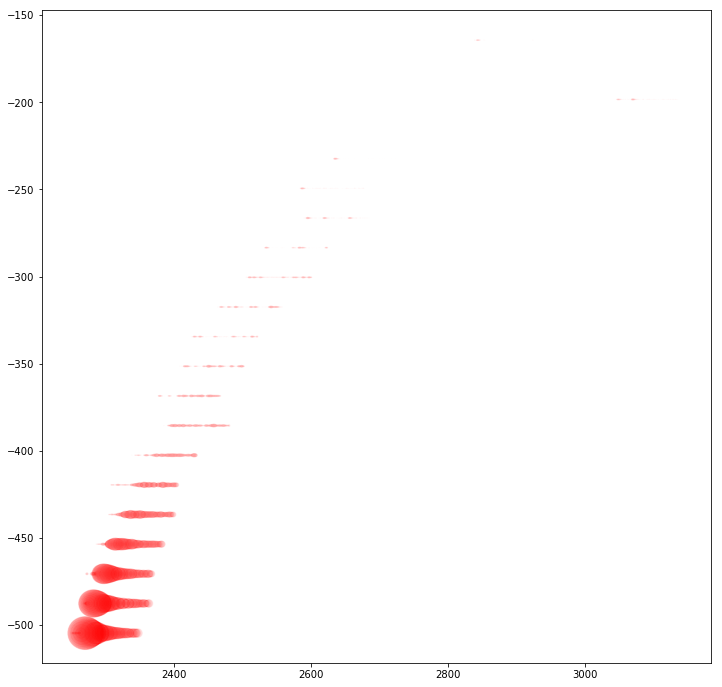

101


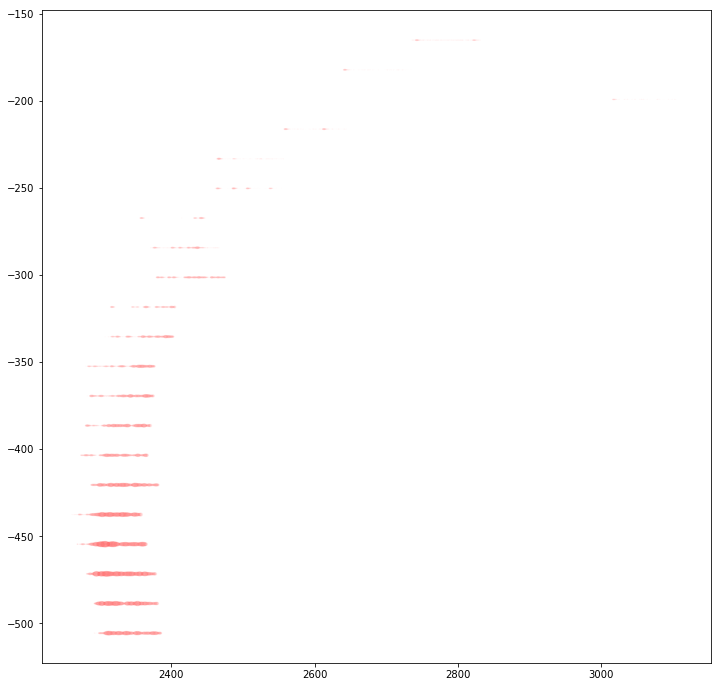

102


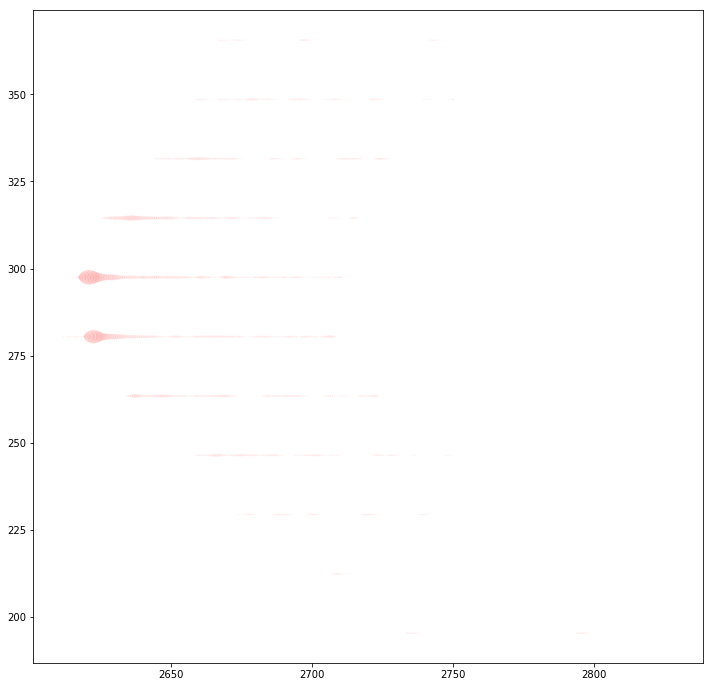

103


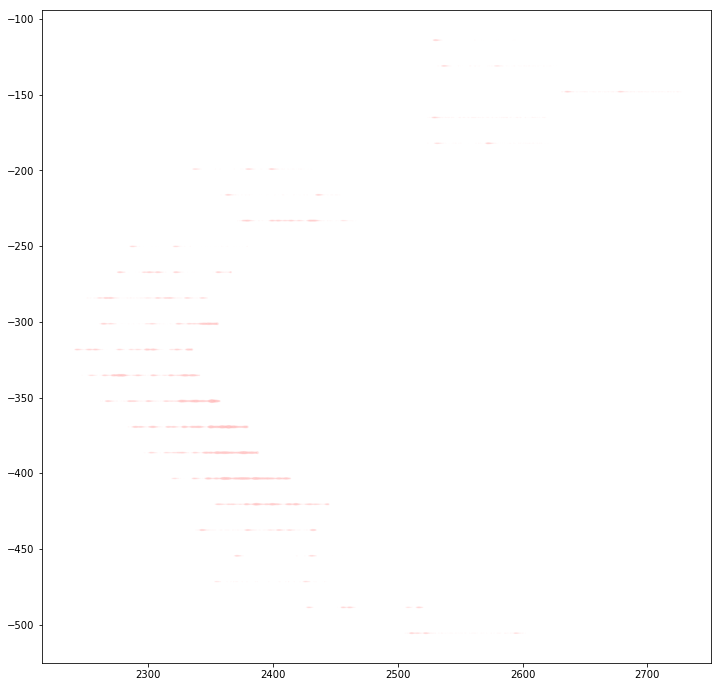

104


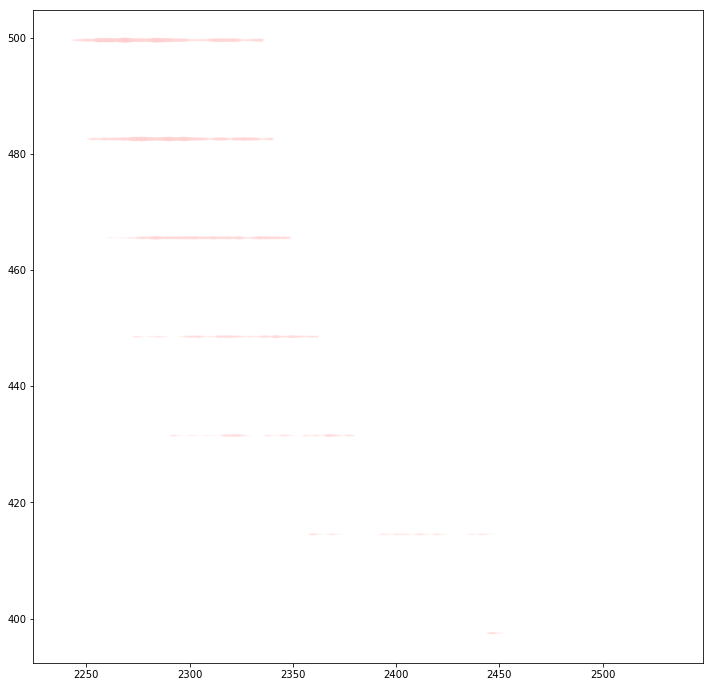

105


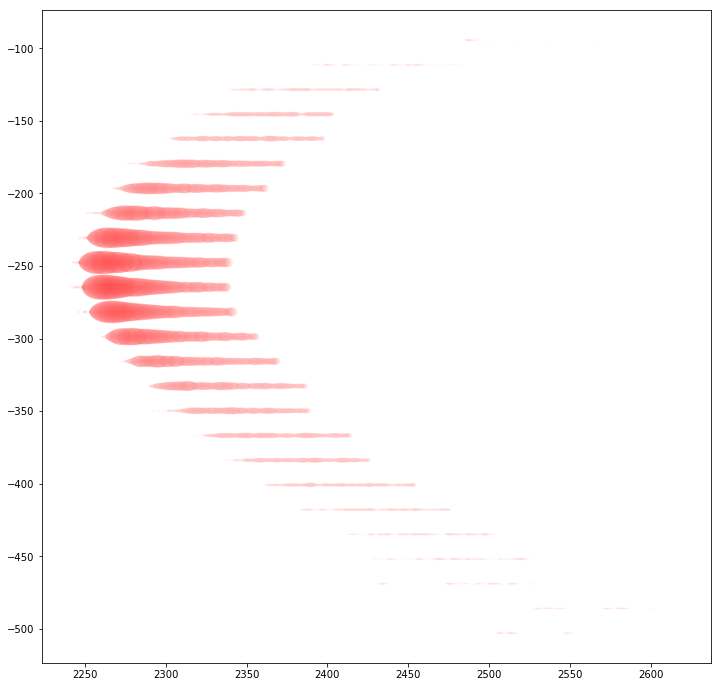

106


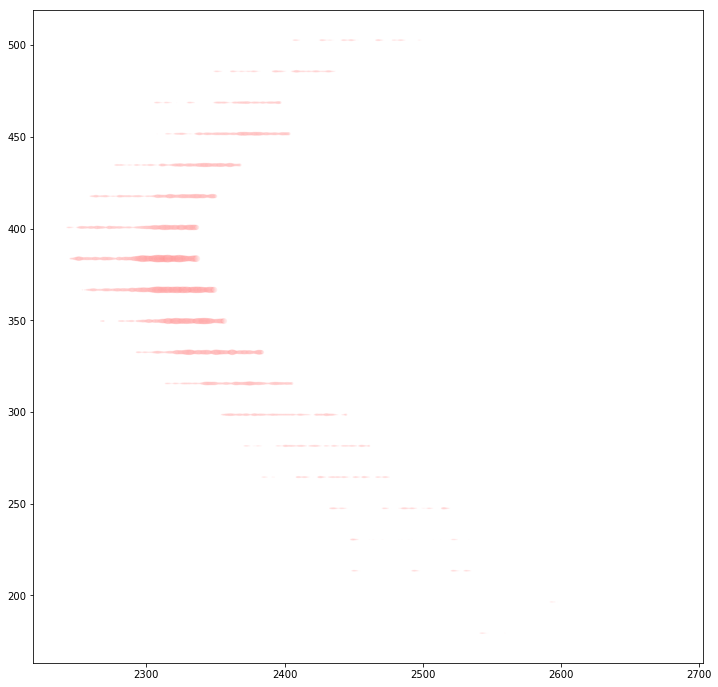

107


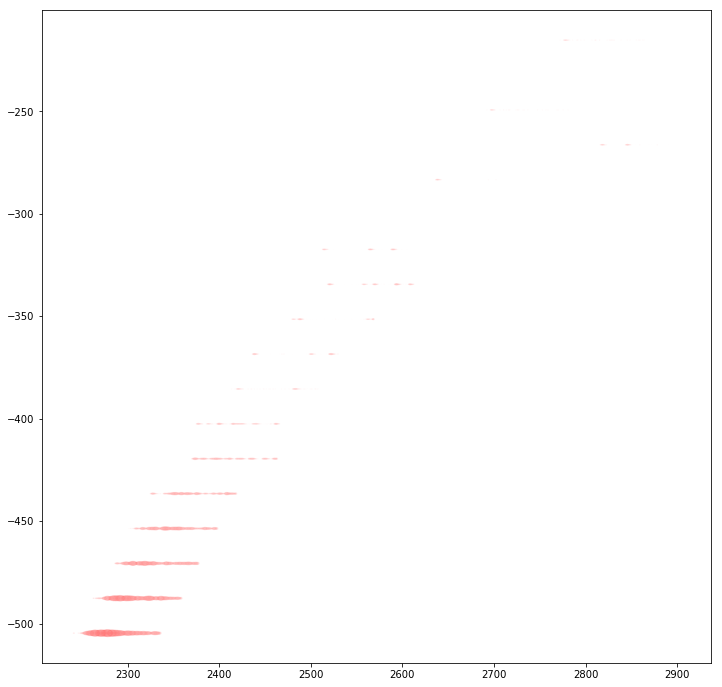

108


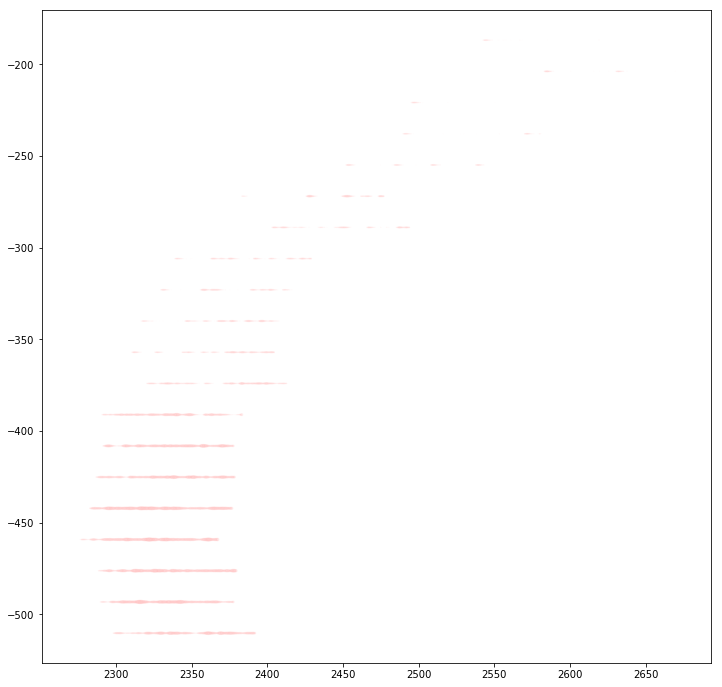

109


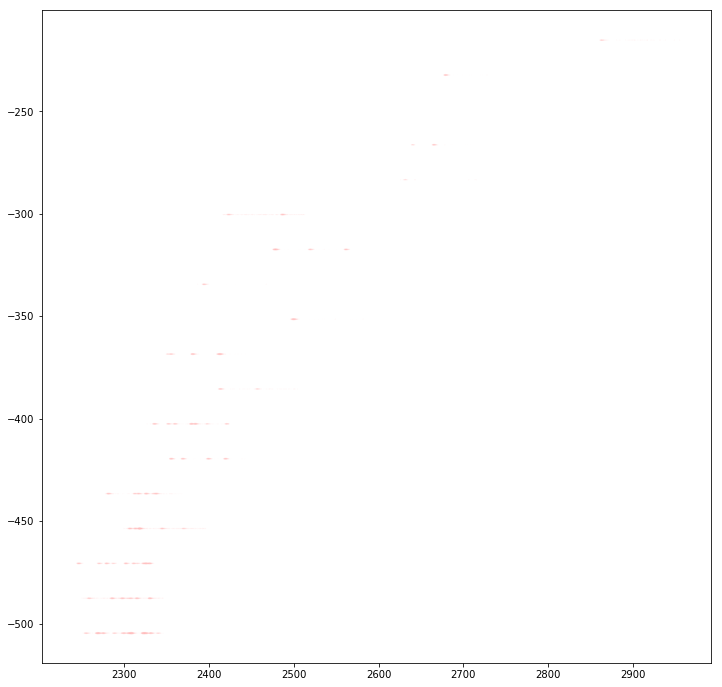

110


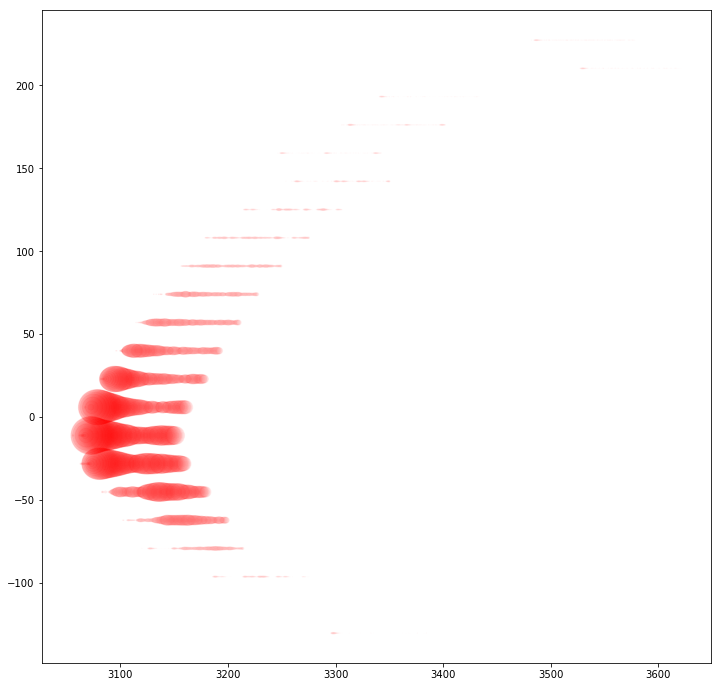

111


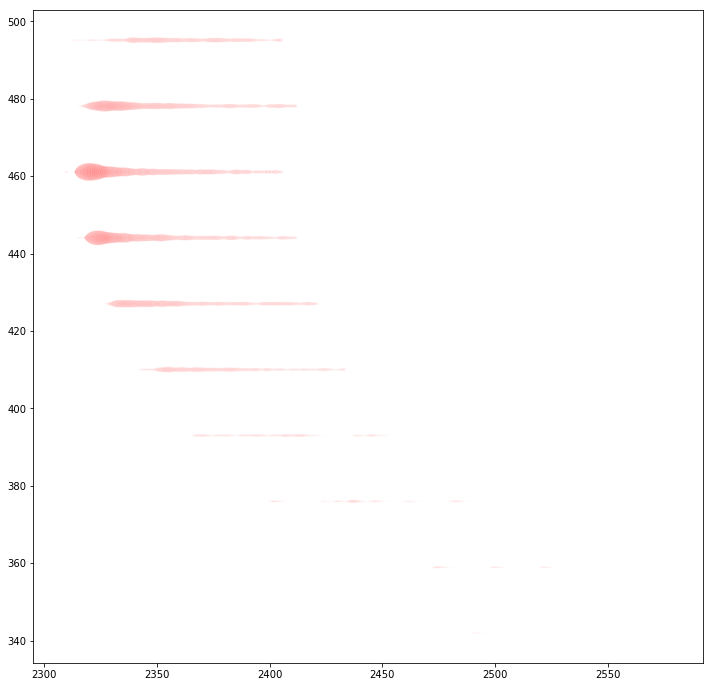

112


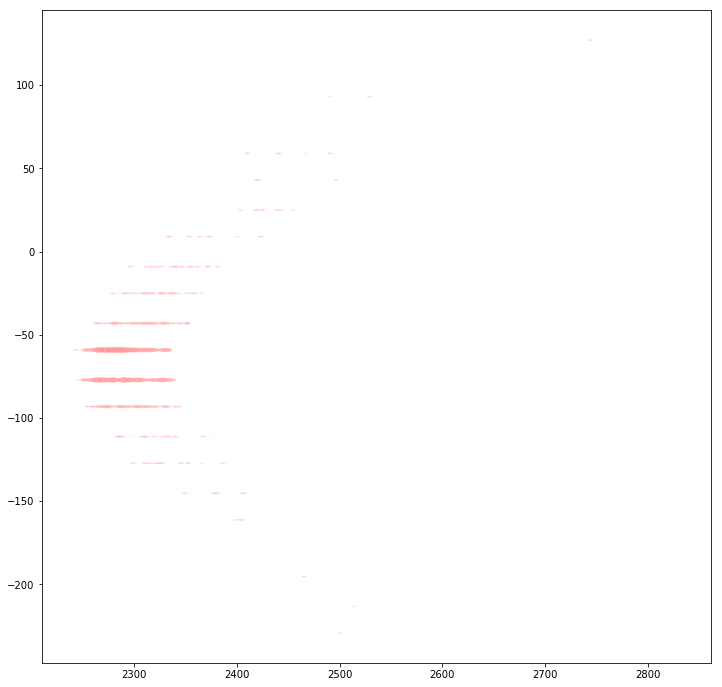

113


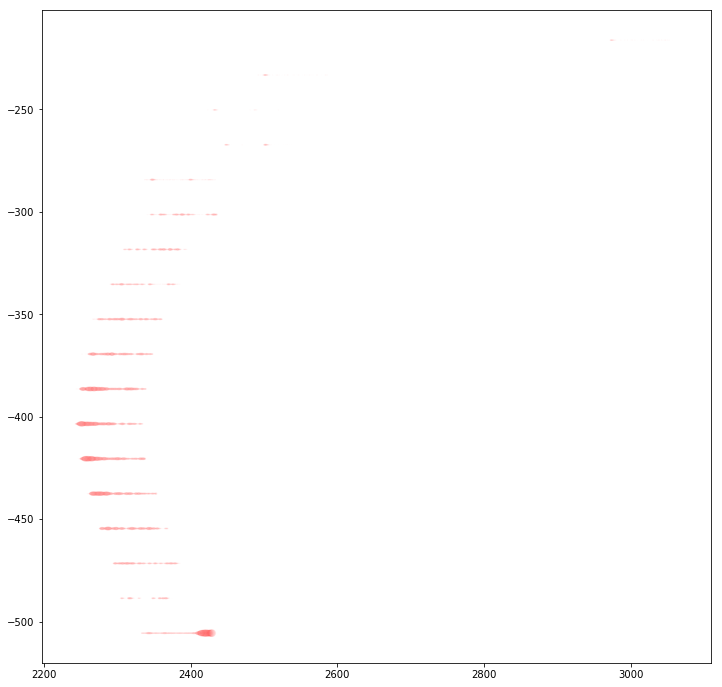

114


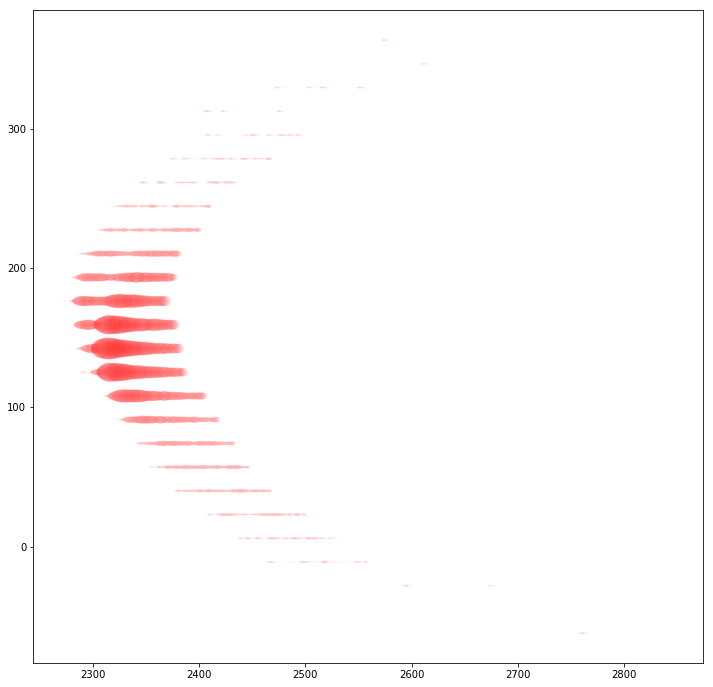

115


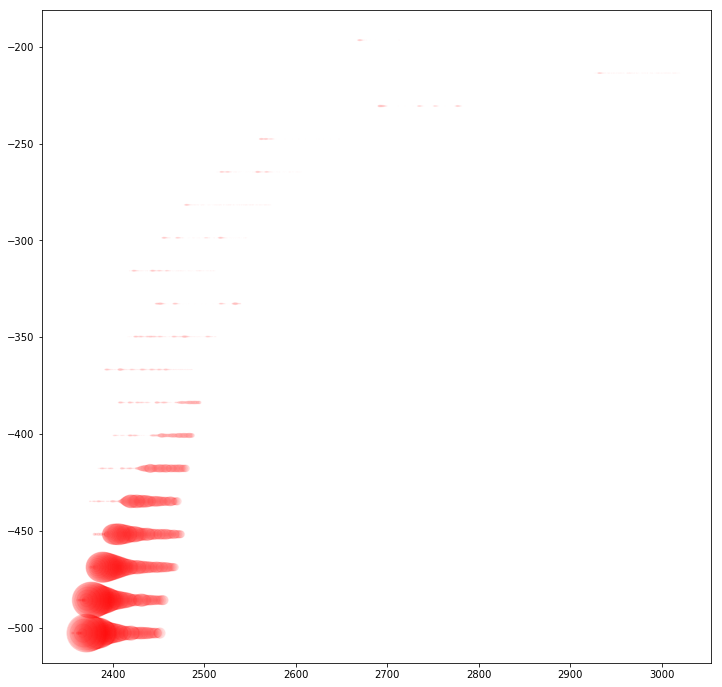

116


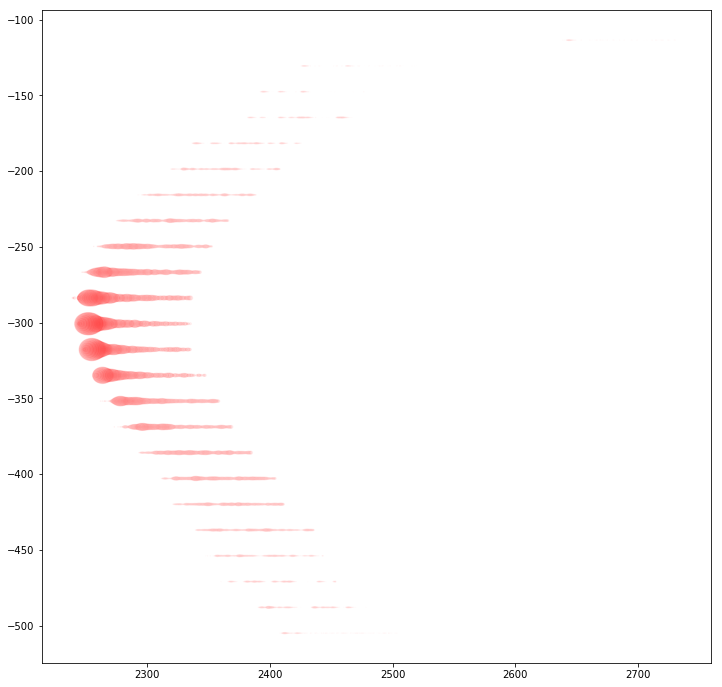

117


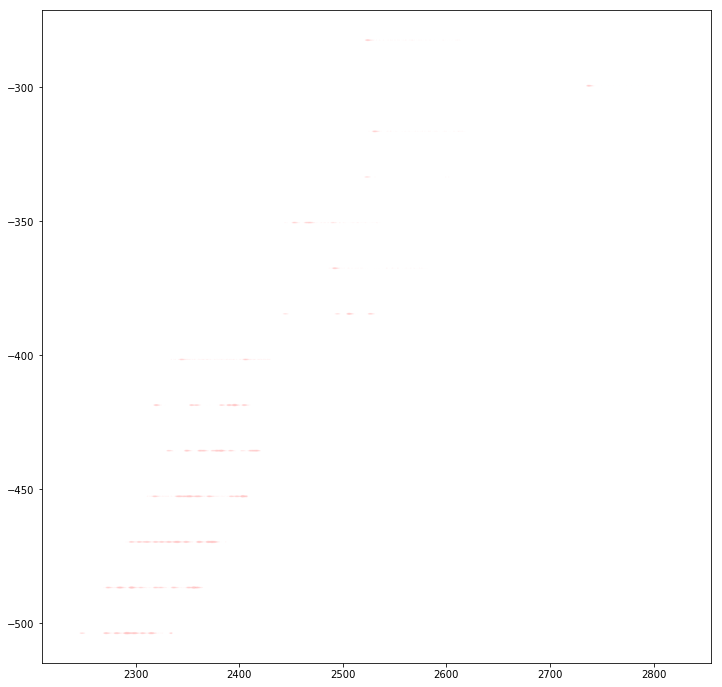

118


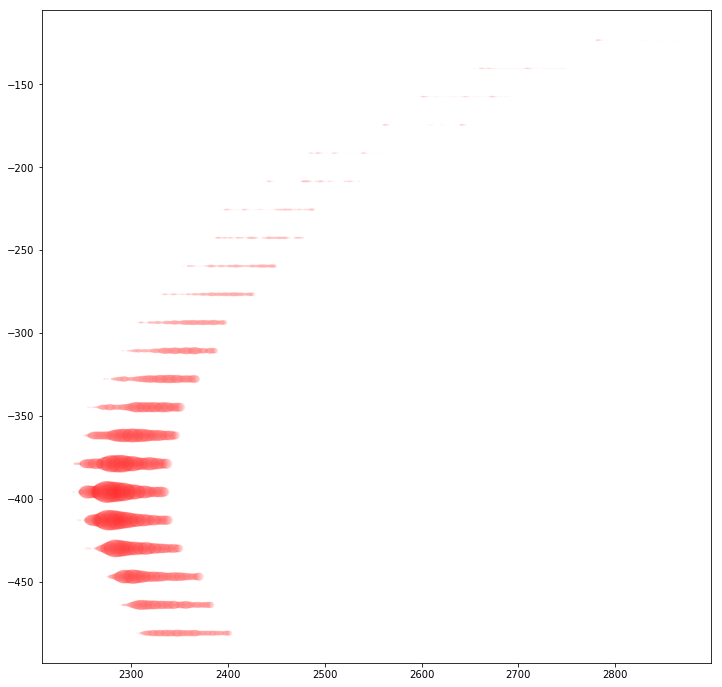

119


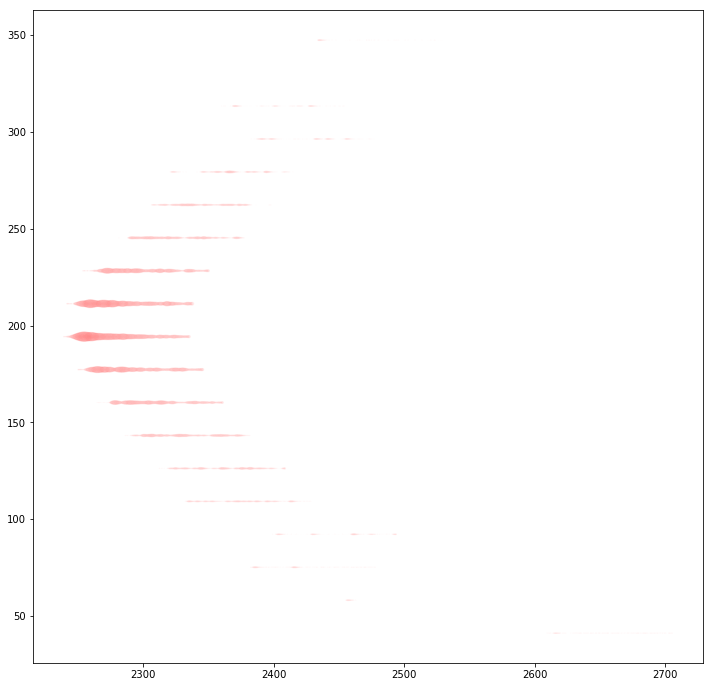

120


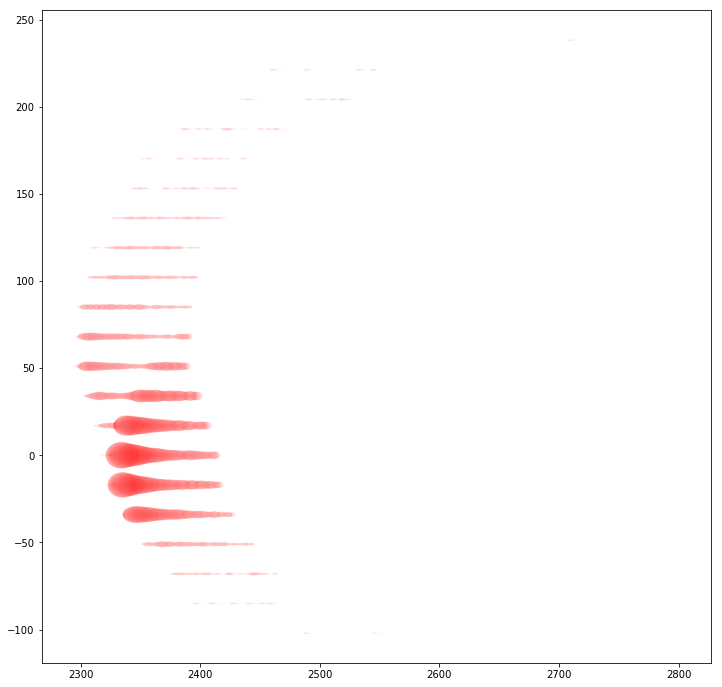

121


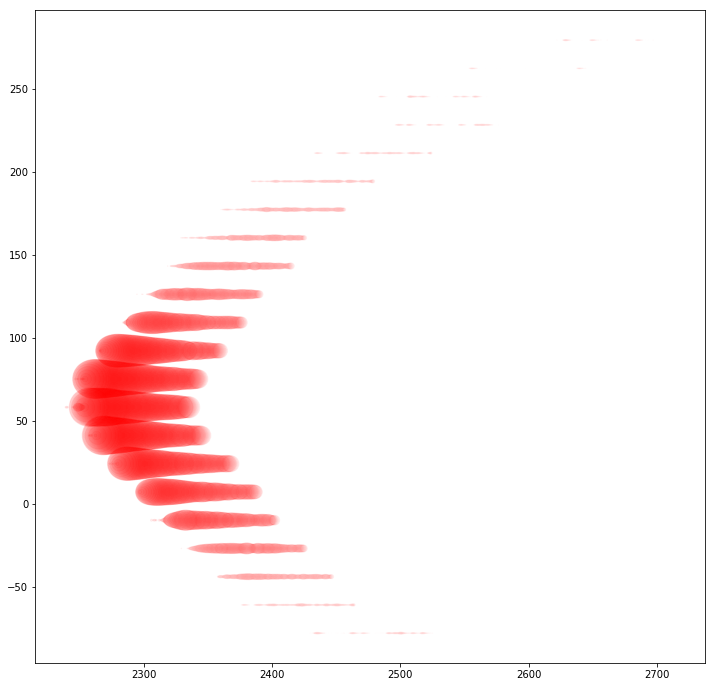

122


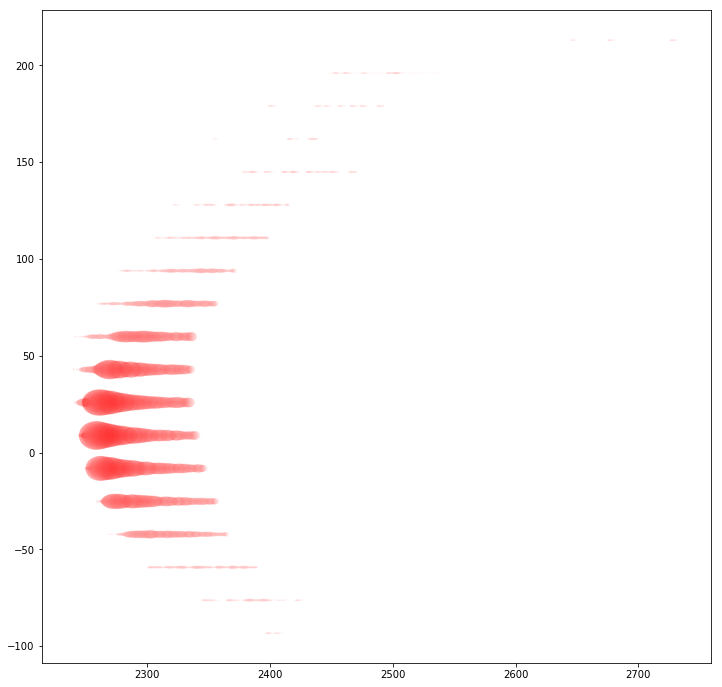

123


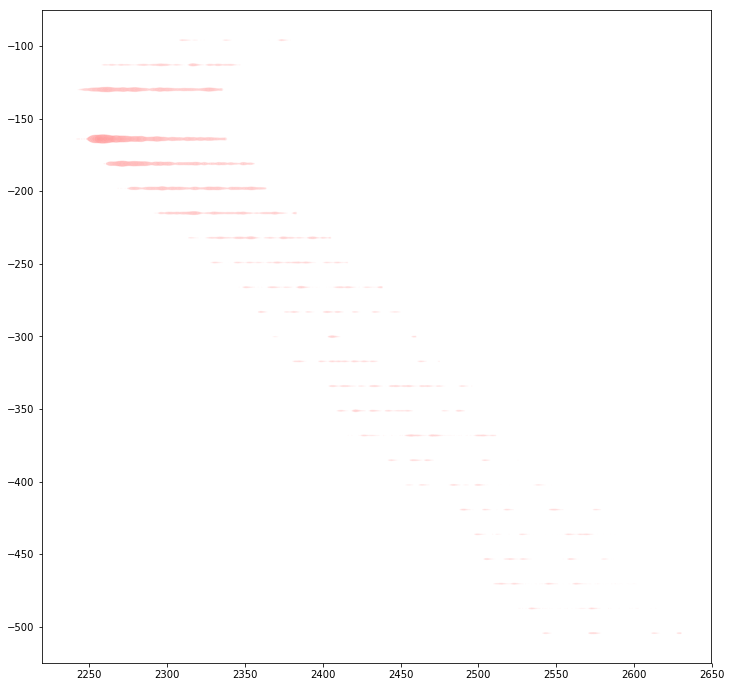

124


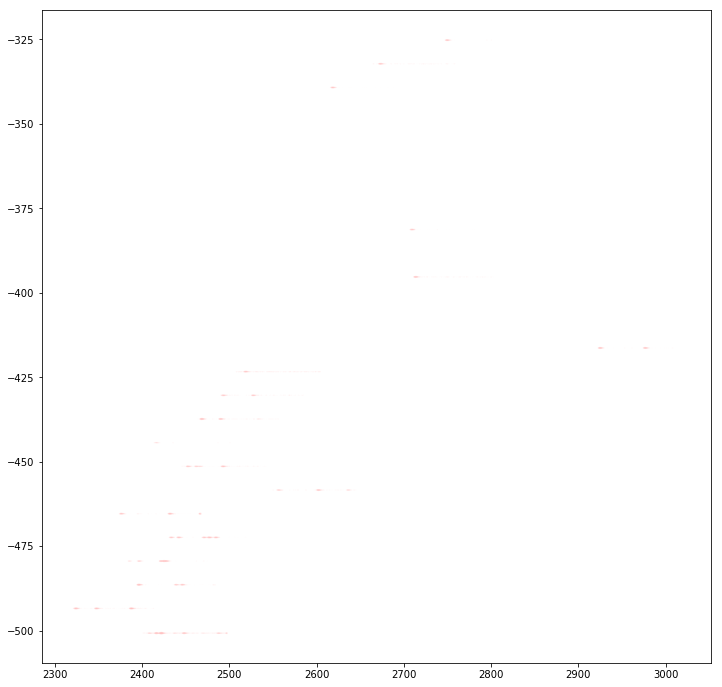

125


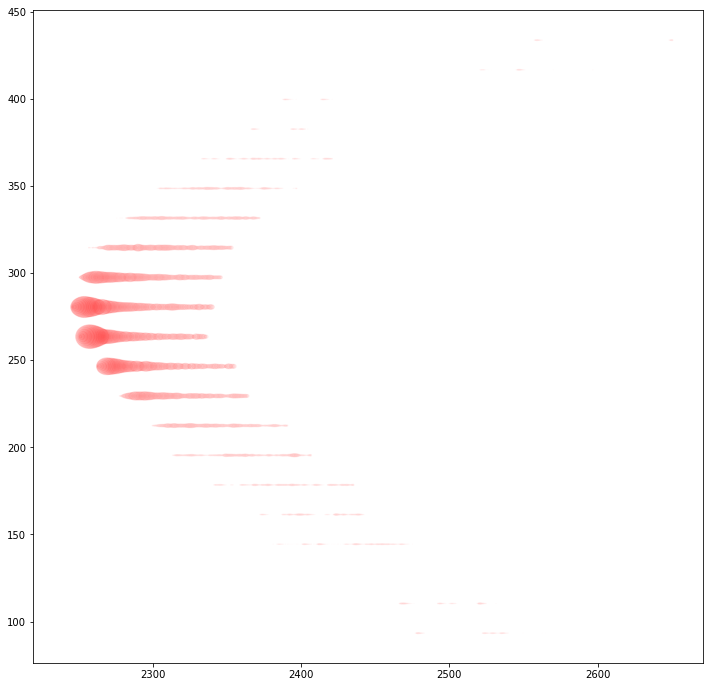

126


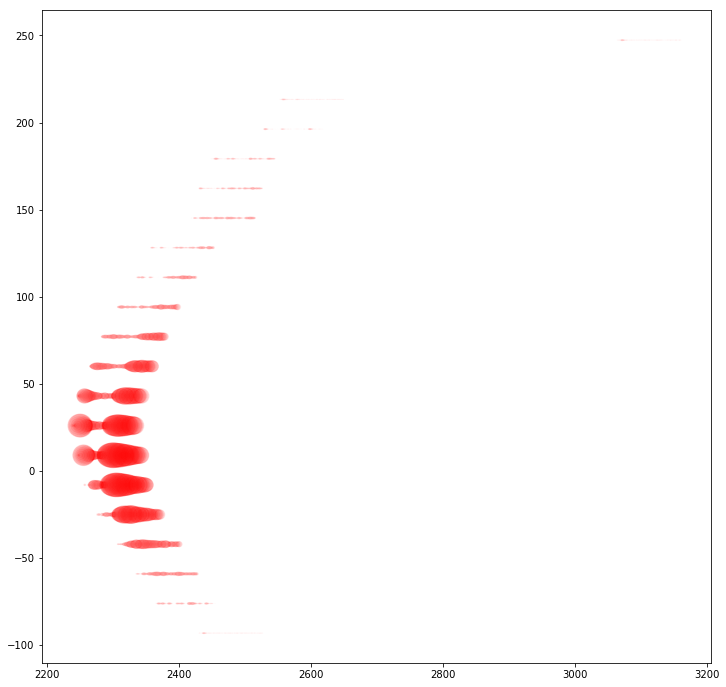

127


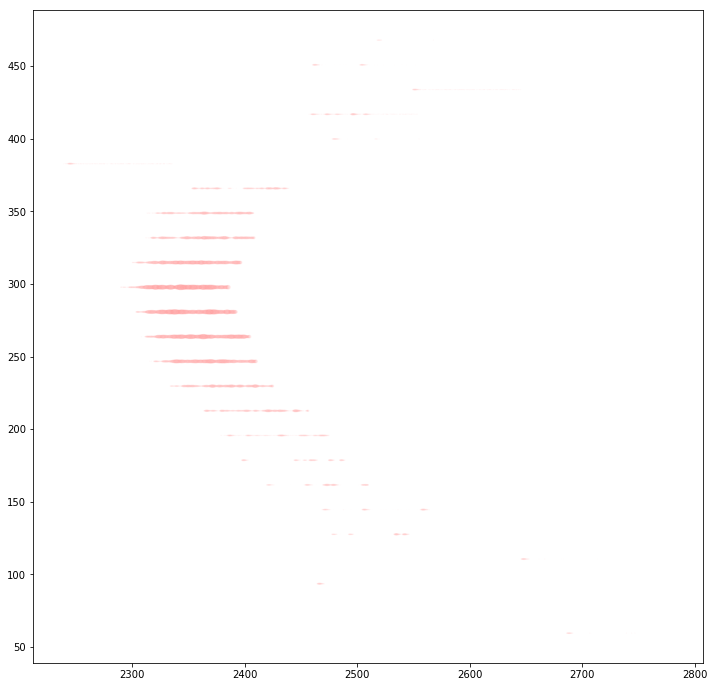

128


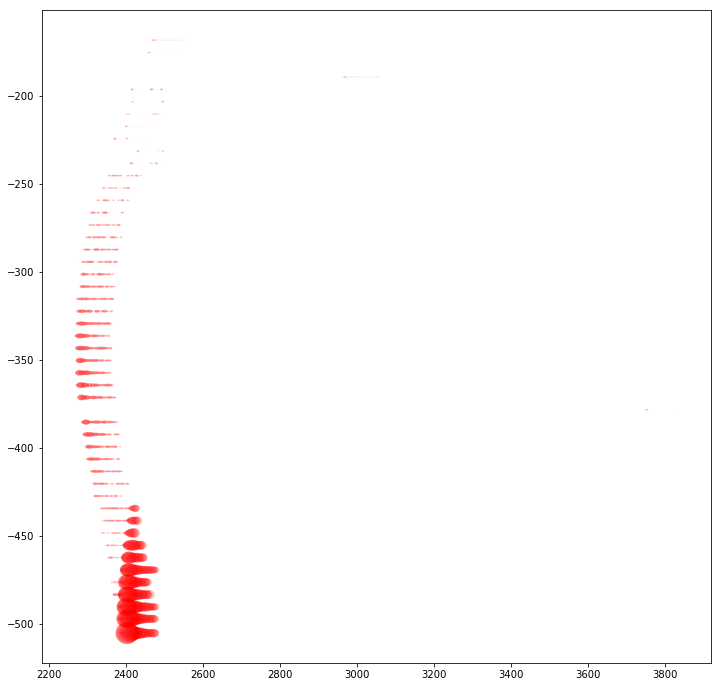

129


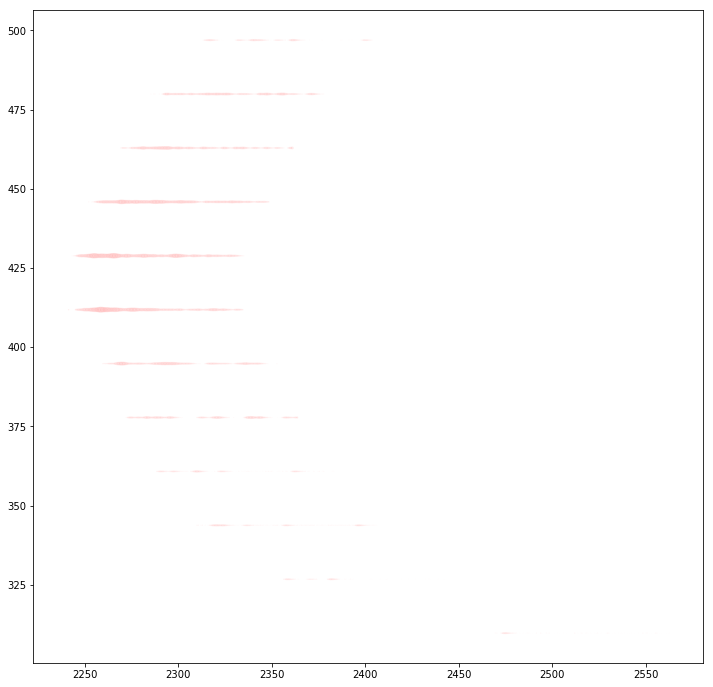

130


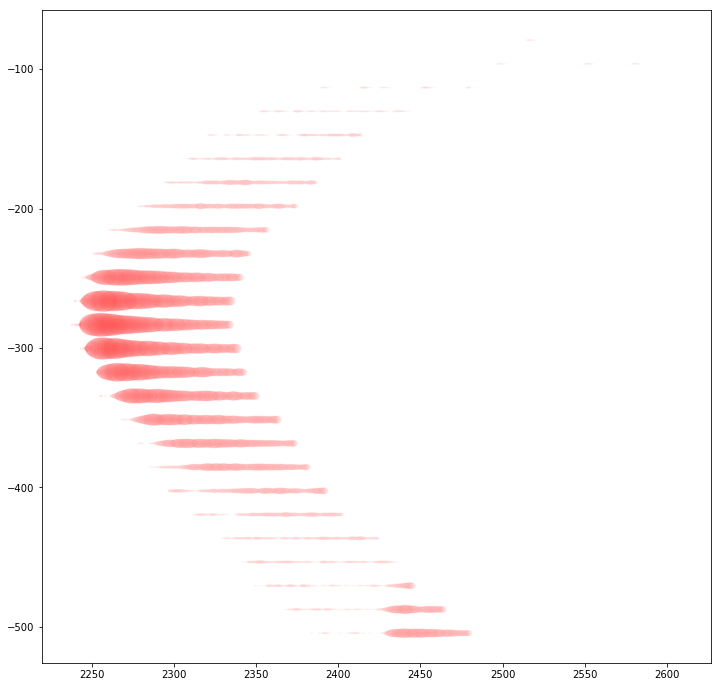

131


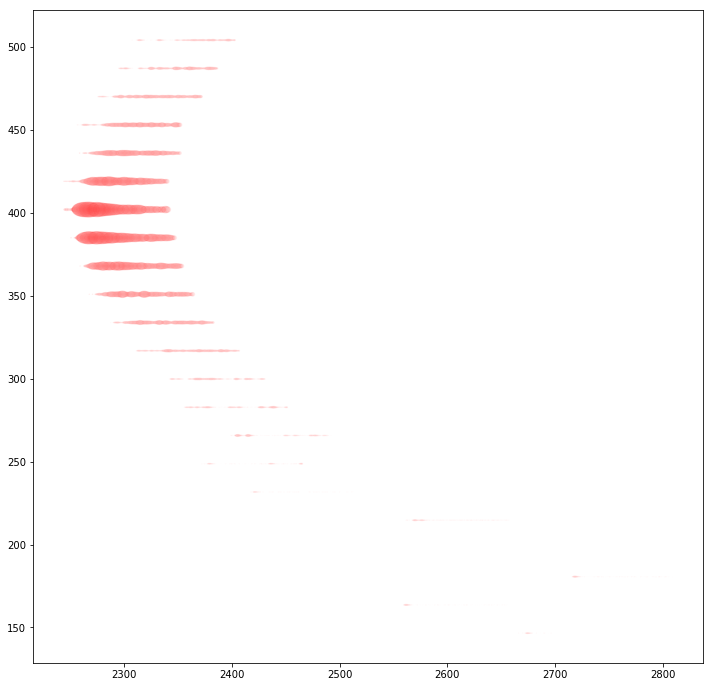

132


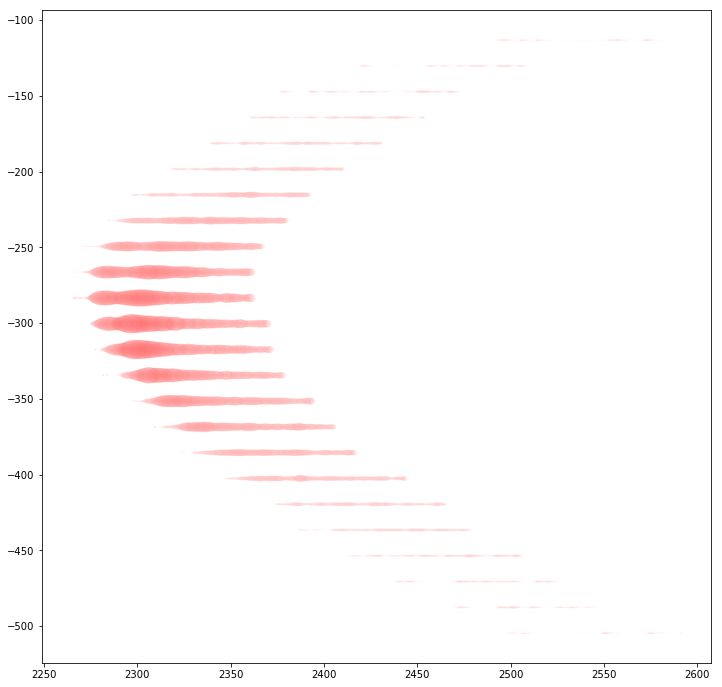

133


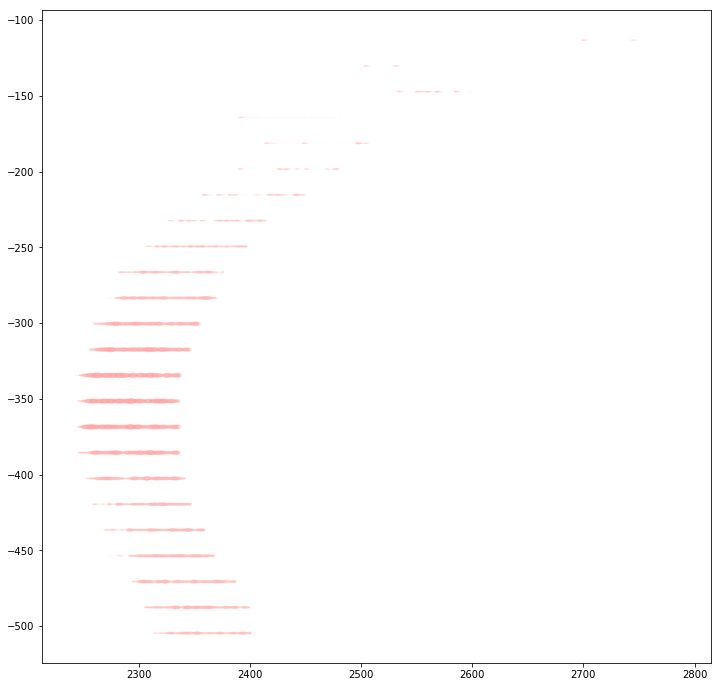

134


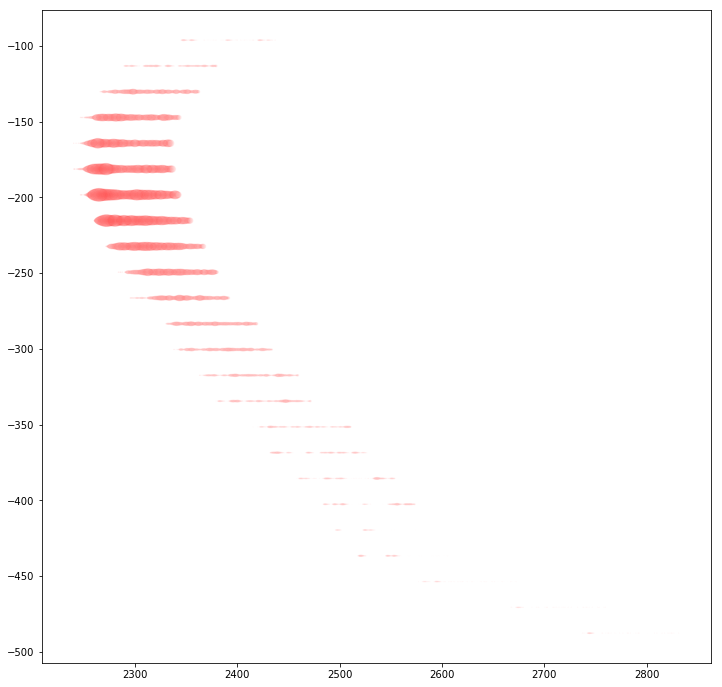

135


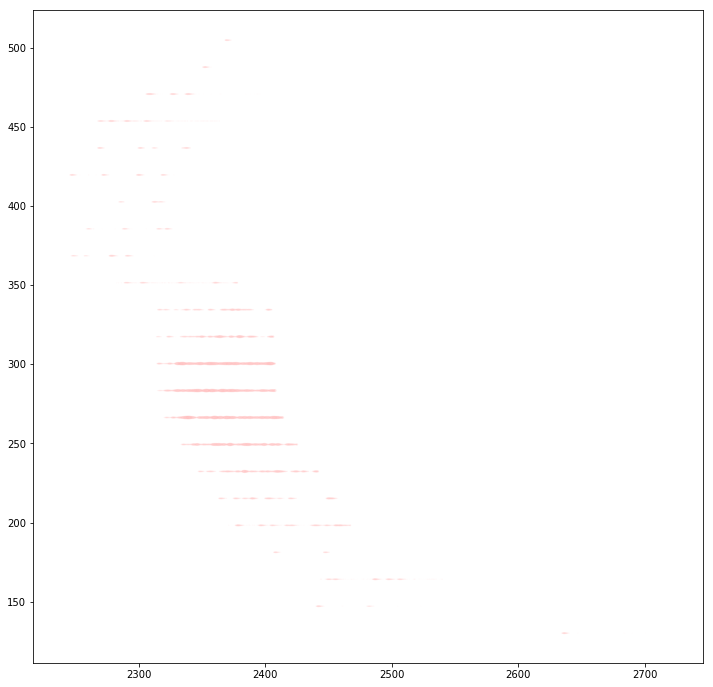

136


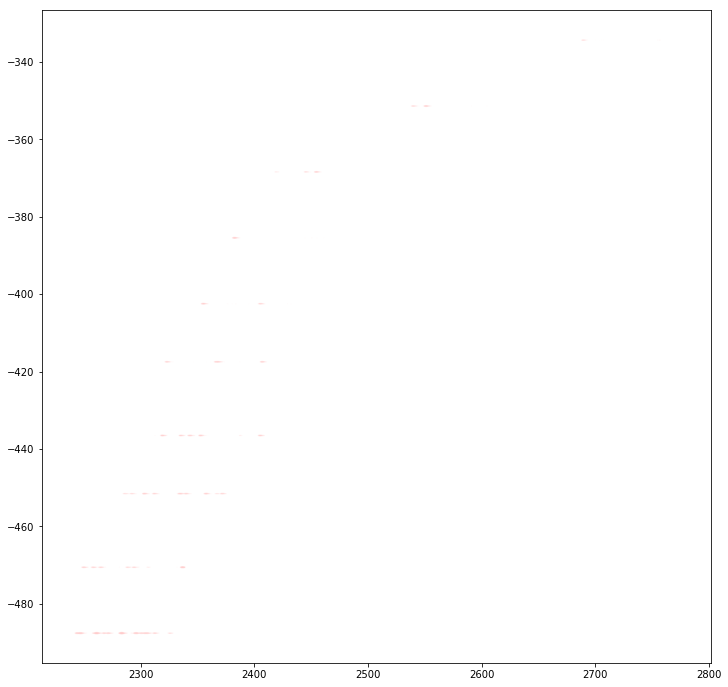

137


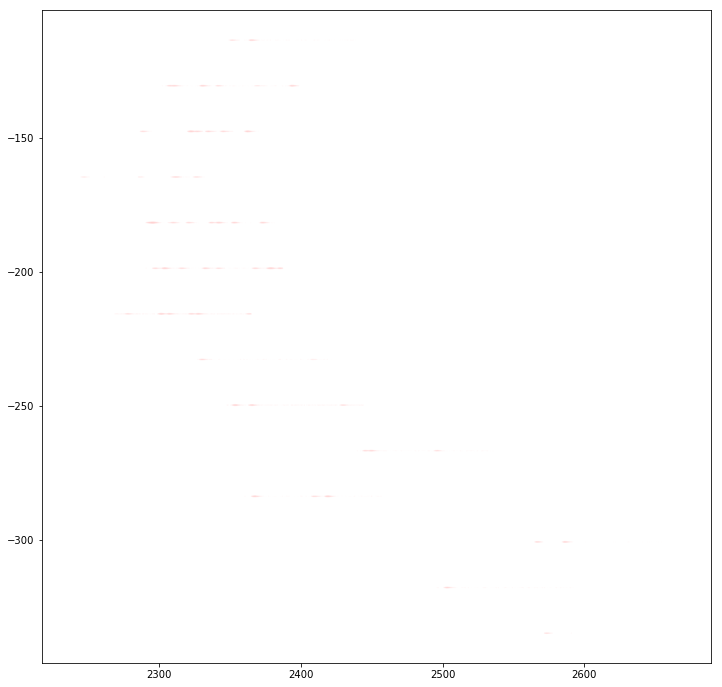

138


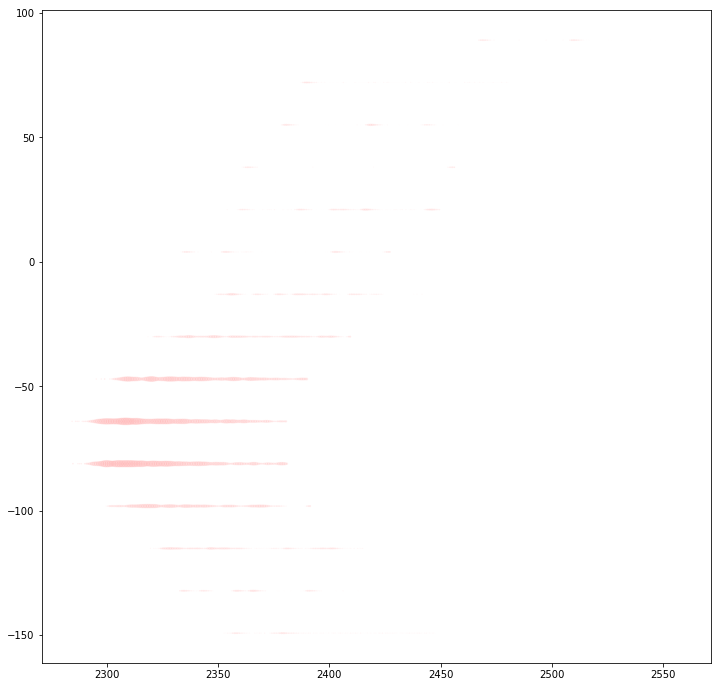

139


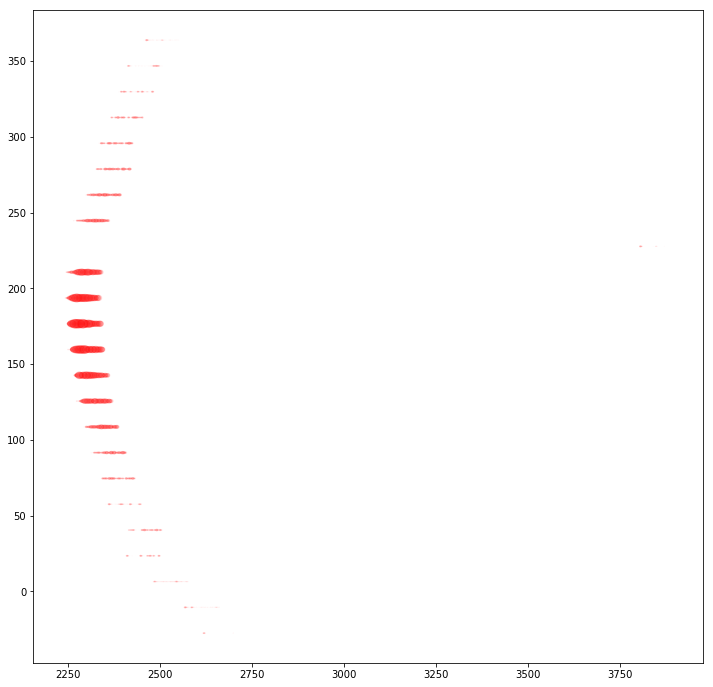

140


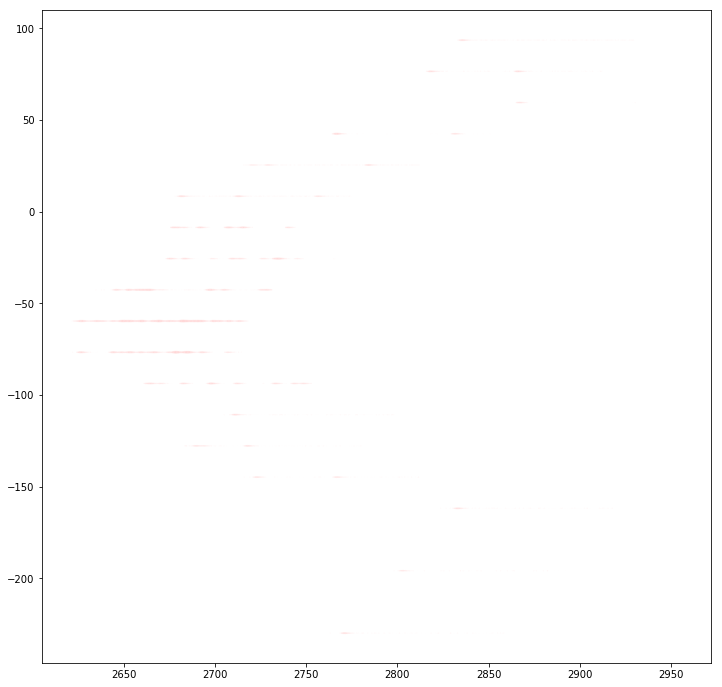

141


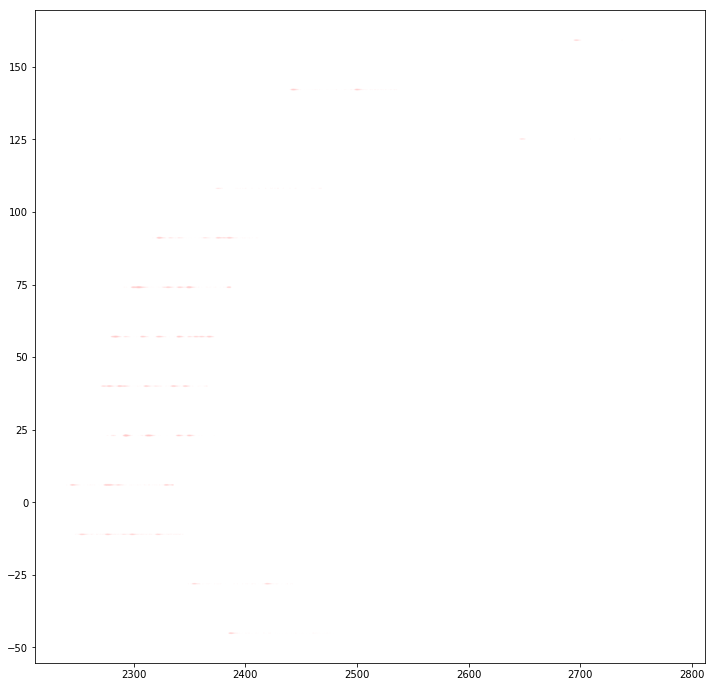

142


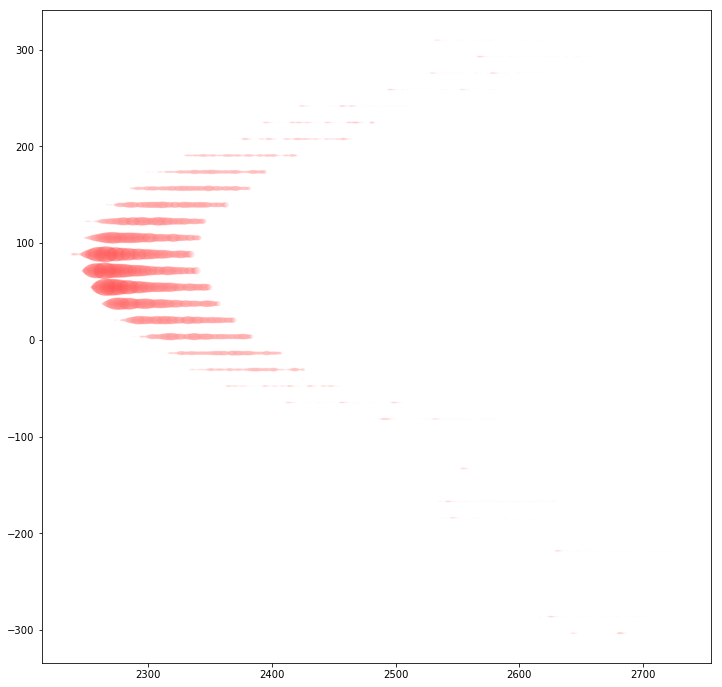

143


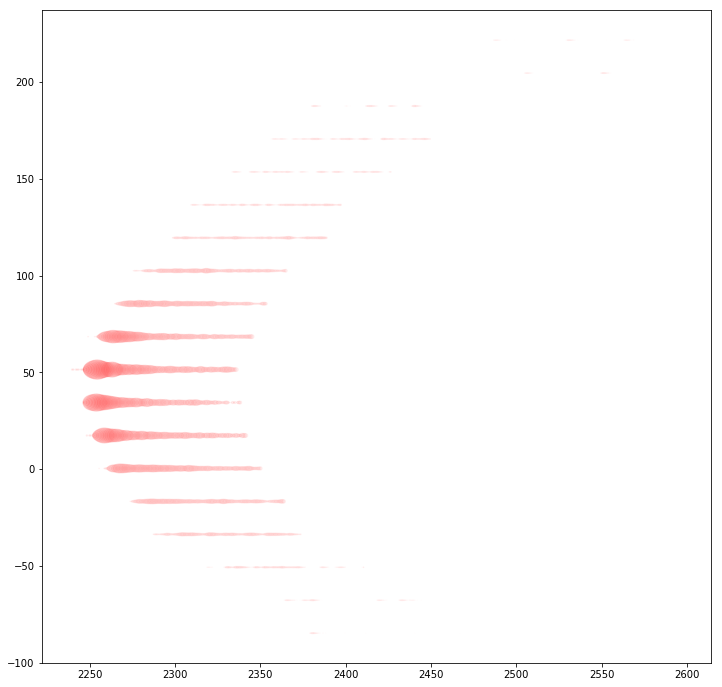

144


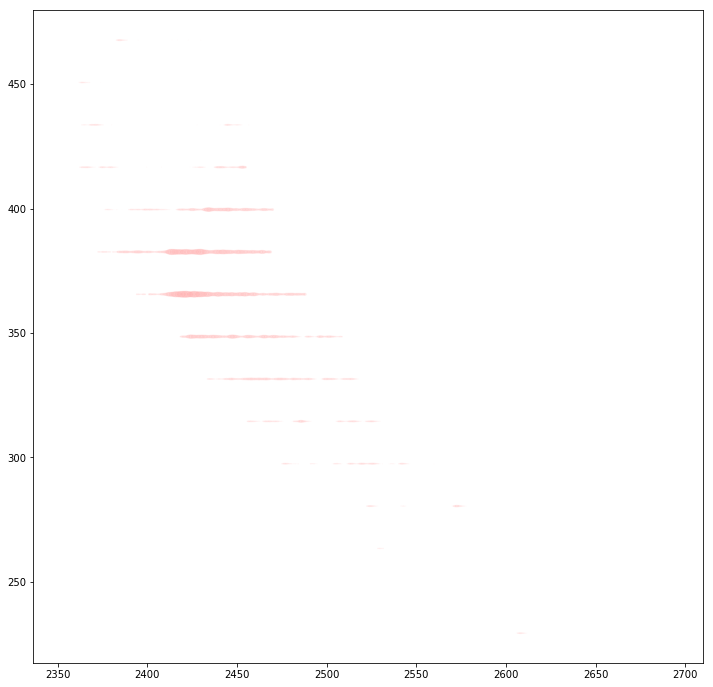

145


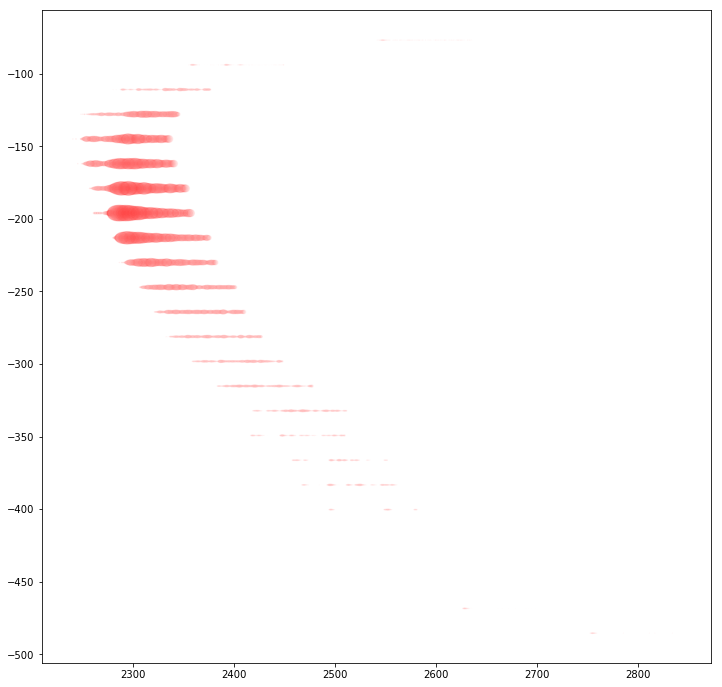

146


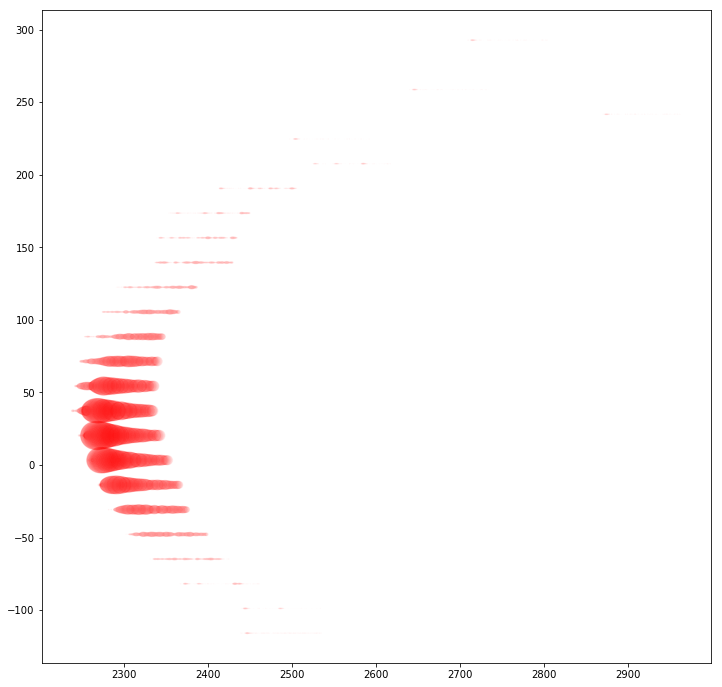

147


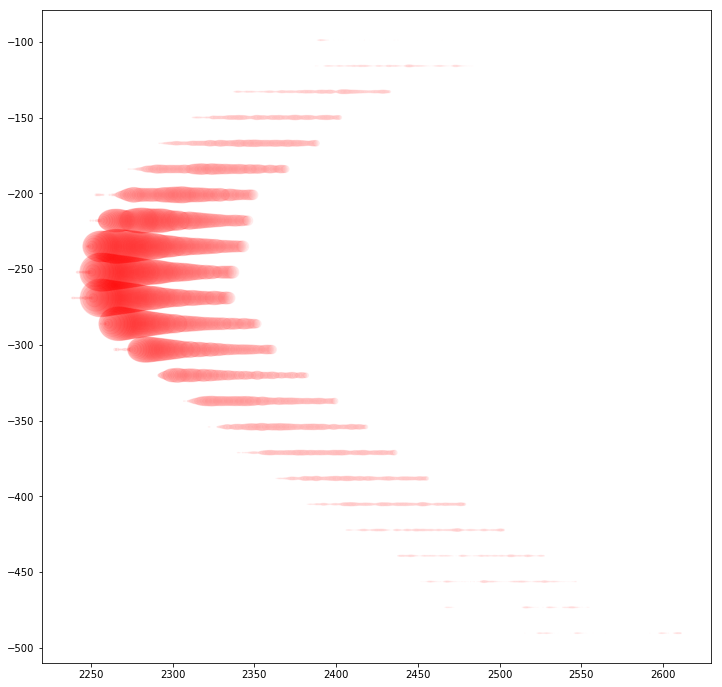

148


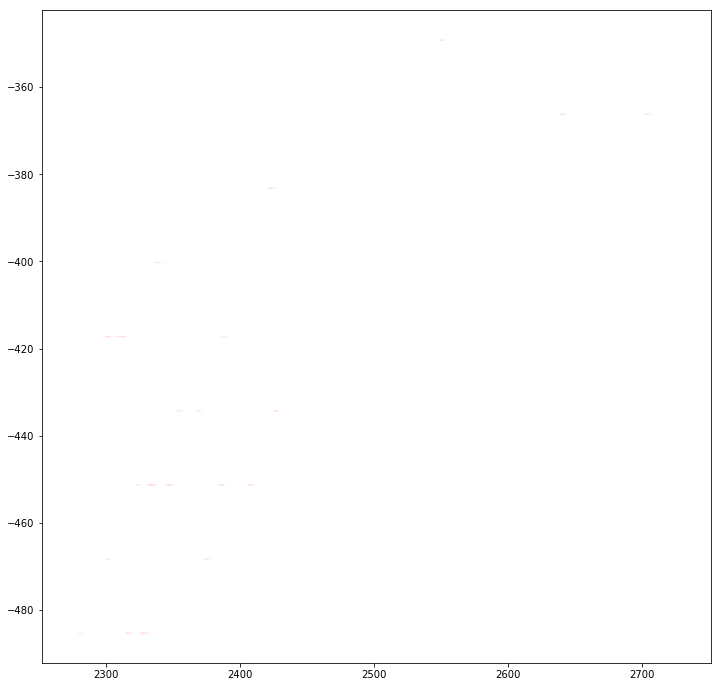

149


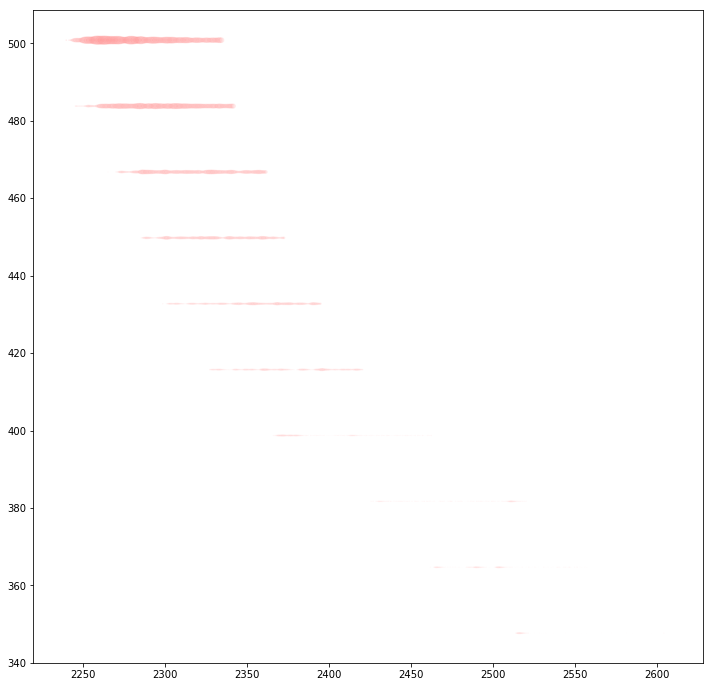

In [16]:
for i, event in enumerate(string_data[:150]):
    print i
    make_plots_no_label(event)

In [17]:
def make_image(data):
    delta_t =300
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111)
    data_sorted = data[data[:, 3].argsort()]
    start = data_sorted[:,3][0]
    mask = data_sorted[:,3]<(start+delta_t)
    data_cut = data_sorted[mask]
    y = np.unique(data_cut[:,2])
    width = data_cut[:,3][1]-data_cut[:,3][0]
    x_min = data_cut[:,3][0]
    x_max = data_cut[:,3][-1]
    x_bin = (x_max-x_min)/width+1

    H, xedg, yedg, im =  ax.hist2d(data_cut[:,3],data_cut[:,2],weights=data_cut[:,4],bins=[x_bin,len(y)],range = [[x_min,x_max],[y[0],y[-1]]], cmap='gray') 
    plt.show()
    return H

0


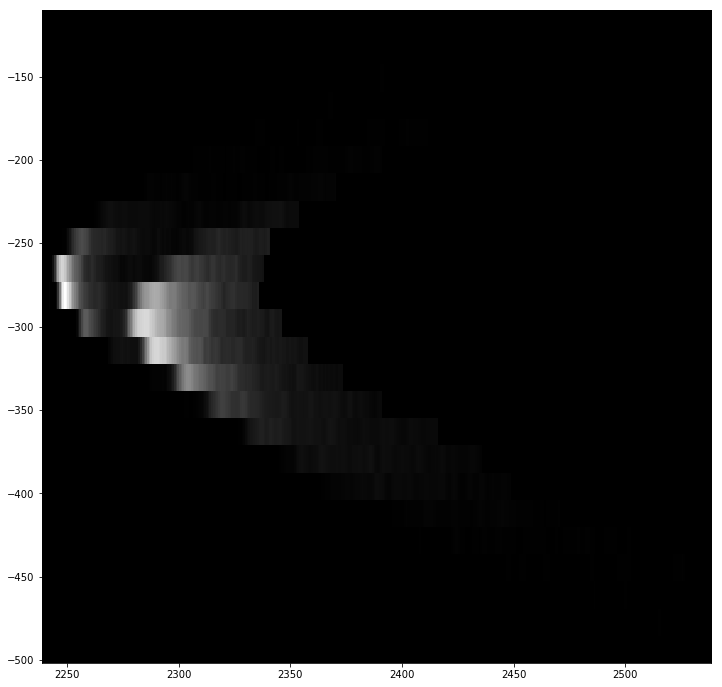

In [46]:
ims = []
for i, event in enumerate(string_data[57:58]):
    print i
    ims.append(make_image(event))
    np.save("array_event_57.npy",ims[0])

In [360]:
def make_oversampled_image(data, N=10):
    delta_t =300
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(211)
    uniq_z = np.unique(data[:,2])
    start_z = []    
    for i in range(0,len(uniq_z)):
        mask_z = data[:,2] == uniq_z[i]
        zdata = data[mask_z]
        st = np.min(zdata[:, 3])
        start_z.append(st)
    
    
    zt = zip(uniq_z,start_z)
    zt_new = []
    for i in range(0,len(zt)-1):
        for j in range(0,N):
            zt_new.append([zt[i][0],zt[i][1],zt[i+1][0],zt[i+1][1],j/N]) 
            
    zt_new = np.stack(zt_new)
    
    zt_plot = []
    for i in zt_new:
        zt_plot.append([i[0]+(i[2]-i[0])*i[4],i[1]+(i[3]-i[1])*i[4],i[0],i[1],(i[3]-i[1])*i[4]])
    zt_plot = np.stack(zt_plot)
    
    for i in zt_plot:
        print i
        
    ax.scatter(zt_plot[:,1],zt_plot[:,0])
    ax.scatter(zt_plot[:,3],zt_plot[:,2])
        
    new_data = []
    for i in zt_new:
        maskz = data[:,2] == i[0]
        maskz2 = data[:,2] == i[2]
        zdata = data[maskz]
        zdata2 = data[maskz2]
        zdata = zdata[zdata[:, 3].argsort()]
        zdata2 = zdata2[zdata2[:, 3].argsort()]
        zdata[:,2] = (i[0]+(i[2]-i[0])*i[4])*np.ones(len(zdata[:,2]))
        zdata[:,3] = zdata[:,3]+(i[3]-i[1])*i[4]*np.ones(len(zdata[:,3]))
        zdata[:,4] = zdata[:,4]*(1-i[4])+zdata2[:,4]*i[4]
        new_data.append(zdata)
    
    flat_data = []
    for i in new_data:
        for j in i:
            flat_data.append(j)
    
    flat_data = np.stack(flat_data)
    #print flat_data[:,2:4][0:200]
    start = np.min(flat_data[:,3])
    mask = flat_data[:,3]<(start+delta_t)
    data_cut = flat_data[mask]
    uniq_z = np.unique(data_cut[:,2])
    #print data_cut[:,3]
    width = 3
    x_min = np.min(data_cut[:,3])
    x_max = np.max(data_cut[:,3])
    x_bin = (x_max-x_min)/width+1
    print len(uniq_z),width,x_max,x_min,x_bin
    ax2 = fig1.add_subplot(212)
    
    #H, xedg, yedg, im =  ax2.hist2d(data_cut[:,3],data_cut[:,2],weights=data_cut[:,4],bins=len(uniq_z), cmap='gray') 
    H, xedg, yedg, im =  ax2.hist2d(data_cut[:,3],data_cut[:,2],weights=data_cut[:,4],bins=[x_bin,len(uniq_z)],range = [[x_min,x_max],[uniq_z[0],uniq_z[-1]]], cmap='gray') 

    #    #plt.show()
    return H

[ -501.57998657  2517.11405421  -501.57998657  2517.11405421    -0.        ]
[ -500.5037365   2514.44599823  -501.57998657  2517.11405421    -2.66805598]
[ -499.42748642  2511.77794225  -501.57998657  2517.11405421    -5.33611196]
[ -498.35123634  2509.10988627  -501.57998657  2517.11405421    -8.00416794]
[ -497.27498627  2506.44183029  -501.57998657  2517.11405421   -10.67222391]
[ -496.19873619  2503.77377431  -501.57998657  2517.11405421   -13.34027989]
[ -495.12248611  2501.10571833  -501.57998657  2517.11405421   -16.00833587]
[ -494.04623604  2498.43766236  -501.57998657  2517.11405421   -18.67639185]
[ -492.96998596  2495.76960638  -501.57998657  2517.11405421   -21.34444783]
[ -491.89373589  2493.1015504   -501.57998657  2517.11405421   -24.01250381]
[ -490.81748581  2490.43349442  -501.57998657  2517.11405421   -26.68055978]
[ -489.74123573  2487.76543844  -501.57998657  2517.11405421   -29.34861576]
[ -488.66498566  2485.09738246  -501.57998657  2517.11405421   -32.01667174]

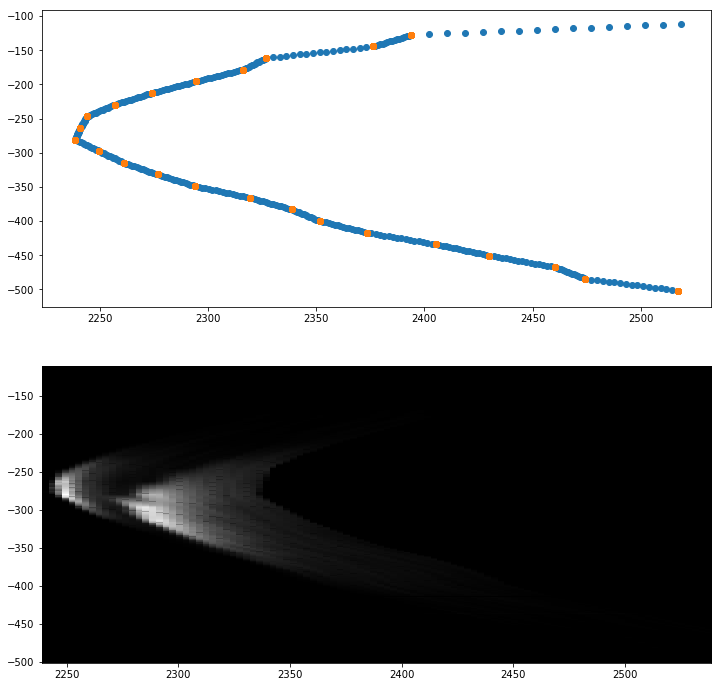

In [361]:
ims_over = []
for i, event in enumerate(string_data[57:58]):
    ims_over.append(make_oversampled_image(event,16))

In [280]:
def smooth(data, kernel):
    im_gauss = ndimage.convolve(data, kernel, mode='constant', cval=0.0)
    #im_gauss_3 = ndimage.convolve(im_gauss_2, kernel, mode='constant', cval=0.0)
    #im_gauss = ndimage.convolve(im_gauss_3, kernel, mode='constant', cval=0.0)
    
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111)
    ax.imshow(im_gauss.T, interpolation='nearest', aspect='auto', cmap= 'gray')
    plt.show()
    return im_gauss

In [284]:
def gaussian_kernel(size, sigma1=5, sigma2 =5):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma1 * sigma2)
    g =  np.exp(-(x**2 / (2.0*sigma1**2) + y**2 / (2.0*sigma2**2))) * normal
    return g#g[size,np.newaxis].T#g[size-2:size+3,:]


[[ 0.00542492  0.00576037  0.00587674  0.00576037  0.00542492]
 [ 0.00576037  0.00611658  0.00624014  0.00611658  0.00576037]
 [ 0.00587674  0.00624014  0.0063662   0.00624014  0.00587674]
 [ 0.00576037  0.00611658  0.00624014  0.00611658  0.00576037]
 [ 0.00542492  0.00576037  0.00587674  0.00576037  0.00542492]]


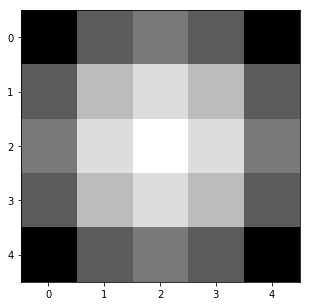

In [285]:
kern = gaussian_kernel(5,5,5)
print
fig1 = plt.figure(figsize=(5, 5))
ax = fig1.add_subplot(111)
ax.imshow(kern, interpolation='nearest', aspect='auto', cmap= 'gray')
print kern

0


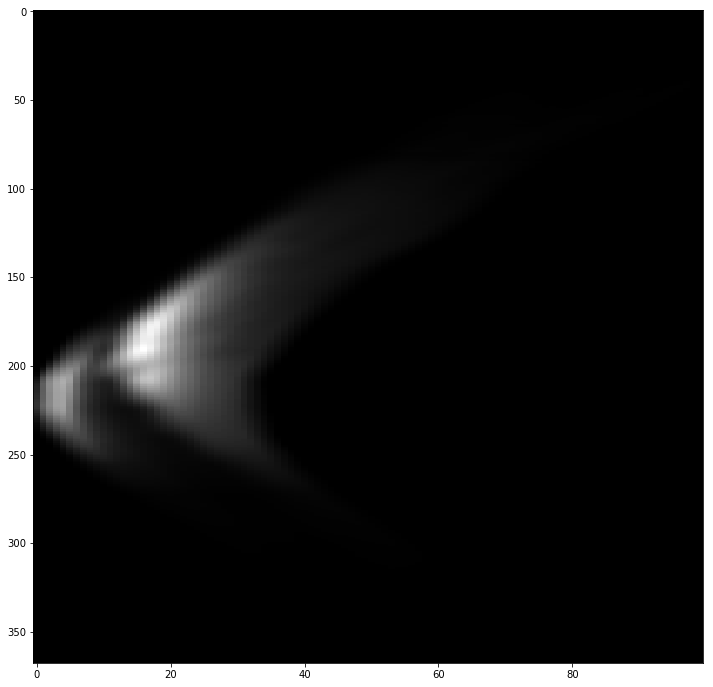

In [286]:
ims_smooth = []
for i, event in enumerate(ims_over):
    print i
    ims_smooth.append(smooth(event, kern))

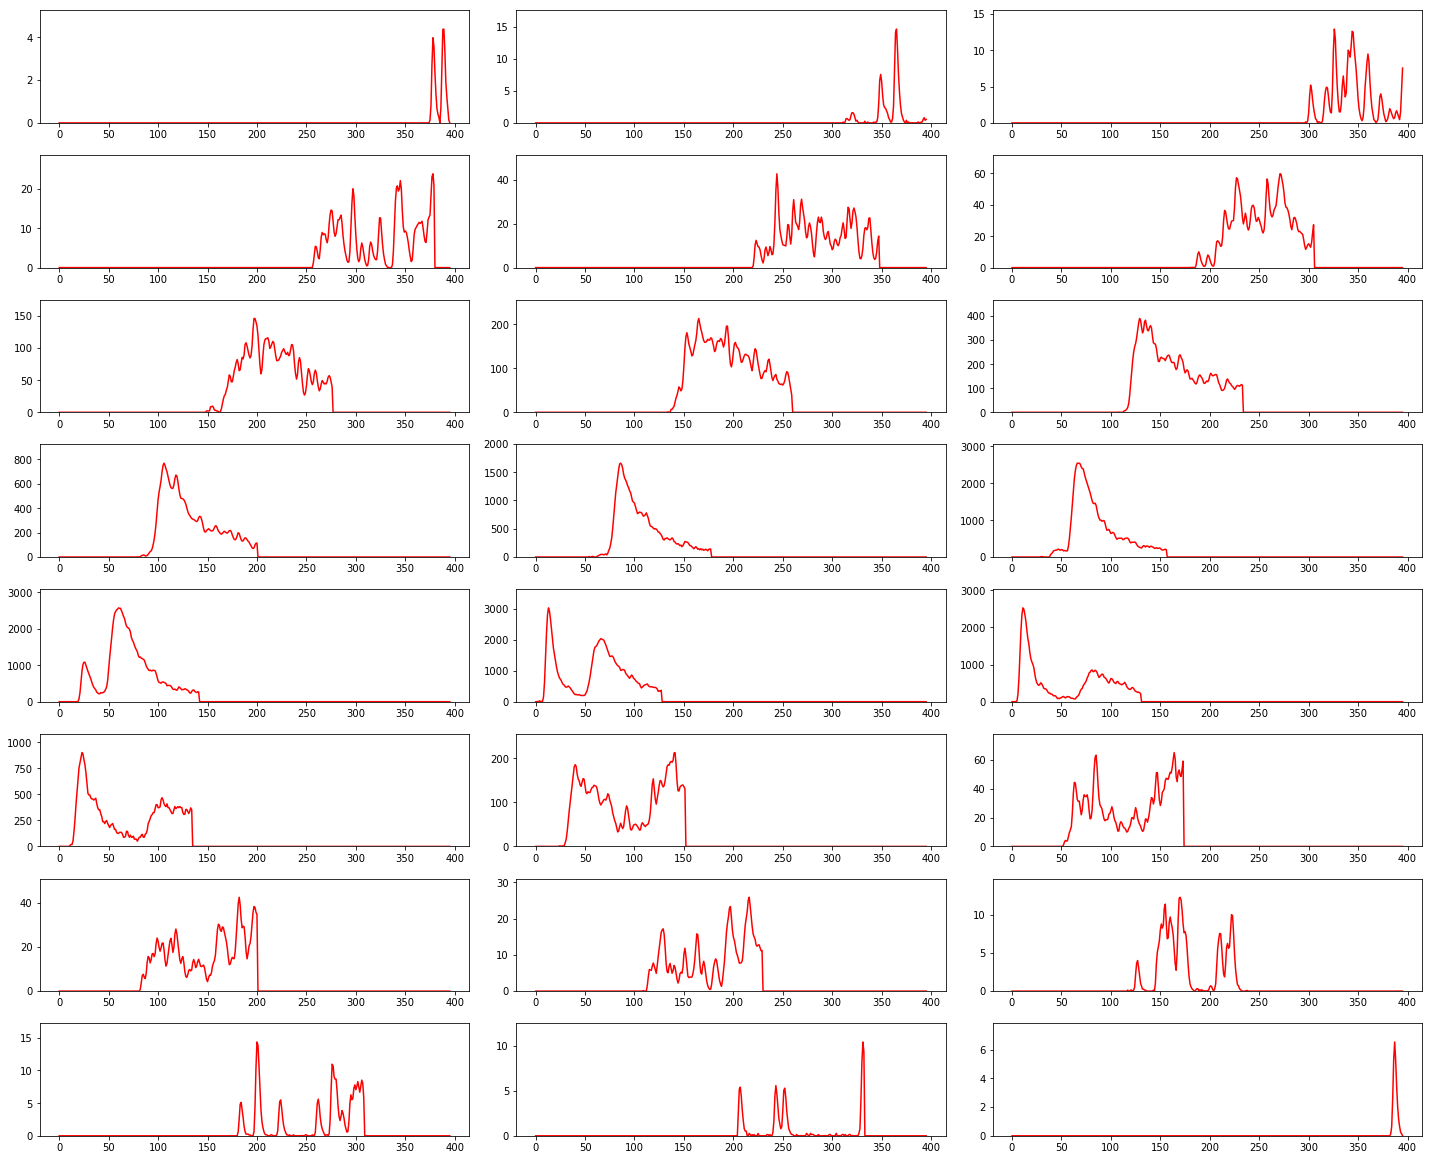

In [287]:
for i, event in enumerate(ims):
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace = .5, wspace=.1)
    for i, q in enumerate(event.T):
        wf_data = q
        max_wf = np.max(wf_data)
        times = range(0,len(wf_data))
        ax = fig.add_subplot(10, 3, i+1)
        ax.set_ylim(0,max_wf*1.2)
        ax.plot(times,wf_data,'r', label = "ONE")
    fig.tight_layout()
    plt.show()
 

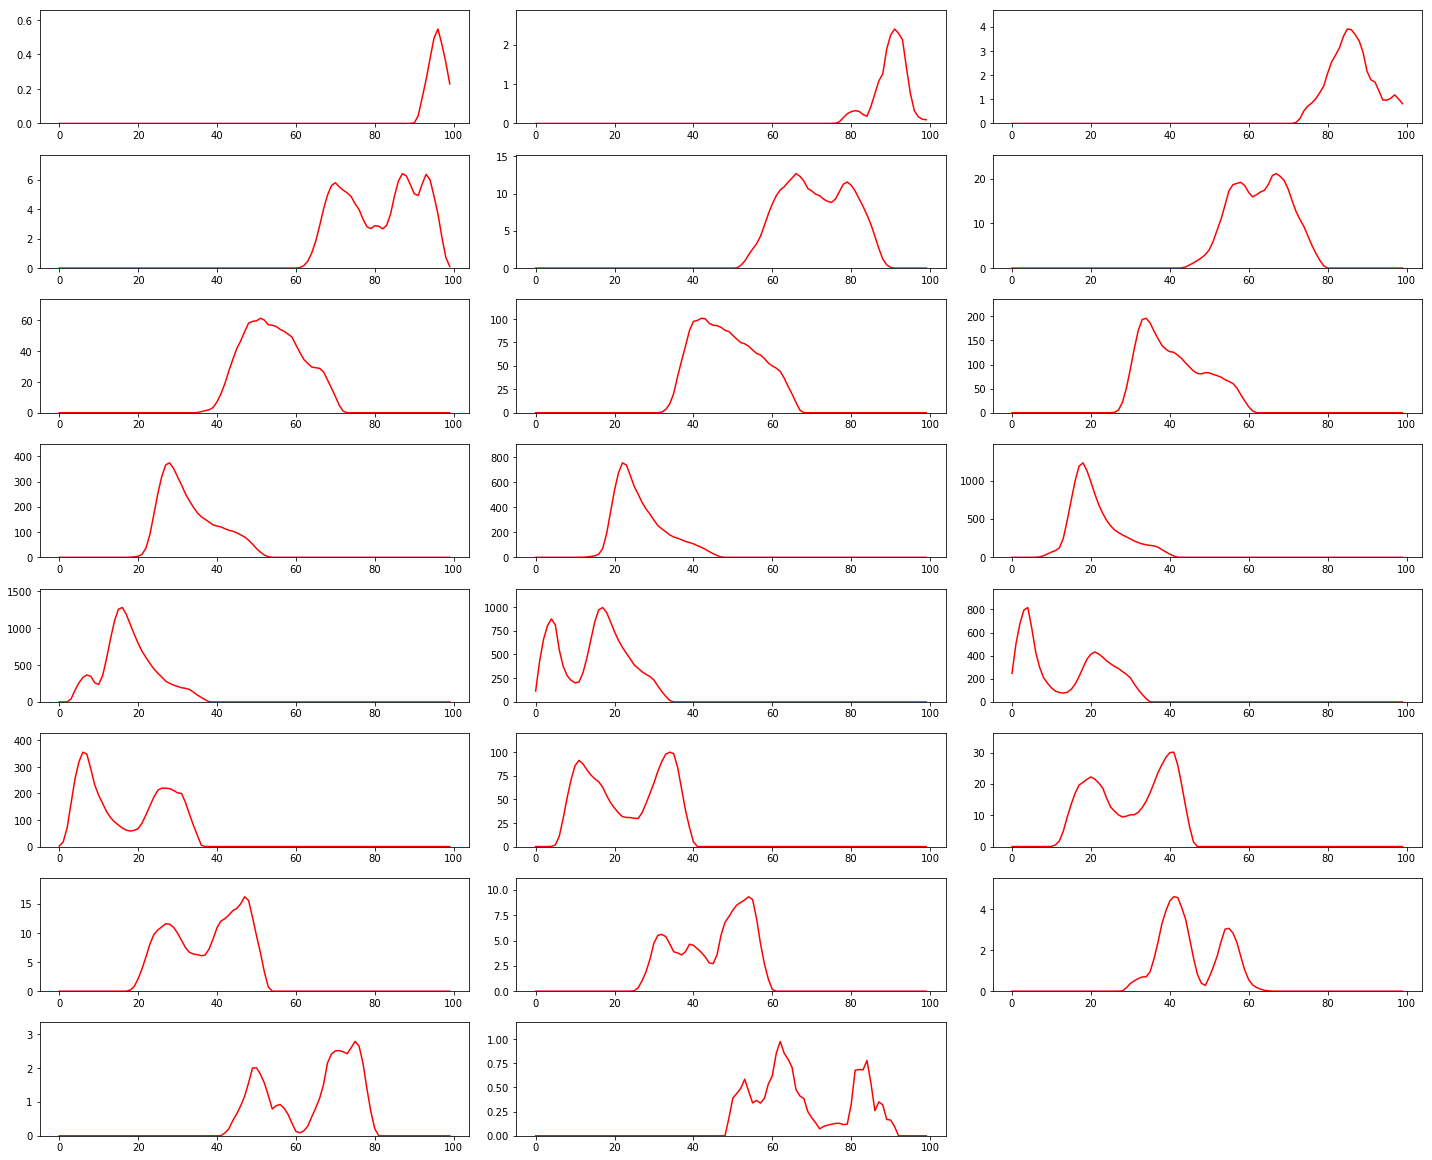

In [289]:
for i, event in enumerate(ims_smooth):
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace = .5, wspace=.1)
    for j, q in enumerate(event.T):
        if j%16 ==0:
            i= int(j/16)
            wf_data = q
            max_wf = np.max(wf_data)
            times = range(0,len(wf_data))
            ax = fig.add_subplot(10, 3, i+1)
            ax.set_ylim(0,max_wf*1.2)
            ax.plot(times,wf_data,'r', label = "ONE")  
    fig.tight_layout()
    plt.show()
 

In [328]:
def sobel_filters(img):
    K = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], np.float32)
    #Ky = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], np.float32)
    #Kx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], np.float32)
    #Ky = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], np.float32)
    #Kx = np.array([[1, 0], [0, -1]], np.float32)
    #Ky = np.array([[0, 1], [-1, 0]], np.float32)
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    G = ndimage.filters.convolve(img, Ky)

    #G = np.hypot(Ix, Iy)
    #G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    theta = 90*np.ones(G.shape)
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(211)
    ax.imshow(G.T, interpolation='nearest', aspect='auto', cmap= 'seismic')
    #ax = fig1.add_subplot(212)
    #ax.imshow(theta, interpolation='nearest', aspect='auto', cmap= 'gray')
    
    plt.show()
    
    return (img, G, theta)
    #return G

0


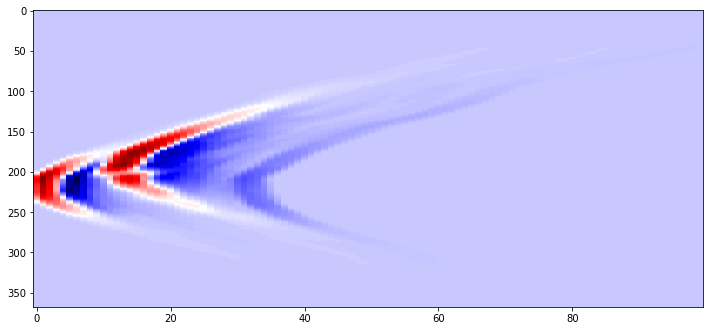

In [329]:
ims_sobel = []
for i, event in enumerate(ims_smooth):
    print i
    ims_sobel.append(sobel_filters(event))

In [314]:
def zerocross(im, thresh =0.1):
    M, N = im.shape
    labels = np.zeros((M,N), dtype=np.int32)
    for i in range(0,M-2):
        for j in range(0,N-2):
            #if im[i+1,j+1] ==0:
            #     labels[i+1,j+1]=1
            #else:
            n1 = im[i,j+1]
            n2 = im[i+2,j+1]
                
            if (n1*n2 < 0) and ((abs(n1)+abs(n2)) > thresh):
                labels[i+1,j+1]=1
                
            n3 = im[i+1,j]
            n4 = im[i+1,j+2]
                
            if (n3*n4 < 0) and ((abs(n2)+abs(n4)) > thresh):
                labels[i+1,j+1]=1
            
            n5 = im[i,j]
            n6 = im[i+2,j+2]
                
            if (n3*n4 < 0) and ((abs(n2)+abs(n4)) > thresh):
                labels[i+1,j+1]=1
            
            n7 = im[i+2,j]
            n8 = im[i,j+2]
                
            if (n3*n4 < 0) and ((abs(n2)+abs(n4)) > thresh):
                labels[i+1,j+1]=1
            
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(211)
    ax.imshow(labels.T, interpolation='nearest', aspect='auto', cmap= 'gray')
    return labels

0


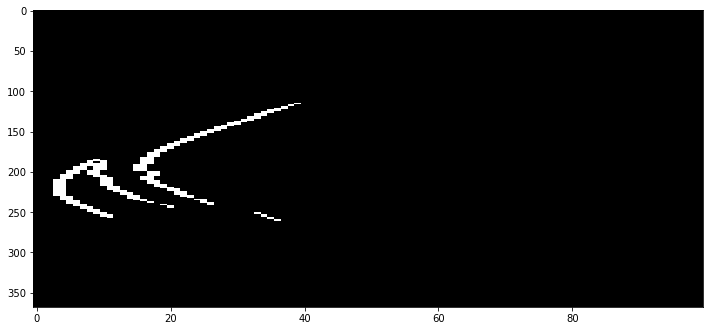

In [317]:
ims_zero = []
for i, event in enumerate(ims_sobel):
    print i
    ims_zero.append(zerocross(event, thresh =100))

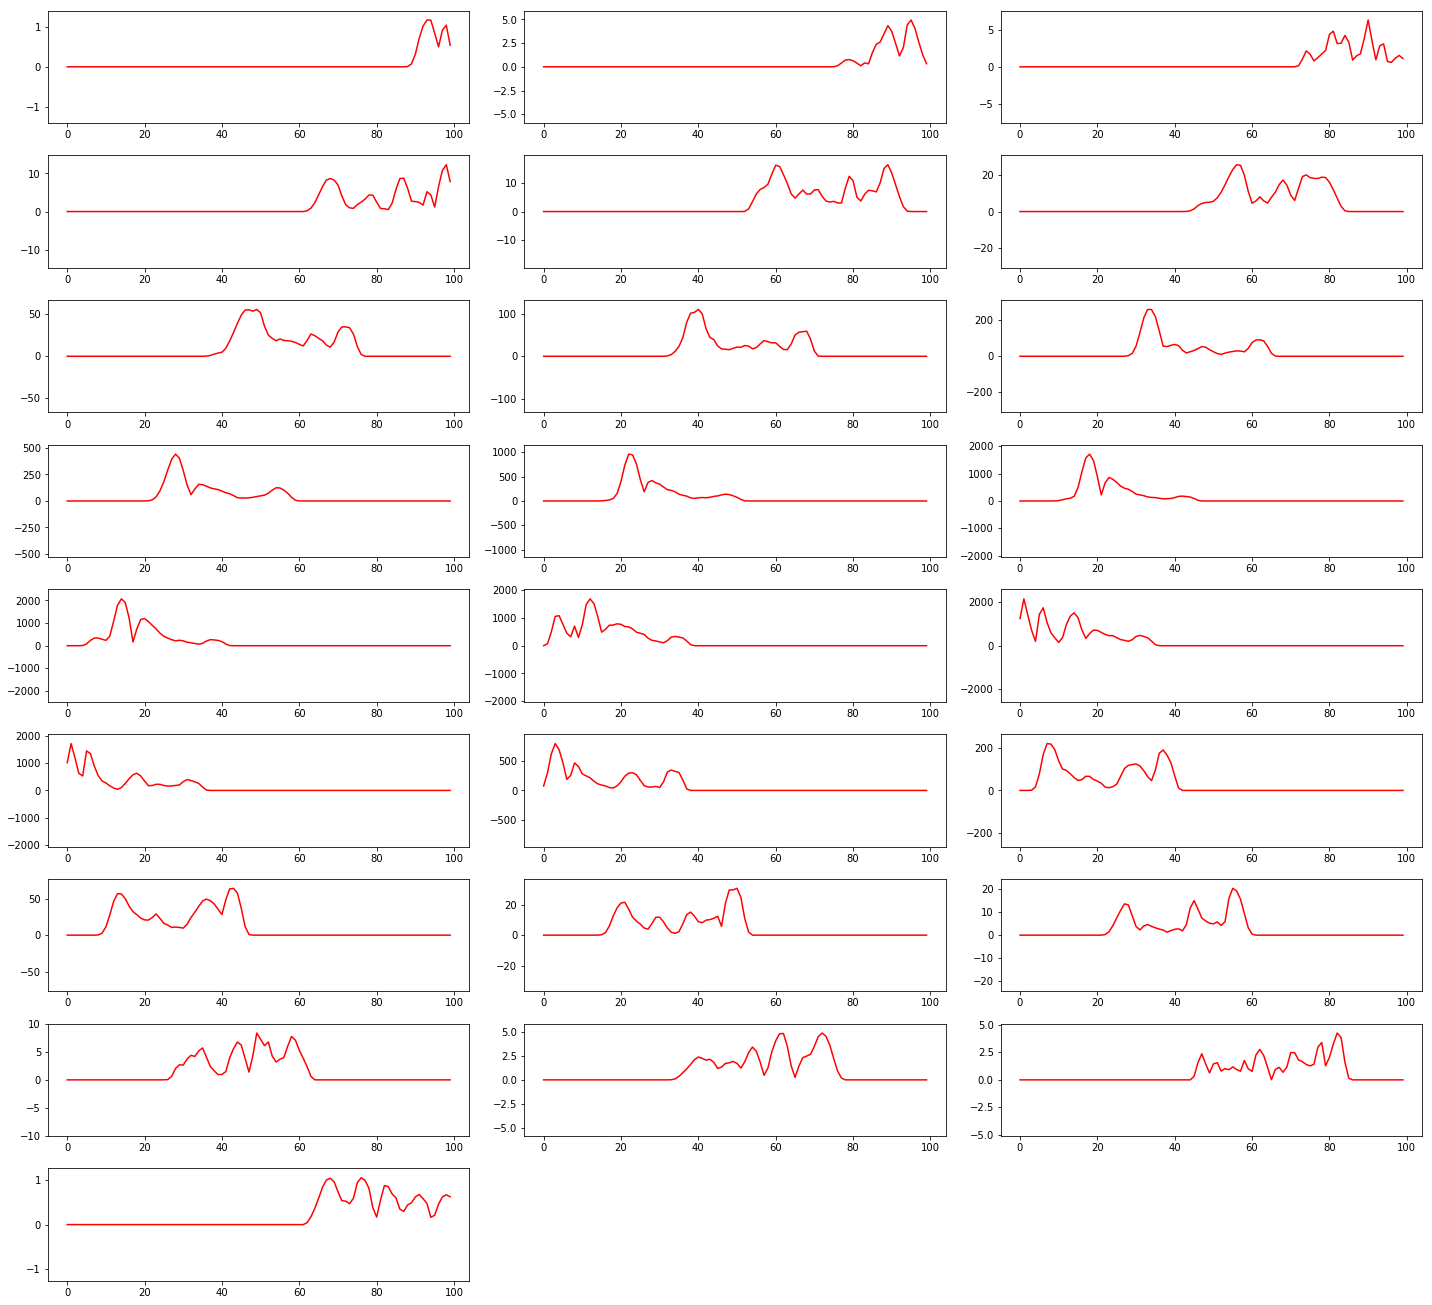

In [300]:
for i, event in enumerate(ims_sobel):
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace = .5, wspace=.1)
    for j, q in enumerate(event[1].T):
        if j%15 ==0:
            i= int(j/15)
            wf_data = q
            max_wf = np.max(wf_data)
            times = range(0,len(wf_data))
            ax = fig.add_subplot(10, 3, i+1)
            ax.set_ylim(-max_wf*1.2,max_wf*1.2)
            ax.plot(times,wf_data,'r', label = "ONE")  
    fig.tight_layout()
    plt.show()
 

In [326]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 100
                r = 100
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

0


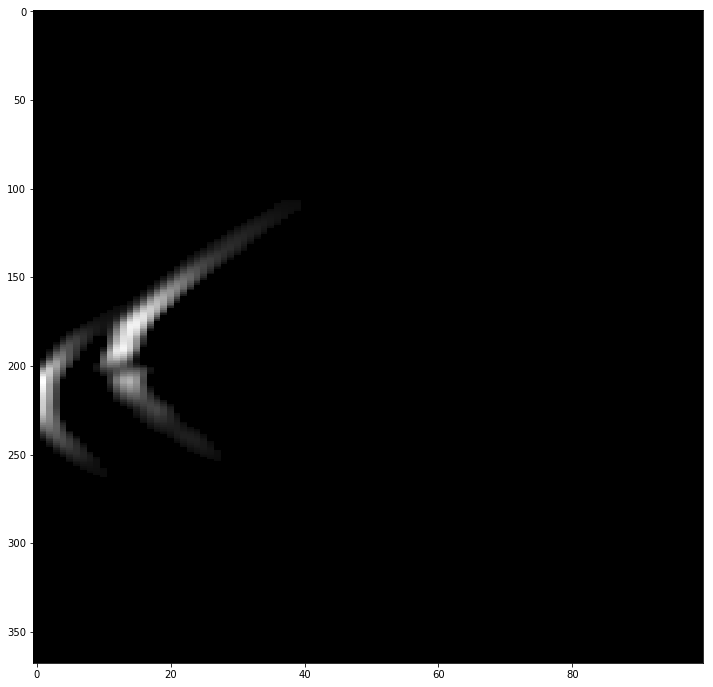

In [330]:
ims_supressed = []
for i, event in enumerate(ims_sobel):
    print i
    im = non_max_suppression(event[1],event[2])
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111)
    ax.imshow(im.T, interpolation='nearest', aspect='auto', cmap= 'gray')
    plt.show()
    ims_supressed.append(im)

In [333]:
def threshold(img, lowThresholdRatio=0.1, highThresholdRatio=0.1):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(0)
    strong = np.int32(1)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

0


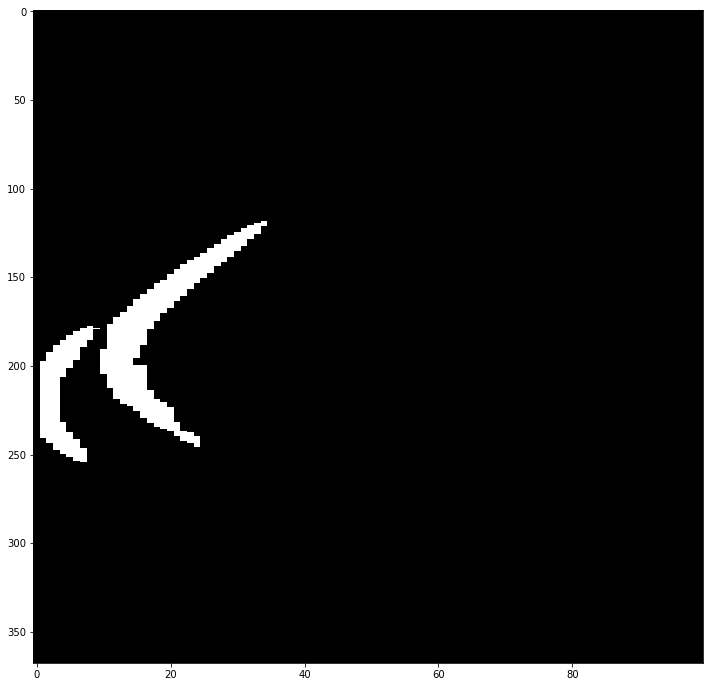

In [334]:
ims_thresh = []
for i, event in enumerate(ims_supressed):
    print i
    im,w,st = threshold(event)
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111)
    ax.imshow(im.T, interpolation='nearest', aspect='auto', cmap= 'gray')
    plt.show()
    ims_thresh.append(im)

In [169]:
def two_pass(img):
    linked = []
    M, N = img.shape
    labels = np.zeros((M,N), dtype=np.int32)
    for i,row in enumerate(img.T):
        for j,col in enumerate(row):
            if col>0:
                print i,j
                neighbors = img.T[i-1:i+2,j-1:j+2]
                print neighbors
                
                

In [170]:
for i, im in enumerate(ims_thresh):
    two_pass(im)

7 130
[[0 0 0]
 [0 1 0]
 [1 0 1]]
7 133
[[0 0 0]
 [0 1 1]
 [1 0 0]]
7 134
[[0 0 0]
 [1 1 1]
 [0 0 0]]
7 135
[[0 0 0]
 [1 1 1]
 [0 0 0]]
7 136
[[0 0 0]
 [1 1 1]
 [0 0 0]]
7 137
[[0 0 0]
 [1 1 1]
 [0 0 0]]
7 138
[[0 0 0]
 [1 1 1]
 [0 0 0]]
7 139
[[0 0 0]
 [1 1 1]
 [0 0 0]]
7 140
[[0 0 0]
 [1 1 1]
 [0 0 0]]
7 141
[[0 0 0]
 [1 1 1]
 [0 0 0]]
7 142
[[0 0 0]
 [1 1 0]
 [0 0 0]]
8 116
[[0 0 0]
 [0 1 1]
 [1 0 0]]
8 117
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 118
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 119
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 120
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 121
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 122
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 123
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 124
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 125
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 126
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 127
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 128
[[0 0 0]
 [1 1 1]
 [0 0 0]]
8 129
[[0 0 1]
 [1 1 0]
 [0 0 0]]
8 131
[[1 0 0]
 [0 1 1]
 [0 0 0]]
8 132
[[0 0 1]
 [1 1 0]
 [0 0 0]]
9 84
[[0 0 0]
 [0 1 1]
 [1 0 0]]
9 85
[[0 0 0]
 [1 1 1]
 [0 0 0]]
9 86
[[0 0 0]
 [

0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0
   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0 255   0 255   0   0
   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0 255   0 255   0   0
   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0 255   0 255   0   0
   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0 255   0 255   0   0
   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0 255   0 255   0   0   0
   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0 255  

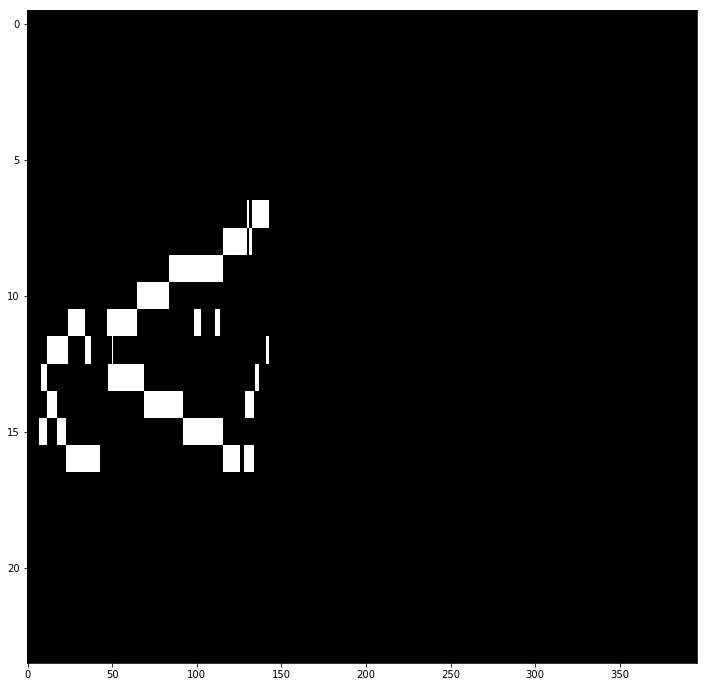

In [142]:
ims_clust = []
for i, im in enumerate(ims_thresh):
    print i
    clusters = []
    for idx, r in enumerate(im>T):
        row_piece = []
        for idy, el in enumerate(r):
            if el>0:
                
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111)
    ax.imshow(im.T, interpolation='nearest', aspect='auto', cmap= 'gray')
    plt.show()
    ims_clust.append(im)